In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/TrafficEmu copy 2


In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

from sumo_grid_simulation.grid_simulation import Simulator
import experimental_design.config as config

sns.set()

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [5]:
def user_function(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        CO2 = s['CO2']/s['num_emissions_samples']
        # average emissions / average route length
        result.append(CO2/s['duration'])
        i += 1
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [6]:
gridSize = DiscreteParameter('gridSize', domain=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
edgeMaxSpeed = ContinuousParameter('edgeMaxSpeed', min_value=8, max_value=19)
edgeLength = ContinuousParameter('edgeLength', min_value=30, max_value=70)
numberOfLanes = DiscreteParameter('numberOfLanes', domain=[1,2,3])
accel = ContinuousParameter('accel', 1.5, 5.)

parameter_space = ParameterSpace([gridSize, edgeMaxSpeed, edgeLength, numberOfLanes, accel])

### Get init and test points

In [7]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(20)
init_Y = user_function(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function(test_X)

[[11.         12.16820779 38.00705429  1.          3.22957899]
 [ 7.         16.8870144  61.04453096  1.          2.28978739]
 [ 7.         11.6272118  33.6898738   3.          3.94863087]
 [ 3.         18.91082971 57.06996959  3.          2.29733406]
 [13.         17.97503351 38.68112888  1.          1.60714183]
 [ 5.         11.23603433 61.43297705  2.          4.46932387]
 [10.         12.62538668 42.17869188  3.          4.90838608]
 [12.         10.81393456 60.60186621  1.          3.14585555]
 [ 9.         15.58116704 50.48450509  1.          1.85587719]
 [15.         13.34212933 43.46224353  3.          4.54060869]
 [16.         15.54080813 35.11722001  1.          2.50995681]
 [ 6.          8.77609411 49.13967501  1.          2.26270425]
 [ 6.         12.76575299 53.49766717  3.          1.85298361]
 [13.         15.42233448 34.83818805  3.          2.79532486]
 [19.          8.80857343 42.34447244  1.          2.98620431]
 [20.          8.25147115 41.56480259  3.          3.69

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

In [8]:
MV_Xs = []
MV_Ys = []
mses_MV = []
    
def user_function_model_variance(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        CO2 = s['CO2']/s['num_emissions_samples']
        # average emissions / average route length
        result.append(CO2/s['duration'])
        MV_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        MV_Ys.append(CO2/s['duration'])

        i += 1
    
    # evaluate / validate model
    if len(MV_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_mv.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_MV.append((len(MV_Xs), rmse))
        print('EVALUATED: ', len(MV_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [9]:
emulator_mv = GPy.models.GPRegression(init_X, init_Y)
emukit_model_mv = GPyModelWrapper(emulator_mv, n_restarts=5)
emukit_model_mv.optimize()
emulator_mv

Optimization restart 1/5, f = 101.81741946336122
Optimization restart 2/5, f = 88.43572863278789
Optimization restart 3/5, f = 88.43572863279014
Optimization restart 4/5, f = 114.67219642007274
Optimization restart 5/5, f = 99.79092576656923


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


GP_regression.,value,constraints,priors
rbf.variance,20436.866749393084,+ve,
rbf.lengthscale,21.157918210813634,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


#### Acquisition Function

In [10]:
model_variance = ModelVariance(model=emukit_model_mv)

#### Optimizer

In [11]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [12]:
ed_loop_mv = ExperimentalDesignLoop(
    model = emukit_model_mv,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [13]:
ed_loop_mv.run_loop(user_function_model_variance, 500)

Optimization restart 1/5, f = 88.43572863278789
Optimization restart 2/5, f = 101.8176428157088
Optimization restart 3/5, f = 90.14901817319074


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 4/5, f = 99.70288467634386
Optimization restart 5/5, f = 101.81778985956399
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 93.12210492883138
Optimization restart 2/5, f = 93.09475093925997
Optimization restart 3/5, f = 120.10773552492384
Optimization restart 4/5, f = 93.09475093951949
Optimization restart 5/5, f = 93.094750939356
[[20. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 97.45575103682974
Optimization restart 2/5, f = 97.44395540224602
Optimization restart 3/5, f = 97.44395540224342
Optimization restart 4/5, f = 125.6420388761051
Optimization restart 5/5, f = 97.44395540239184
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 103.35793420689579
Optimization restart 2/5, f = 103.17864860053572
Optimization restart 3/5, f = 103.1786486005445
Optimization restart 4/5, f = 134.0667842987328
Optimization restart 5/5, f = 103.17864860057482
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 110.08947464300279
Optimization restart 2/5, f = 109.08518968077054
Optimization restart 3/5, f = 126.65868850835723
Optimization restart 4/5, f = 109.92643366802966
Optimization restart 5/5, f = 110.0573075284994
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 113.29089946539469
Optimization restart 2/5, f = 131.59456187530634
Optimization restart 3/5, f = 113.60996161733576
Optimization restart 4/5, f = 145.39467419720117
Optimization restart 5/5, f = 145.39468575916734
[[20.         19.         54.71423018  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 117.54729500803883
Optimization restart 2/5, f = 117.66685338531119
Optimization restart 3/5, f = 117.66685338705207
Optimization restart 4/5, f = 136.19581694902774
Optimization restart 5/5, f = 151.06381337942528
[[ 3. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 129.91267528371554
Optimization restart 2/5, f = 148.3213311401929
Optimization restart 3/5, f = 160.75563798014215
Optimization restart 4/5, f = 130.1148325127079
Optimization restart 5/5, f = 160.75563723228376
[[20.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 134.58574089737172
Optimization restart 2/5, f = 136.4844756813472
Optimization restart 3/5, f = 136.48447568490644
Optimization restart 4/5, f = 136.48447568136507
Optimization restart 5/5, f = 153.61912473235958
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 138.32082172239834
Optimization restart 2/5, f = 138.320821737775
Optimization restart 3/5, f = 159.14441049215984
Optimization restart 4/5, f = 140.99388946960102
Optimization restart 5/5, f = 172.73126819302402
[[20.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 142.35851868952776
Optimization restart 2/5, f = 145.25256445880422
Optimization restart 3/5, f = 178.2317188248787
Optimization restart 4/5, f = 142.35840348964476
Optimization restart 5/5, f = 164.41130798900008
[[ 3.         19.         42.15635934  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 161.33259255973456
Optimization restart 2/5, f = 188.78488018416598
Optimization restart 3/5, f = 176.98538833335107
Optimization restart 4/5, f = 161.1729788934658
Optimization restart 5/5, f = 176.98594670862158
[[ 3.         12.53560508 39.70540604  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 165.8144354813588
Optimization restart 2/5, f = 165.81441724079906
Optimization restart 3/5, f = 182.5901151888897
Optimization restart 4/5, f = 182.58781184027958
Optimization restart 5/5, f = 165.8144172412557
[[20.         14.02686143 62.71803093  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 170.11865835979322
Optimization restart 2/5, f = 170.11865832037054
Optimization restart 3/5, f = 200.93218852113904
Optimization restart 4/5, f = 175.2962373060226
Optimization restart 5/5, f = 200.93235841224967
[[20.         19.         44.45756232  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 174.7460479692372
Optimization restart 2/5, f = 193.26368346923337
Optimization restart 3/5, f = 174.1588663483924
Optimization restart 4/5, f = 193.39959321149522
Optimization restart 5/5, f = 193.39587190671094
[[20.          8.         63.01240872  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 178.31983280186498
Optimization restart 2/5, f = 178.9929583245127
Optimization restart 3/5, f = 199.03775097178777
Optimization restart 4/5, f = 178.3195198120031
Optimization restart 5/5, f = 178.99295832437187
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 183.33440159096975
Optimization restart 2/5, f = 183.95872206343955
Optimization restart 3/5, f = 217.85900885603024
Optimization restart 4/5, f = 217.85903402610626
Optimization restart 5/5, f = 183.95872206340707
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 187.9705503796115
Optimization restart 2/5, f = 187.92105146374263
Optimization restart 3/5, f = 187.92105146334018
Optimization restart 4/5, f = 187.92105146425487
Optimization restart 5/5, f = 187.92105146301282
[[ 3. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 211.28640625026125
Optimization restart 2/5, f = 210.9586667208235
Optimization restart 3/5, f = 210.95866718215552
Optimization restart 4/5, f = 210.95866672093754
Optimization restart 5/5, f = 223.83851728747018
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 216.55530030318252
Optimization restart 2/5, f = 216.55474308714335
Optimization restart 3/5, f = 216.5547430855181
Optimization restart 4/5, f = 245.0072213567067
Optimization restart 5/5, f = 216.55474309820244
[[ 3.          8.         49.32607472  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 221.4100604677022
Optimization restart 2/5, f = 221.4099504025602
Optimization restart 3/5, f = 221.4099503992288
Optimization restart 4/5, f = 250.96660412172577
Optimization restart 5/5, f = 221.40995040256448
[[20.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 226.38562419973215
Optimization restart 2/5, f = 226.38562359925987
Optimization restart 3/5, f = 226.38562359921144
Optimization restart 4/5, f = 226.38562360878427
Optimization restart 5/5, f = 256.75498223295
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 231.10148720433912
Optimization restart 2/5, f = 262.51429449620093
Optimization restart 3/5, f = 231.10083999826503
Optimization restart 4/5, f = 262.5142750499603
Optimization restart 5/5, f = 231.1008399977637
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 235.81854917432068
Optimization restart 2/5, f = 235.81838386872943
Optimization restart 3/5, f = 255.82141623198447
Optimization restart 4/5, f = 235.81838334823254
Optimization restart 5/5, f = 235.818383336847
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 240.5401171767312
Optimization restart 2/5, f = 240.53995022675352
Optimization restart 3/5, f = 240.5399497873314
Optimization restart 4/5, f = 240.53994976936679
Optimization restart 5/5, f = 261.5585208321988
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 245.40363921049334
Optimization restart 2/5, f = 245.40128347948988
Optimization restart 3/5, f = 245.40128347551973
Optimization restart 4/5, f = 266.96778279539774
Optimization restart 5/5, f = 245.4012849085882
[[ 3.          8.         54.28869799  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 250.28372226671948
Optimization restart 2/5, f = 286.8068605113212
Optimization restart 3/5, f = 250.28349580246993
Optimization restart 4/5, f = 250.2834957968683
Optimization restart 5/5, f = 250.28349635132335
[[12.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 254.91577491856034
Optimization restart 2/5, f = 254.91388094926964
Optimization restart 3/5, f = 297.27376067631315
Optimization restart 4/5, f = 254.91388035621426
Optimization restart 5/5, f = 254.91388035616808
[[20.         19.         57.26129304  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 259.44051877723496
Optimization restart 2/5, f = 283.50028437566345
Optimization restart 3/5, f = 259.43911023694284
Optimization restart 4/5, f = 298.4142374293318
Optimization restart 5/5, f = 259.43911023647667
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 264.37047527601277
Optimization restart 2/5, f = 264.3560508222518
Optimization restart 3/5, f = 308.90243353844664
Optimization restart 4/5, f = 264.3560479206722
Optimization restart 5/5, f = 264.3560479216235
[[20.          8.         57.46203627  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 268.84104367032666
Optimization restart 2/5, f = 268.8295984506452
Optimization restart 3/5, f = 268.8295984495492
Optimization restart 4/5, f = 268.82959846095804
Optimization restart 5/5, f = 314.70725704714164
[[ 3.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 273.65036182471044
Optimization restart 2/5, f = 273.6498672271774
Optimization restart 3/5, f = 273.64986980063236
Optimization restart 4/5, f = 279.91043506719615
Optimization restart 5/5, f = 273.6498672164309
[[ 3.         19.         59.13400692  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 279.03049404290726
Optimization restart 2/5, f = 278.9823089852577
Optimization restart 3/5, f = 278.9823089844116
Optimization restart 4/5, f = 278.9823089844163
Optimization restart 5/5, f = 278.98230898482376
[[12.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 283.3811353731931
Optimization restart 2/5, f = 283.371932524683
Optimization restart 3/5, f = 283.3719326108873
Optimization restart 4/5, f = 283.37193251575627
Optimization restart 5/5, f = 283.37193251404165
[[20.         19.         43.65532751  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 287.6826790009352
Optimization restart 2/5, f = 287.67575977915476
Optimization restart 3/5, f = 324.252989129846
Optimization restart 4/5, f = 287.6757597800581
Optimization restart 5/5, f = 287.67576003961267
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 295.32728771123504
Optimization restart 2/5, f = 295.30590830734525
Optimization restart 3/5, f = 295.3059083165862
Optimization restart 4/5, f = 295.3059083256082
Optimization restart 5/5, f = 295.3059083619574
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 299.78228464694627
Optimization restart 2/5, f = 353.8304569035037
Optimization restart 3/5, f = 353.8303498866199
Optimization restart 4/5, f = 353.8303225502206
Optimization restart 5/5, f = 299.7785174309201
[[12.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 304.12246348037763
Optimization restart 2/5, f = 304.1188743598609
Optimization restart 3/5, f = 304.11887436251806
Optimization restart 4/5, f = 304.11887435985886
Optimization restart 5/5, f = 304.11887436002814
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 308.43070041405554
Optimization restart 2/5, f = 347.1401884953467
Optimization restart 3/5, f = 308.4297425957455
Optimization restart 4/5, f = 308.4297425956876


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 5/5 failed
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 312.84731896545395
Optimization restart 2/5, f = 312.8456927352701
Optimization restart 3/5, f = 352.883297046085
Optimization restart 4/5, f = 312.8456927307232
Optimization restart 5/5, f = 312.84569273001443
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 317.15648213794293
Optimization restart 2/5, f = 317.15481101617934
Optimization restart 3/5, f = 377.3405643887853
Optimization restart 4/5, f = 317.1548109970763
Optimization restart 5/5, f = 317.15481099715333
[[12.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 321.49348487767537
Optimization restart 2/5, f = 321.49082753038607
Optimization restart 3/5, f = 321.4908275313546
Optimization restart 4/5, f = 321.49082753015915
Optimization restart 5/5, f = 321.49082753612606
[[10.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 325.9769301140159
Optimization restart 2/5, f = 328.40908208563695
Optimization restart 3/5, f = 389.0504158918728
Optimization restart 4/5, f = 325.9749064012482
Optimization restart 5/5, f = 325.9749064008759
[[ 3.         19.         44.55762018  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 330.32345244844663
Optimization restart 2/5, f = 330.3233384245832
Optimization restart 3/5, f = 330.3233384218569
Optimization restart 4/5, f = 330.323338421443
Optimization restart 5/5, f = 377.48613953000165
[[20.         11.99883141 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 334.55957489811453
Optimization restart 2/5, f = 334.559567247576
Optimization restart 3/5, f = 334.55956727665443
Optimization restart 4/5, f = 334.55956724764064
Optimization restart 5/5, f = 334.5595672475124
[[13.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 338.79469850789474
Optimization restart 2/5, f = 338.7908254721009
Optimization restart 3/5, f = 338.79082548968233


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 340.1427228763645
Optimization restart 5/5, f = 338.79082546657577
[[ 3.         19.         43.78951329  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 343.4087441417849
Optimization restart 2/5, f = 343.4084217975739
Optimization restart 3/5, f = 415.77249764554205
Optimization restart 4/5, f = 343.40842173768294
Optimization restart 5/5, f = 343.4084217414968
[[20.         13.37586674 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 347.53704719463417
Optimization restart 2/5, f = 421.58354442196537
Optimization restart 3/5, f = 421.5832533496193
Optimization restart 4/5, f = 347.53701903523154
Optimization restart 5/5, f = 421.58362786961845
[[ 3.         15.28785966 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 351.85459857012376
Optimization restart 2/5, f = 428.3619445002562
Optimization restart 3/5, f = 351.85418279994485
Optimization restart 4/5, f = 351.85418278911885
Optimization restart 5/5, f = 351.8541827949902
[[11.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 355.99866428476656
Optimization restart 2/5, f = 355.99860186704177
Optimization restart 3/5, f = 355.99860186310303
Optimization restart 4/5, f = 355.99860186512564
Optimization restart 5/5, f = 382.5296776416249
[[ 3.         14.49026801 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 13.208633180740186
Optimization restart 1/5, f = 360.1109447915216
Optimization restart 2/5, f = 360.11089199781844
Optimization restart 3/5, f = 440.527240311342


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 4/5, f = 440.52719063423535
Optimization restart 5/5, f = 440.52715258878254
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 364.4222377004061
Optimization restart 2/5, f = 391.26646598799965
Optimization restart 3/5, f = 364.4220742502882
Optimization restart 4/5, f = 365.14207043201895
Optimization restart 5/5, f = 364.42207423763654
[[20.          8.         58.04248746  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 368.50790258410433
Optimization restart 2/5, f = 368.50790129056037
Optimization restart 3/5, f = 401.09838721587226
Optimization restart 4/5, f = 368.50790129063444
Optimization restart 5/5, f = 368.50790128947153
[[10.          8.         42.92907852  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 372.5552717568902
Optimization restart 2/5, f = 457.94767701625204
Optimization restart 3/5, f = 372.5512238708968
Optimization restart 4/5, f = 373.2788765810119
Optimization restart 5/5, f = 372.55122398918
[[20.         19.         60.55903995  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 376.67795480076626
Optimization restart 2/5, f = 463.7512217967217
Optimization restart 3/5, f = 376.6779044805808
Optimization restart 4/5, f = 376.67790357740284
Optimization restart 5/5, f = 376.6779036109623
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 380.6611377813612
Optimization restart 2/5, f = 380.6602134286974
Optimization restart 3/5, f = 380.6602134240698
Optimization restart 4/5, f = 380.66021342323324
Optimization restart 5/5, f = 381.5605470093267
[[11. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 385.87932949146085
Optimization restart 2/5, f = 402.2947817099754
Optimization restart 3/5, f = 385.8761795602227
Optimization restart 4/5, f = 461.8583321888707
Optimization restart 5/5, f = 385.8761795597927
[[12. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 393.2316219712135
Optimization restart 2/5, f = 393.22739321921597
Optimization restart 3/5, f = 393.22739321883535
Optimization restart 4/5, f = 393.2273932624362
Optimization restart 5/5, f = 393.22739321997284
[[ 3.          8.         57.14823922  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 397.46094473588505
Optimization restart 2/5, f = 474.26805961775415
Optimization restart 3/5, f = 474.26809186460207
Optimization restart 4/5, f = 397.46064374817024
Optimization restart 5/5, f = 397.4606437756674
[[ 3.          8.         41.12076097  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 401.59688782866533
Optimization restart 2/5, f = 401.596874653608
Optimization restart 3/5, f = 417.92096706951384
Optimization restart 4/5, f = 401.5968746475862
Optimization restart 5/5, f = 401.59687483688833
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 405.9221223722913
Optimization restart 2/5, f = 472.3612298061127
Optimization restart 3/5, f = 409.97618692742583
Optimization restart 4/5, f = 405.9215488359668
Optimization restart 5/5, f = 409.97616519776807
[[ 3.          8.         59.85664772  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 410.22221849577073
Optimization restart 2/5, f = 410.21733428071957


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 445.6182356083972
Optimization restart 4/5, f = 410.21733428013624
Optimization restart 5/5, f = 478.95412679530983
[[20.          8.         49.94847385  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 414.47682962543576
Optimization restart 2/5, f = 419.12741591023416


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 3/5 failed
Optimization restart 4/5, f = 414.47523610538855
Optimization restart 5/5, f = 484.7154180818426
[[20.         13.92678853 46.72033424  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 418.43970244530385
Optimization restart 2/5, f = 423.6610302658119
Optimization restart 3/5, f = 418.43969071101856
Optimization restart 4/5, f = 418.43969013822624
Optimization restart 5/5, f = 423.6837771252386
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 422.57302985109715
Optimization restart 2/5, f = 422.5730074432952
Optimization restart 3/5, f = 422.573007441878
Optimization restart 4/5, f = 422.57300745792804
Optimization restart 5/5, f = 495.8031798828943
[[20.         13.58392648 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 426.5531494292266
Optimization restart 2/5, f = 426.55289539097936
Optimization restart 3/5, f = 426.5528953906286
Optimization restart 4/5, f = 501.29714997451754
Optimization restart 5/5, f = 431.3386926520581
[[12.         19.         48.82562451  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 430.59631482999606
Optimization restart 2/5, f = 430.59571667387706
Optimization restart 3/5, f = 507.23985164327115
Optimization restart 4/5, f = 436.1092895393801
Optimization restart 5/5, f = 430.59571666259757
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 434.84886433288
Optimization restart 2/5, f = 428.1645193553448
Optimization restart 3/5, f = 428.16453066928557
Optimization restart 4/5, f = 428.1646171655358
Optimization restart 5/5, f = 428.16452374675055
[[13.          8.         52.58500788  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 433.1095485692799
Optimization restart 2/5, f = 480.3014747898137
Optimization restart 3/5, f = 433.10761705987807
Optimization restart 4/5, f = 439.09221164571915
Optimization restart 5/5, f = 439.0922117378651
[[17.         13.53743172 54.18484362  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 437.8806535556758
Optimization restart 2/5, f = 437.87855231471013
Optimization restart 3/5, f = 442.84406813222733
Optimization restart 4/5, f = 510.78959449345774
Optimization restart 5/5, f = 437.878545206183
[[ 9.         19.         54.38959497  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 442.7418246838391
Optimization restart 2/5, f = 459.99172992618645
Optimization restart 3/5, f = 448.25895020457205
Optimization restart 4/5, f = 444.2369865050274
Optimization restart 5/5, f = 442.74179172355826
[[13.       19.       63.486801  3.        5.      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 447.55712435472924
Optimization restart 2/5, f = 447.5544842162794
Optimization restart 3/5, f = 447.5544995851261


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 447.5544848362039
Optimization restart 5/5, f = 452.1870641074588
[[ 7.         19.         36.54032999  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 456.0250143499451
Optimization restart 2/5, f = 459.94031883171846
Optimization restart 3/5, f = 455.9774530935753
Optimization restart 4/5, f = 459.9403188316262
Optimization restart 5/5, f = 459.94031883161443
[[ 3.          8.         37.83584087  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 460.8156536983708
Optimization restart 2/5, f = 536.377699561695
Optimization restart 3/5, f = 464.77691782859785
Optimization restart 4/5, f = 545.5195511540538
Optimization restart 5/5, f = 536.3780906040306


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.         16.15012115 51.34693863  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 465.50322130497585
Optimization restart 2/5, f = 468.88454912403733
Optimization restart 3/5, f = 465.4988702233112
Optimization restart 4/5, f = 510.1377522419382


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 465.4989855027452
[[ 9.          8.         63.53439073  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 470.210484475791
Optimization restart 2/5, f = 470.20938451578
Optimization restart 3/5, f = 470.20941103322855
Optimization restart 4/5, f = 472.8306773492213
Optimization restart 5/5, f = 472.8306771674637
[[20.         19.         36.89237367  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 474.96393594241044
Optimization restart 2/5, f = 474.96283969416953
Optimization restart 3/5, f = 474.96283759207057
Optimization restart 4/5, f = 476.7238398945049
Optimization restart 5/5, f = 556.1960506963884
[[14.         19.         48.94816106  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 479.55157375827275
Optimization restart 2/5, f = 480.60867353018386
Optimization restart 3/5, f = 479.54936299508955
Optimization restart 4/5, f = 480.6086735312765
Optimization restart 5/5, f = 480.60867382268145
[[12.          8.         55.20477743  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 484.0830114352019
Optimization restart 2/5, f = 567.262493511342
Optimization restart 3/5, f = 567.2622243810613
Optimization restart 4/5, f = 573.8259761904296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 567.2622577153772
[[20.         12.2518871  37.26818532  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 488.74839716434775
Optimization restart 2/5, f = 488.7450569584845
Optimization restart 3/5, f = 488.7450457008664
Optimization restart 4/5, f = 580.5544166923928
Optimization restart 5/5, f = 488.15859510203904
[[ 3.         13.91094976 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 494.2040826274561
Optimization restart 2/5, f = 494.18347144355755
Optimization restart 3/5, f = 494.1834714440813
Optimization restart 4/5, f = 494.18347189743645
Optimization restart 5/5, f = 494.18347146414584
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 498.4551959771152
Optimization restart 2/5, f = 497.8181861156663
Optimization restart 3/5, f = 595.7912338004896
Optimization restart 4/5, f = 498.45398065838936
Optimization restart 5/5, f = 498.4539806583885
[[ 3.         12.95863912 47.38169674  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 502.24504391171513
Optimization restart 2/5, f = 502.34136085560743
Optimization restart 3/5, f = 502.2373754632836
Optimization restart 4/5, f = 502.2373149068238
Optimization restart 5/5, f = 595.1762824263109
[[20.         13.80720701 42.1120367   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 506.66357954463916
Optimization restart 2/5, f = 509.0260531976589


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 506.66339660946727
Optimization restart 4/5, f = 600.9667602505851
Optimization restart 5/5, f = 506.66346882551204
[[20.         11.30286099 64.97315158  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 511.11491597679014
Optimization restart 2/5, f = 511.11225345063485
Optimization restart 3/5, f = 511.11227849639886
Optimization restart 4/5, f = 511.1122394634907
Optimization restart 5/5, f = 510.03059273100195
[[ 3.         13.87164036 63.79835614  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 513.9033158548039
Optimization restart 2/5, f = 513.900491961931
Optimization restart 3/5, f = 515.3653715152673
Optimization restart 4/5, f = 513.9004919992848


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 515.3654006168723
[[ 7.         14.03653634 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 522.3438940075587
Optimization restart 2/5, f = 522.3356306441667


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 522.4064604150528
Optimization restart 4/5, f = 522.335630954366
Optimization restart 5/5, f = 522.3356306503657
[[ 9.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 526.1504146410218
Optimization restart 2/5, f = 526.150405837474


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 526.5788587921784
Optimization restart 4/5, f = 526.5788706944448
Optimization restart 5/5, f = 526.5789238365847
[[ 3.          8.         40.33047261  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 530.2342251808236
Optimization restart 2/5, f = 530.5546392390819
Optimization restart 3/5, f = 530.2340685179536
Optimization restart 4/5, f = 530.2340685168487
Optimization restart 5/5, f = 530.5546356672273
[[20.          8.         35.68809497  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 534.1293764424834
Optimization restart 2/5, f = 534.5985661944677
Optimization restart 3/5, f = 534.129376410973
Optimization restart 4/5, f = 534.129376412758
Optimization restart 5/5, f = 534.5986707312352
[[10.          8.         38.33977332  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 537.8878388530478
Optimization restart 2/5, f = 642.8749729332542
Optimization restart 3/5, f = 539.0711005120033


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 539.071061920309
Optimization restart 5/5, f = 539.0710630156856
[[ 3.         19.         61.12501914  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 541.7757069916115
Optimization restart 2/5, f = 543.6483985185464
Optimization restart 3/5, f = 541.770839670397
Optimization restart 4/5, f = 543.6483692350433
Optimization restart 5/5, f = 541.7708396714336
[[20.         12.78712505 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 545.5112807685459
Optimization restart 2/5, f = 545.5112752156219
Optimization restart 3/5, f = 547.4565049277954
Optimization restart 4/5, f = 545.5112752144867
Optimization restart 5/5, f = 545.5112752155661
[[20.          8.         65.30152942  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 549.2372534057344
Optimization restart 2/5, f = 551.3207815296362
Optimization restart 3/5, f = 549.2372371501706
Optimization restart 4/5, f = 551.3207492269449
Optimization restart 5/5, f = 549.2372372625324
[[20.         19.         60.35803458  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 552.9452747032186
Optimization restart 2/5, f = 552.9448368504991


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 613.0901670439338
Optimization restart 4/5, f = 555.3674682646472
Optimization restart 5/5, f = 555.3674262450368
[[ 3.         19.         37.74661719  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 556.665019762417
Optimization restart 2/5, f = 556.6645426388126
Optimization restart 3/5, f = 560.5170088135188
Optimization restart 4/5, f = 556.6645426392927
Optimization restart 5/5, f = 674.3568514958323
[[13.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 560.2943193906195
Optimization restart 2/5, f = 679.8914637418582
Optimization restart 3/5, f = 564.183175900938
Optimization restart 4/5, f = 564.1831457719999
Optimization restart 5/5, f = 678.8407686241834
[[20.         19.         38.51246897  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 564.3005265933826
Optimization restart 2/5, f = 568.3245054590907
Optimization restart 3/5, f = 684.8246586369428
Optimization restart 4/5, f = 564.2980274735127
Optimization restart 5/5, f = 568.3245158238524
[[20.         13.57797704 51.70100756  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 567.9168481062524
Optimization restart 2/5, f = 572.3319903241074
Optimization restart 3/5, f = 572.3320196793775
Optimization restart 4/5, f = 572.3319729012452
Optimization restart 5/5, f = 690.5690533883269
[[11. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 572.6858795922919
Optimization restart 2/5, f = 577.1558016998098
Optimization restart 3/5, f = 697.1892362294806
Optimization restart 4/5, f = 577.1559708264765
Optimization restart 5/5, f = 572.6828265659304
[[20.         19.         48.21942746  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 6.608167699855098
Optimization restart 1/5, f = 576.5840079067186


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 576.5838104323502
Optimization restart 3/5, f = 702.9553853362822
Optimization restart 4/5, f = 576.5838104043063
Optimization restart 5/5, f = 581.3642326472374
[[20.         19.         62.29778438  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 580.2421552510175
Optimization restart 2/5, f = 585.1284834682937
Optimization restart 3/5, f = 580.2418997153561
Optimization restart 4/5, f = 580.2418997808164


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 708.8048480805344
[[16.          8.         44.12761641  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 583.8292860153839
Optimization restart 2/5, f = 583.828879349595
Optimization restart 3/5, f = 583.8288793497943
Optimization restart 4/5, f = 588.9730877342121
Optimization restart 5/5, f = 714.527675143739
[[13.          8.         43.45786813  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 587.6474709796751
Optimization restart 2/5, f = 720.2568691026731
Optimization restart 3/5, f = 593.3288487547122


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 593.3288717259888
Optimization restart 5/5, f = 593.3288745923045
[[15.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 591.415773965619
Optimization restart 2/5, f = 591.4105916094692
Optimization restart 3/5, f = 597.0859862011247
Optimization restart 4/5, f = 597.0860529695382
Optimization restart 5/5, f = 591.410591588983
[[ 8.          8.         61.91716069  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 595.2395789051187
Optimization restart 2/5, f = 595.2395230125649
Optimization restart 3/5, f = 601.097155682755
Optimization restart 4/5, f = 595.2395230128769
Optimization restart 5/5, f = 731.7346298117534
[[ 3.         18.51017188 53.39069212  3.          1.72499813]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 598.983021101506
Optimization restart 2/5, f = 598.9815664585449
Optimization restart 3/5, f = 702.0179440969794


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 604.6927833247281
Optimization restart 5/5, f = 738.153088098091
[[20.         12.64079186 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 602.5751595986322
Optimization restart 2/5, f = 740.9599846434705
Optimization restart 3/5, f = 608.0908653544255
Optimization restart 4/5, f = 602.5750582356898
Optimization restart 5/5, f = 602.5750582431097
[[ 3.          8.         63.07747422  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 606.1220733355055
Optimization restart 2/5, f = 611.8613347374019
Optimization restart 3/5, f = 611.8613746672778
Optimization restart 4/5, f = 606.1217105350551
Optimization restart 5/5, f = 611.8613917044079
[[ 7.         12.83308163 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 609.6748354906149
Optimization restart 2/5, f = 755.4514265264128
Optimization restart 3/5, f = 609.6747285929943
Optimization restart 4/5, f = 615.7034008266065
Optimization restart 5/5, f = 615.7034005428039
[[ 3.         13.50912969 35.3208628   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 613.208311468331
Optimization restart 2/5, f = 619.4561134407642
Optimization restart 3/5, f = 619.4561152973471
Optimization restart 4/5, f = 619.4559330106562
Optimization restart 5/5, f = 613.207944171699
[[16.         13.86867765 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 616.7843223829236
Optimization restart 2/5, f = 622.6954840445567


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 616.7843023340138
Optimization restart 4/5, f = 622.6956560785671
Optimization restart 5/5, f = 622.6956516307221
[[15.        19.        63.9044205  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 620.3629401642468
Optimization restart 2/5, f = 626.4273833027102
Optimization restart 3/5, f = 626.4274261746434
Optimization restart 4/5, f = 626.4272428030424
Optimization restart 5/5, f = 626.4280366080072
[[ 3.          8.         45.50475497  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 623.8932795683828
Optimization restart 2/5, f = 623.8911203133141
Optimization restart 3/5, f = 623.8911203161109
Optimization restart 4/5, f = 630.259438594491
Optimization restart 5/5, f = 623.8911203162842
[[20.         13.57375131 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 627.4423799449655
Optimization restart 2/5, f = 627.4423510587698
Optimization restart 3/5, f = 634.2771587460346
Optimization restart 4/5, f = 634.277278608108
Optimization restart 5/5, f = 627.4423507373047
[[14.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 631.2855562771498
Optimization restart 2/5, f = 791.9759088384029
Optimization restart 3/5, f = 792.1254135344991
Optimization restart 4/5, f = 637.4887705196259
Optimization restart 5/5, f = 637.4888174148227
[[16.          8.         65.97245804  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 634.7409394690262
Optimization restart 2/5, f = 641.3428714567663
Optimization restart 3/5, f = 641.3428627572553
Optimization restart 4/5, f = 641.3431356663565
Optimization restart 5/5, f = 796.68258755737
[[ 8.         14.44827874 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 639.5940660553365
Optimization restart 2/5, f = 646.0880411994633
Optimization restart 3/5, f = 794.5002931935935


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 646.087783434371
Optimization restart 5/5, f = 802.6094260556873
[[ 7.         19.         37.48395063  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 643.1262061864014
Optimization restart 2/5, f = 643.0987967909984
Optimization restart 3/5, f = 650.076973216908
Optimization restart 4/5, f = 808.5995462913678
Optimization restart 5/5, f = 650.0763386219321
[[ 3.         13.51266904 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 648.8509873521787
Optimization restart 2/5, f = 648.8355789839825
Optimization restart 3/5, f = 650.5253445050436


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 657.5985037389853
Optimization restart 5/5, f = 648.8355789728394
[[ 3.         12.76247118 62.90205222  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 652.8135782242124
Optimization restart 2/5, f = 661.8210780284116
Optimization restart 3/5, f = 661.8208892384381
Optimization restart 4/5, f = 652.809175821229
Optimization restart 5/5, f = 661.8211526120051
[[20.         12.88152802 48.92791016  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 656.2909494344174
Optimization restart 2/5, f = 831.6131257654097
Optimization restart 3/5, f = 656.2905173290748
Optimization restart 4/5, f = 665.3046630315132
Optimization restart 5/5, f = 665.3045836875383
[[16.         13.86639187 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 659.7248146195483
Optimization restart 2/5, f = 669.4155872017135
Optimization restart 3/5, f = 659.7246893779135
Optimization restart 4/5, f = 669.4153153217627
Optimization restart 5/5, f = 828.204780319952
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 663.1943183472733
Optimization restart 2/5, f = 663.1942362472105
Optimization restart 3/5, f = 833.9420218174258
Optimization restart 4/5, f = 843.1096081901402
Optimization restart 5/5, f = 663.1942362795758
[[ 3.         19.         64.00453215  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 666.9878036519655
Optimization restart 2/5, f = 676.5443087119038
Optimization restart 3/5, f = 676.5136229088638
Optimization restart 4/5, f = 666.9870670580224
Optimization restart 5/5, f = 676.5137948475399
[[13.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 670.521931467284
Optimization restart 2/5, f = 855.5885165756981
Optimization restart 3/5, f = 855.5673166398632
Optimization restart 4/5, f = 679.7903141571749


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 679.790517280193
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 674.5515679151224
Optimization restart 2/5, f = 683.1246106613609
Optimization restart 3/5, f = 674.5505331708503
Optimization restart 4/5, f = 674.5505331672618
Optimization restart 5/5, f = 674.5505331673539
[[15.        19.        39.0537493  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 678.195742230314
Optimization restart 2/5, f = 689.8773126212411
Optimization restart 3/5, f = 868.5105376165275
Optimization restart 4/5, f = 689.8771335724443
Optimization restart 5/5, f = 689.877584432559
[[ 3.         19.         62.52624033  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 681.9047839564229
Optimization restart 2/5, f = 681.9038101517822
Optimization restart 3/5, f = 681.9038101720708


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 693.4343650988159
Optimization restart 5/5, f = 693.4344553328922
[[ 3.         13.17890029 48.68699693  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 685.8140440099403
Optimization restart 2/5, f = 685.8136133249369
Optimization restart 3/5, f = 697.4238328470349
Optimization restart 4/5, f = 697.4242455935729
Optimization restart 5/5, f = 697.423954366021
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 689.2273821291071
Optimization restart 2/5, f = 689.4791294545312
Optimization restart 3/5, f = 689.227379929966
Optimization restart 4/5, f = 876.0250678267574
Optimization restart 5/5, f = 689.4791510398063
[[ 3.         14.02374379 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 692.6424967997208
Optimization restart 2/5, f = 692.7871803397713
Optimization restart 3/5, f = 848.7438171199024


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 692.7869124487
Optimization restart 5/5, f = 692.7869377369485
[[20.          8.         37.01781427  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 696.0625957111051
Optimization restart 2/5, f = 696.0624200093465
Optimization restart 3/5, f = 888.7524704686666
Optimization restart 4/5, f = 704.337615137239


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 888.7530228566936
[[15.         14.24537097 58.64472299  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 699.4097999718829
Optimization restart 2/5, f = 700.1428860953572
Optimization restart 3/5, f = 699.4097939539482


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 699.4097939642984
Optimization restart 5/5, f = 700.1428664509139
[[20.        19.        36.0720829  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 703.2096018298919
Optimization restart 2/5, f = 705.2427136355552
Optimization restart 3/5, f = 705.2440528611753
Optimization restart 4/5, f = 705.2425166234849
Optimization restart 5/5, f = 705.2424881903856
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 706.6092248071438
Optimization restart 2/5, f = 708.0373356118497
Optimization restart 3/5, f = 708.0374536867523
Optimization restart 4/5, f = 822.1286625134115


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 708.0372726770556
[[15. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 709.984203153062
Optimization restart 2/5, f = 711.684058676071


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 711.6864902985607
Optimization restart 4/5, f = 711.6842675838384
Optimization restart 5/5, f = 709.9837117042042
[[ 3.         19.         50.31924938  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 714.031813779441
Optimization restart 2/5, f = 882.0617708430018


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 715.5162405954487
Optimization restart 4/5, f = 715.5160160894684
Optimization restart 5/5, f = 715.5159800225323
[[ 8.        19.        37.6645916  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 718.1782613681673
Optimization restart 2/5, f = 925.0282728039012
Optimization restart 3/5, f = 720.2268578281219
Optimization restart 4/5, f = 720.2265820552042
Optimization restart 5/5, f = 925.0289232679006
[[15.          8.         56.44242284  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 721.7055242884848
Optimization restart 2/5, f = 721.7054657140185
Optimization restart 3/5, f = 723.9027127238653
Optimization restart 4/5, f = 723.90239981061
Optimization restart 5/5, f = 723.9023543999606
[[20.          8.         38.52249628  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 725.0438658565906
Optimization restart 2/5, f = 727.067991016399
Optimization restart 3/5, f = 727.0677763652088
Optimization restart 4/5, f = 727.067703711824
Optimization restart 5/5, f = 727.0678431051927
[[ 8.         11.84246456 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 729.5387825410114
Optimization restart 2/5, f = 733.2011235887645
Optimization restart 3/5, f = 733.2012317260535
Optimization restart 4/5, f = 939.0756883723507
Optimization restart 5/5, f = 729.5387600119129
[[ 8.         19.         64.78527098  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 733.680791679041
Optimization restart 2/5, f = 737.4857011838401
Optimization restart 3/5, f = 737.4856329951051
Optimization restart 4/5, f = 942.4168937585606


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 737.4856564862174
[[20.         14.54896149 63.95985383  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 736.9682106215241
Optimization restart 2/5, f = 736.9564904406216
Optimization restart 3/5, f = 740.9521495225041
Optimization restart 4/5, f = 736.9564904405128
Optimization restart 5/5, f = 740.7069668551713
[[ 3.         14.35548575 37.40569645  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 740.3815877877682
Optimization restart 2/5, f = 744.7073194335575
Optimization restart 3/5, f = 744.7072669297997
Optimization restart 4/5, f = 740.3812036501758
Optimization restart 5/5, f = 744.7072211016775
[[ 3.          8.         36.91249447  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 743.7830250359825
Optimization restart 2/5, f = 748.6078092036182
Optimization restart 3/5, f = 748.6076074116663
Optimization restart 4/5, f = 743.7828946319338
Optimization restart 5/5, f = 748.6075910121367
[[20.         8.        54.3429816  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 747.4704880132728
Optimization restart 2/5, f = 752.3730966749335
Optimization restart 3/5, f = 747.4704773426652
Optimization restart 4/5, f = 752.3734009818785
Optimization restart 5/5, f = 974.8939554759419
[[ 9.          8.         36.11224117  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 752.3779977014364
Optimization restart 2/5, f = 755.9430759909644
Optimization restart 3/5, f = 755.9434027575903
Optimization restart 4/5, f = 755.9434202065644
Optimization restart 5/5, f = 752.3771349950542
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 755.7124030021354
Optimization restart 2/5, f = 747.998356661776
Optimization restart 3/5, f = 747.998501222524
Optimization restart 4/5, f = 973.8352830201577
Optimization restart 5/5, f = 747.9984953411519
[[ 3.         12.16860268 54.21434329  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 752.0286814471016
Optimization restart 2/5, f = 759.0712015743657
Optimization restart 3/5, f = 752.0283251282592
Optimization restart 4/5, f = 978.8177898509141
Optimization restart 5/5, f = 752.0283808158774
[[13.         14.89636519 52.42067036  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 7.96129276324014
Optimization restart 1/5, f = 756.3417057019891


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 762.3230840219974
Optimization restart 3/5, f = 756.3412405319822
Optimization restart 4/5, f = 762.3230836768623
Optimization restart 5/5, f = 986.1573496089359
[[ 8.         19.         43.33689999  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 760.4404256926779
Optimization restart 2/5, f = 760.4400864808464


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 766.9869629652947
Optimization restart 4/5, f = 760.4401987819631
Optimization restart 5/5, f = 760.439949540118
[[ 3.         11.79552507 44.25038461  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 764.5447080553806
Optimization restart 2/5, f = 764.544205033261
Optimization restart 3/5, f = 764.5445348929545
Optimization restart 4/5, f = 770.2520925228627
Optimization restart 5/5, f = 770.2520921189305
[[13.         14.30348129 60.91338808  3.          1.6278492 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 768.1331263176841
Optimization restart 2/5, f = 768.1313434855596
Optimization restart 3/5, f = 768.1317267608788
Optimization restart 4/5, f = 768.1314254117967
Optimization restart 5/5, f = 768.1313817742255
[[20.         13.86739552 55.01973281  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 771.8456450954731
Optimization restart 2/5, f = 771.8423714010183
Optimization restart 3/5, f = 776.8069332900509
Optimization restart 4/5, f = 771.8425280618817
Optimization restart 5/5, f = 771.84237132669
[[11.         10.88724123 49.41201948  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 775.771722788046
Optimization restart 2/5, f = 775.7715808407727
Optimization restart 3/5, f = 775.7715506477297
Optimization restart 4/5, f = 780.0286887250244
Optimization restart 5/5, f = 775.771785288009
[[12.         11.11585289 48.91966676  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 779.6923566964726
Optimization restart 2/5, f = 779.6885673917857
Optimization restart 3/5, f = 779.6882949921201
Optimization restart 4/5, f = 967.6145991416647


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 783.2276263092514
[[ 7.         19.         47.08312592  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 785.4006328140074
Optimization restart 2/5, f = 1028.9638403520632
Optimization restart 3/5, f = 785.4003693643292
Optimization restart 4/5, f = 787.0782204234268
Optimization restart 5/5, f = 785.4005289065008
[[11.         12.19984804 66.14140427  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 788.9617306347973
Optimization restart 2/5, f = 1033.723983706625
Optimization restart 3/5, f = 790.2977094947888
Optimization restart 4/5, f = 788.9557757115932
Optimization restart 5/5, f = 788.9557110657836
[[17.         19.         55.23423773  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 792.4770748396705
Optimization restart 2/5, f = 792.4742119484649
Optimization restart 3/5, f = 1038.849117780607
Optimization restart 4/5, f = 793.7647370751542
Optimization restart 5/5, f = 792.4738051742025
[[20.          8.06481594 52.25927766  1.          4.38943802]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 795.7747345754694
Optimization restart 2/5, f = 1044.554124283284
Optimization restart 3/5, f = 795.7719070991226
Optimization restart 4/5, f = 795.7716810666891
Optimization restart 5/5, f = 795.7715671489461
[[ 3.          8.         64.19687644  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 799.4682352922844
Optimization restart 2/5, f = 800.2532885793945
Optimization restart 3/5, f = 799.4676854756516
Optimization restart 4/5, f = 799.4679361619378
Optimization restart 5/5, f = 799.4678732371634
[[11.          8.         59.68945673  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 802.9108918135083
Optimization restart 2/5, f = 1056.0752244508756
Optimization restart 3/5, f = 803.9487981594217
Optimization restart 4/5, f = 1057.3598919371077
Optimization restart 5/5, f = 802.9055042514555
[[16.         19.         33.80977875  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 806.7448135078241
Optimization restart 2/5, f = 807.1483507518478
Optimization restart 3/5, f = 806.7355107014057
Optimization restart 4/5, f = 807.1483507512818


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 866.0362822149998
[[ 7.         13.95650515 42.5193566   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 810.1185137190987
Optimization restart 2/5, f = 810.1157739244203
Optimization restart 3/5, f = 1068.1049269246028
Optimization restart 4/5, f = 810.115563340981
Optimization restart 5/5, f = 810.1155777265128
[[ 7.          8.         44.14639502  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 813.4757881246444
Optimization restart 2/5, f = 813.4747885780307


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 813.4747657401791
Optimization restart 4/5, f = 813.4747288329507
Optimization restart 5/5, f = 813.4746441140537
[[ 7.         8.        51.1043901  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 816.85056227036
Optimization restart 2/5, f = 1079.6078115289909
Optimization restart 3/5, f = 816.8473491058085
Optimization restart 4/5, f = 816.8473846811631
Optimization restart 5/5, f = 816.8473802714731
[[ 8.         19.         59.30608695  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 820.670027261257
Optimization restart 2/5, f = 820.7387491267026
Optimization restart 3/5, f = 820.6694014069045
Optimization restart 4/5, f = 820.7387491528339
Optimization restart 5/5, f = 820.6694315094983
[[16.         11.19436755 65.85831961  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 824.0304364113297


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 823.8756752032706
Optimization restart 3/5, f = 823.8756752457122
Optimization restart 4/5, f = 824.0290387532182
Optimization restart 5/5, f = 1091.1772588149367
[[ 3.        12.6201653 70.         1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 827.2948106432809
Optimization restart 2/5, f = 1097.1777896848537
Optimization restart 3/5, f = 1097.1775263916195
Optimization restart 4/5, f = 827.5162798273359
Optimization restart 5/5, f = 827.5160683953544
[[ 7. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 833.3878855239188
Optimization restart 2/5, f = 836.4898631799335
Optimization restart 3/5, f = 836.4895816112445
Optimization restart 4/5, f = 836.4900036143085
Optimization restart 5/5, f = 1104.5308459913658
[[20.          8.         46.04967413  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 836.6053603552117
Optimization restart 2/5, f = 839.610160970933
Optimization restart 3/5, f = 839.6103483224244
Optimization restart 4/5, f = 839.6103034248804
Optimization restart 5/5, f = 1109.233187100035
[[20.         19.         52.69791031  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 839.729110172671
Optimization restart 2/5, f = 842.5541846397858
Optimization restart 3/5, f = 842.5547022282014
Optimization restart 4/5, f = 842.5543499894866
Optimization restart 5/5, f = 839.6855536115694
[[ 3.         15.0813867  30.          3.          2.97925872]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 846.5684489222945
Optimization restart 2/5, f = 850.782203728729
Optimization restart 3/5, f = 850.7820787441926
Optimization restart 4/5, f = 850.7820620090125
Optimization restart 5/5, f = 850.782076273674
[[20.          8.         36.45801516  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 849.7245447852129
Optimization restart 2/5, f = 853.6709088637358
Optimization restart 3/5, f = 849.7023130015084
Optimization restart 4/5, f = 853.6707351410946
Optimization restart 5/5, f = 853.6704721213523
[[16.         19.         65.07218808  1.          3.19451013]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 852.8010637093581
Optimization restart 2/5, f = 852.8010588762885
Optimization restart 3/5, f = 856.8890570949178
Optimization restart 4/5, f = 852.8010588756067
Optimization restart 5/5, f = 856.8890347637298
[[ 7.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 856.3293673051286
Optimization restart 2/5, f = 1143.3742453829423
Optimization restart 3/5, f = 861.0013172614792
Optimization restart 4/5, f = 1030.7266963820296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 861.0015804025525
[[20.         16.56686687 64.93499366  3.          3.29584594]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 859.4901757481717
Optimization restart 2/5, f = 864.0873749934641
Optimization restart 3/5, f = 864.0871987880383
Optimization restart 4/5, f = 859.4886448484701
Optimization restart 5/5, f = 1147.8146413052846
[[20.         13.98103389 38.60497492  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 862.6637653531211


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1119.099449127485
Optimization restart 3/5, f = 867.2285571668426
Optimization restart 4/5, f = 862.6635774116264
Optimization restart 5/5, f = 1153.552329920684
[[ 3.         19.         34.85950843  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 865.7597179030308
Optimization restart 2/5, f = 870.2384036804569
Optimization restart 3/5, f = 870.2381981894254
Optimization restart 4/5, f = 865.7597107880215
Optimization restart 5/5, f = 870.2382494124491
[[ 7.          8.         30.          3.          3.58400249]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 869.4526318117723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 874.5360863829775
Optimization restart 3/5, f = 874.5360744159566
Optimization restart 4/5, f = 874.5361551780838
Optimization restart 5/5, f = 869.4519322050296
[[ 3.         11.65358965 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 872.6531602136595
Optimization restart 2/5, f = 877.7562212048274
Optimization restart 3/5, f = 877.7561161013391
Optimization restart 4/5, f = 877.7594110922721
Optimization restart 5/5, f = 877.7557327208727
[[15.         11.65370674 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 876.3423953068086
Optimization restart 2/5, f = 880.8968970259298
Optimization restart 3/5, f = 876.3417579824182
Optimization restart 4/5, f = 880.8972402614493
Optimization restart 5/5, f = 1178.0451286649375
[[16.          8.         64.15457355  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 879.4390608376369


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 884.4721165909127
Optimization restart 3/5, f = 884.4718482099249
Optimization restart 4/5, f = 884.4720031458332
Optimization restart 5/5, f = 1175.9138283999412
[[ 7.          8.         34.96500399  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 883.1898699100866
Optimization restart 2/5, f = 888.5694597753867
Optimization restart 3/5, f = 888.5695256741081
Optimization restart 4/5, f = 1189.5447958683533
Optimization restart 5/5, f = 888.5695511386155
[[ 3.         19.         35.34986851  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 889.6487252337967
Optimization restart 2/5, f = 894.3091237588362
Optimization restart 3/5, f = 894.3092557570475
Optimization restart 4/5, f = 894.3093086764776
Optimization restart 5/5, f = 894.3093863389034
[[20.         11.89872191 30.          1.          3.53941939]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 893.064148171351
Optimization restart 2/5, f = 1205.7845883493198
Optimization restart 3/5, f = 896.8372876883086
Optimization restart 4/5, f = 893.0619996506516
Optimization restart 5/5, f = 896.8373112890238
[[ 7.          8.         67.49211273  3.          3.31674065]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 896.1643960613513
Optimization restart 2/5, f = 900.0520359559822
Optimization restart 3/5, f = 896.1643853593132
Optimization restart 4/5, f = 1211.5061757322846
Optimization restart 5/5, f = 896.1643853633459
[[20.         11.44346355 58.69514776  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 899.270921751772
Optimization restart 2/5, f = 903.1936311226855
Optimization restart 3/5, f = 1217.2178034141668
Optimization restart 4/5, f = 903.1937467098088
Optimization restart 5/5, f = 1158.6346317119906
[[10.         15.45450407 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 903.0015011541332
Optimization restart 2/5, f = 907.7020748435665
Optimization restart 3/5, f = 902.9942578561736
Optimization restart 4/5, f = 907.7019358907269
Optimization restart 5/5, f = 907.7018335321195
[[ 3.         19.         52.63252199  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 907.6909643526716
Optimization restart 2/5, f = 1231.9500751697
Optimization restart 3/5, f = 1221.8260843662852


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1216.9663654608655
Optimization restart 5/5, f = 911.0982098180385
[[ 8.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 910.8203254627118
Optimization restart 2/5, f = 913.91932394873
Optimization restart 3/5, f = 910.810224075776
Optimization restart 4/5, f = 913.9192560004801


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 910.810224076033
[[16.         19.         46.97884803  3.          3.50165738]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 913.9643559037926
Optimization restart 2/5, f = 913.9642933932643
Optimization restart 3/5, f = 913.9642933939268
Optimization restart 4/5, f = 916.9982667195454
Optimization restart 5/5, f = 916.998402943075
[[20.         15.64352497 34.56142797  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 917.071200639159
Optimization restart 2/5, f = 919.9273143307744
Optimization restart 3/5, f = 919.9272378663616
Optimization restart 4/5, f = 917.0711886309568
Optimization restart 5/5, f = 919.9279423255713
[[ 3.          8.         34.70395945  3.          3.40360803]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 920.1355021828327
Optimization restart 2/5, f = 1255.7927344229602
Optimization restart 3/5, f = 923.5096187266909
Optimization restart 4/5, f = 923.509696222596
Optimization restart 5/5, f = 920.1354967336116
[[14.         14.86202179 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 923.2679816413627
Optimization restart 2/5, f = 927.5915106607869
Optimization restart 3/5, f = 927.591164117284
Optimization restart 4/5, f = 927.591376348813
Optimization restart 5/5, f = 927.5913690547126
[[ 3.         12.06030775 59.11649631  3.          3.20700476]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 927.7569813021614
Optimization restart 2/5, f = 927.7546109274892
Optimization restart 3/5, f = 934.2917143618611
Optimization restart 4/5, f = 934.2917839460516
Optimization restart 5/5, f = 934.2919798825046
[[ 9.         11.82424389 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 932.4615919332688
Optimization restart 2/5, f = 946.6518726596519
Optimization restart 3/5, f = 932.4241393601446
Optimization restart 4/5, f = 946.6519319981917
Optimization restart 5/5, f = 1259.7719501667111


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.          8.         54.86904661  1.          3.72120335]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 935.6654684898722
Optimization restart 2/5, f = 949.7893538137345
Optimization restart 3/5, f = 949.7891518908639


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1130.048748008679
Optimization restart 5/5, f = 949.7890363554259
[[20.        15.3762023 70.         1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 938.7718120667054
Optimization restart 2/5, f = 952.5495341571927
Optimization restart 3/5, f = 952.5496506893018
Optimization restart 4/5, f = 2374.7149161410116


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 952.549519869561
[[20.         19.         52.76689437  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 5.657601934439145
Optimization restart 1/5, f = 941.9163728540118


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 941.9155827904757
Optimization restart 3/5, f = 1269.3580358024726


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 955.7269369795966
Optimization restart 5/5, f = 1078.1252226046272
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 945.139995217489
Optimization restart 2/5, f = 958.4847354810338


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1282.3855411182076
Optimization restart 4/5, f = 958.484592164469
Optimization restart 5/5, f = 945.1399250247994
[[ 3.          8.         47.018453    3.          3.32458984]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 948.2740070502389
Optimization restart 2/5, f = 962.068937066477
Optimization restart 3/5, f = 962.0690442850437
Optimization restart 4/5, f = 962.0688591019118
Optimization restart 5/5, f = 1302.9867771241227
[[ 3.         19.         66.03152522  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 951.6269173234632
Optimization restart 2/5, f = 951.6268675837156
Optimization restart 3/5, f = 951.6268676333232
Optimization restart 4/5, f = 965.3702042223636
Optimization restart 5/5, f = 965.3698165834882
[[20.         8.        63.9265239  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 954.6812085986073


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 968.3739787431595
Optimization restart 3/5, f = 968.3735374455946
Optimization restart 4/5, f = 968.374048593711
Optimization restart 5/5, f = 954.6811951656387
[[ 3.         19.         45.03041863  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 957.806665945991


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1171.5178389699684
Optimization restart 3/5, f = 971.2367670983542
Optimization restart 4/5, f = 971.2371272042905
Optimization restart 5/5, f = 1322.6418455200921
[[15.          8.         35.35239851  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 960.8964692528457


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1096.957796661654
Optimization restart 3/5, f = 960.8955004977716
Optimization restart 4/5, f = 1121.337114885185
Optimization restart 5/5, f = 977.5755749724079
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 963.9614845907372
Optimization restart 2/5, f = 963.9613866462626


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1187.819779244338
Optimization restart 4/5, f = 969.6308424023389


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 969.6320024566411
[[15.         19.         43.59954785  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 967.4456163625698
Optimization restart 2/5, f = 973.0195431719972
Optimization restart 3/5, f = 973.0195484287572
Optimization restart 4/5, f = 973.0193752767054
Optimization restart 5/5, f = 967.4455767064472
[[ 3.        11.2997668 70.         1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 971.7479899267915
Optimization restart 2/5, f = 977.1647397683546


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1326.3220413783029
Optimization restart 4/5, f = 977.1649104038136
Optimization restart 5/5, f = 977.1648204168043
[[20.         19.         65.86980919  3.          3.47234385]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 974.7916174115157
Optimization restart 2/5, f = 979.9400399921061
Optimization restart 3/5, f = 979.9400684050768
Optimization restart 4/5, f = 974.7910597495253
Optimization restart 5/5, f = 979.9400400256816
[[ 3.         11.12349076 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 977.9898852224904
Optimization restart 2/5, f = 2210.127811504332


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 996.7234096346175
Optimization restart 4/5, f = 977.9897357884216
Optimization restart 5/5, f = 996.7234940374518
[[16.          8.         70.          1.          3.35855306]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 981.1844021746205


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 999.872971703128
Optimization restart 3/5, f = 999.8729109038329
Optimization restart 4/5, f = 999.8727374234356
Optimization restart 5/5, f = 999.8728198840865
[[ 8.         10.96713515 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 984.342136568164
Optimization restart 2/5, f = 984.3419796473404
Optimization restart 3/5, f = 1002.9385906774526
Optimization restart 4/5, f = 1002.9383979552699
Optimization restart 5/5, f = 1999.267147245296
[[ 7.         19.         70.          1.          3.05728438]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 987.413235292906
Optimization restart 2/5, f = 1006.7214472617137
Optimization restart 3/5, f = 1006.7214804437194
Optimization restart 4/5, f = 1361.3570932636508
Optimization restart 5/5, f = 1006.7215359557163
[[14.         19.         57.61854421  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 990.4499382760821
Optimization restart 2/5, f = 990.4498678286453
Optimization restart 3/5, f = 1010.2581135210281
Optimization restart 4/5, f = 1010.2578925423029


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 990.4498677776609
[[20.         19.         36.3886739   1.          3.49703406]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 993.4719821187921
Optimization restart 2/5, f = 1013.1095636409012
Optimization restart 3/5, f = 1013.1094777094465
Optimization restart 4/5, f = 1013.1095025407429
Optimization restart 5/5, f = 993.4719760857728
[[20.         19.         45.65878605  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 996.5632871298988
Optimization restart 2/5, f = 1016.3195570967556
Optimization restart 3/5, f = 1016.3196401101156
Optimization restart 4/5, f = 1016.3195002726611
Optimization restart 5/5, f = 1379.0968369889788
[[15.          8.         45.89563694  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 999.7804918061138
Optimization restart 2/5, f = 1019.7547257498506
Optimization restart 3/5, f = 999.7772444786743


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1112.746810355027
Optimization restart 5/5, f = 999.777244536248
[[ 3.         14.37771395 58.7433214   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1002.880850527251
Optimization restart 2/5, f = 1023.2651340611907
Optimization restart 3/5, f = 1391.7835318120356
Optimization restart 4/5, f = 1023.2652309484516
Optimization restart 5/5, f = 1002.880804727593
[[16.          8.         30.          1.          3.32022563]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1006.8076422100668
Optimization restart 2/5, f = 1026.1112939297318
Optimization restart 3/5, f = 1006.8076268994427
Optimization restart 4/5, f = 1006.8076268992941
Optimization restart 5/5, f = 1026.1112877347484
[[20.          8.         63.56308247  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1009.7850846613968
Optimization restart 2/5, f = 1028.5687478589134
Optimization restart 3/5, f = 1028.5690183618208
Optimization restart 4/5, f = 1028.5688927777976
Optimization restart 5/5, f = 1028.5689865105837
[[ 7.         8.        51.3767867  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1012.8334394547342
Optimization restart 2/5, f = 1031.9512908033073


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1158.9769334920188
Optimization restart 4/5, f = 1031.95101107292
Optimization restart 5/5, f = 1031.951099063263
[[14.         19.         35.49279083  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1016.1617845402504
Optimization restart 2/5, f = 1035.2374153280953
Optimization restart 3/5, f = 2167.086408679788


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1035.2372976088577
Optimization restart 5/5, f = 1035.2374339124412
[[ 3.          8.         66.18094779  1.          3.08287235]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1019.1414155098279
Optimization restart 2/5, f = 1038.232247001011
Optimization restart 3/5, f = 1420.5246305861003
Optimization restart 4/5, f = 1019.14118103744
Optimization restart 5/5, f = 1420.5247026833833
[[ 3.         14.97531298 37.47517468  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1027.0773452994679
Optimization restart 2/5, f = 1051.6499706404477


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1051.6499594407862
Optimization restart 4/5, f = 1027.0732955862159
Optimization restart 5/5, f = 1027.073296681259
[[16.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1030.4401173299477
Optimization restart 2/5, f = 1030.4380276137358
Optimization restart 3/5, f = 1054.9347571129413
Optimization restart 4/5, f = 1436.033878190638
Optimization restart 5/5, f = 1054.9349989368854
[[ 8.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1033.7084535784252
Optimization restart 2/5, f = 1057.8487807925553
Optimization restart 3/5, f = 1428.9178793509377


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1057.8488457513374
Optimization restart 5/5, f = 1057.8489201196155
[[ 9.          8.         62.02690023  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1036.7203346651727
Optimization restart 2/5, f = 1060.966767450279


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1036.7202725660395
Optimization restart 4/5, f = 1060.9665775768658
Optimization restart 5/5, f = 1060.9668118043837
[[16.         19.         66.06104232  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1039.8692254100943
Optimization restart 2/5, f = 1063.6901069542837
Optimization restart 3/5, f = 1063.6901085865156
Optimization restart 4/5, f = 1063.690238457359
Optimization restart 5/5, f = 1063.690104912848
[[ 7.         19.         30.          1.          3.40431192]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1045.9219446052316
Optimization restart 2/5, f = 1459.983000780512
Optimization restart 3/5, f = 1045.9077973209605
Optimization restart 4/5, f = 1086.1147051459275
Optimization restart 5/5, f = 1086.1146898286113
[[ 7.         15.92223069 65.30583438  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1048.991360698399
Optimization restart 2/5, f = 1048.9913461024782
Optimization restart 3/5, f = 1048.9913461026515
Optimization restart 4/5, f = 1465.821958930042
Optimization restart 5/5, f = 1089.7122408337673
[[15.        8.       52.883809  1.        5.      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1052.0059228948573
Optimization restart 2/5, f = 1093.208986322065
Optimization restart 3/5, f = 1471.5129542360987
Optimization restart 4/5, f = 1093.2089671546012
Optimization restart 5/5, f = 1093.2090025973807
[[ 3.         15.93924591 43.41519055  1.          3.09181444]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1056.227455331254
Optimization restart 2/5, f = 1056.223512042377
Optimization restart 3/5, f = 1096.521848767278


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1096.5219522027287
Optimization restart 5/5, f = 1056.2235120751702
[[ 3.         19.         53.30313365  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1059.2999499980622
Optimization restart 2/5, f = 1487.2090015413125
Optimization restart 3/5, f = 1059.299218749796
Optimization restart 4/5, f = 1100.1891137899945
Optimization restart 5/5, f = 1059.299218754313
[[20.          8.         57.09094042  3.          3.06256938]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1062.3508793156282
Optimization restart 2/5, f = 1103.061951511172
Optimization restart 3/5, f = 1492.902685631248
Optimization restart 4/5, f = 1103.061951499504
Optimization restart 5/5, f = 1103.062066449177
[[17.         16.13140725 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1065.405854666328
Optimization restart 2/5, f = 1065.4057679278053
Optimization restart 3/5, f = 1109.2178987713066
Optimization restart 4/5, f = 1498.9158441395643
Optimization restart 5/5, f = 1109.2177003998838
[[16.         15.34802484 61.19427797  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1068.3804075015507
Optimization restart 2/5, f = 1068.3803457985377
Optimization restart 3/5, f = 1068.3803457793788
Optimization restart 4/5, f = 1068.3803457792478
Optimization restart 5/5, f = 1112.643764845594
[[ 3.         19.         68.31874218  3.          3.40613295]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1072.0994542362196
Optimization restart 2/5, f = 1072.0994446449356
Optimization restart 3/5, f = 1072.0994446446853
Optimization restart 4/5, f = 1115.4909512923934


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1489.0714201356427
[[ 9.         19.         45.68217719  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1075.1331320891616
Optimization restart 2/5, f = 1075.1331315244481
Optimization restart 3/5, f = 1119.7185051157633
Optimization restart 4/5, f = 1518.4355656666369
Optimization restart 5/5, f = 1119.718480366937
[[ 3.         19.         65.57356492  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1078.7266377008598
Optimization restart 2/5, f = 1122.9681613095315
Optimization restart 3/5, f = 1078.723933987724
Optimization restart 4/5, f = 1122.9681633506877
Optimization restart 5/5, f = 1078.7239340957433
[[20.         11.16196645 34.34914764  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1081.7656141380871
Optimization restart 2/5, f = 1126.5219281235486
Optimization restart 3/5, f = 1081.7654908090287


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1126.5219667673928
Optimization restart 5/5, f = 1126.522014800717
[[14.         15.6993732  40.59141363  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1084.762447353784


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1130.0545913287897
Optimization restart 3/5, f = 1538.288453007023
Optimization restart 4/5, f = 1084.7624443822222
Optimization restart 5/5, f = 1084.7624443801376
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1087.7489425900744
Optimization restart 2/5, f = 1087.7489370294686
Optimization restart 3/5, f = 1122.109952468401
Optimization restart 4/5, f = 1122.109740116843
Optimization restart 5/5, f = 1122.1098018648054
[[ 3.         19.         34.58837126  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1091.7043083901626
Optimization restart 2/5, f = 1091.702393461759
Optimization restart 3/5, f = 1132.428896111407
Optimization restart 4/5, f = 1091.7023935051784
Optimization restart 5/5, f = 1091.7023934525084
[[ 3.         11.83255126 64.09555158  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1094.749158080978
Optimization restart 2/5, f = 1135.5131266864435
Optimization restart 3/5, f = 1094.7490849952735
Optimization restart 4/5, f = 1094.7490850212407
Optimization restart 5/5, f = 1135.5130371646471
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1097.7349694438115
Optimization restart 2/5, f = 1097.734968431093
Optimization restart 3/5, f = 1127.5682661601174
Optimization restart 4/5, f = 1538.1959648446416
Optimization restart 5/5, f = 1097.7349684019705
[[ 7.         19.         52.61670388  1.          3.02024037]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1100.870434405539
Optimization restart 2/5, f = 1100.8701451410263
Optimization restart 3/5, f = 1544.424390943579
Optimization restart 4/5, f = 1544.424754585621


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1550.7831818881455
[[20.         16.42726496 49.95390371  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1103.8099206795168
Optimization restart 2/5, f = 1103.8099069356942
Optimization restart 3/5, f = 1103.8099064972362
Optimization restart 4/5, f = 1134.2155704889396
Optimization restart 5/5, f = 1134.215431700498
[[15.          8.         34.91972559  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1107.1468611222547
Optimization restart 2/5, f = 1137.7157833744054
Optimization restart 3/5, f = 1137.7158825101317


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1107.1456740098808
Optimization restart 5/5, f = 1555.9105486274734
[[ 3.         19.         34.67275181  3.          2.99860548]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 5.617637966153771
Optimization restart 1/5, f = 1115.6061996706364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1157.0759957454648
Optimization restart 3/5, f = 1115.5775466772209
Optimization restart 4/5, f = 1157.075781958943
Optimization restart 5/5, f = 1567.160002856033
[[20.         8.        44.7249262  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1118.6363103779486
Optimization restart 2/5, f = 1118.636162564359
Optimization restart 3/5, f = 1118.63616256273
Optimization restart 4/5, f = 1160.3677052631429
Optimization restart 5/5, f = 1118.63616256267
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1121.6486821393164
Optimization restart 2/5, f = 1152.4227535894345
Optimization restart 3/5, f = 1152.4228551616543
Optimization restart 4/5, f = 1152.4227678254708
Optimization restart 5/5, f = 1152.4227920171936
[[13.         15.32124814 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1125.0641105903971
Optimization restart 2/5, f = 1125.0640346044017
Optimization restart 3/5, f = 1155.9215822157787
Optimization restart 4/5, f = 1125.0640300436946
Optimization restart 5/5, f = 1125.0640300430907
[[17.         10.40853605 70.          3.          3.33677681]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1128.0618372332585
Optimization restart 2/5, f = 1128.0618243247957
Optimization restart 3/5, f = 1159.0451008099785


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1593.5720429401301
Optimization restart 5/5, f = 1128.0618242592373
[[20.         19.         65.53704849  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1131.0248407584427
Optimization restart 2/5, f = 1131.0248101066638
Optimization restart 3/5, f = 1131.0248102845987
Optimization restart 4/5, f = 1162.0318055342448
Optimization restart 5/5, f = 1131.0248100872623
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1134.0786676386244


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1521.0629895312968
Optimization restart 3/5, f = 1572.0712429691876
Optimization restart 4/5, f = 1154.0876053276727
Optimization restart 5/5, f = 1154.087141138417
[[ 3.          8.         34.41175709  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1138.342751061087
Optimization restart 2/5, f = 1138.3377068303257
Optimization restart 3/5, f = 1138.3377068725758
Optimization restart 4/5, f = 1157.135797301853
Optimization restart 5/5, f = 1157.135889161767
[[20.         16.01812709 55.4153506   1.          3.15810172]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1141.274830886823
Optimization restart 2/5, f = 1141.2748004963626
Optimization restart 3/5, f = 1160.3763869471074
Optimization restart 4/5, f = 1160.376454026557
Optimization restart 5/5, f = 1141.274799673177
[[15.         15.81134071 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1144.3044551417306
Optimization restart 2/5, f = 1163.7410385425846
Optimization restart 3/5, f = 1163.7411969762718
Optimization restart 4/5, f = 1144.304358877695


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1163.7411551197442
[[ 8.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1147.6365699782496
Optimization restart 2/5, f = 1169.727097329424
Optimization restart 3/5, f = 1169.7269736743622
Optimization restart 4/5, f = 1169.7271257493128
Optimization restart 5/5, f = 1169.727185230929
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1150.6022470954808
Optimization restart 2/5, f = 1150.6021488423034
Optimization restart 3/5, f = 1161.7821420321104
Optimization restart 4/5, f = 1161.7821785754668
Optimization restart 5/5, f = 1150.6021488429178
[[11.         11.29950047 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1153.6615139721382
Optimization restart 2/5, f = 1153.6613928723405
Optimization restart 3/5, f = 1164.794511721261
Optimization restart 4/5, f = 1164.7945024616388
Optimization restart 5/5, f = 1153.6613928547106
[[ 3.          8.         63.57010896  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1156.628801976888
Optimization restart 2/5, f = 1156.628769092791
Optimization restart 3/5, f = 1156.6287690815157
Optimization restart 4/5, f = 1168.0703042130776
Optimization restart 5/5, f = 1156.6287690868312
[[ 3.         10.43320544 50.54814705  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1159.793470162817
Optimization restart 2/5, f = 1605.717382572449
Optimization restart 3/5, f = 1159.7934433372493
Optimization restart 4/5, f = 1171.3882652481273
Optimization restart 5/5, f = 1171.3881700073553
[[ 3. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1163.0992228864648
Optimization restart 2/5, f = 1163.443370407647
Optimization restart 3/5, f = 1163.0991564072926
Optimization restart 4/5, f = 1163.0991564088938
Optimization restart 5/5, f = 1163.4433154959572
[[20.         11.35592397 70.          1.          3.24753795]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1166.0152567922094
Optimization restart 2/5, f = 1166.1271250795776
Optimization restart 3/5, f = 1166.1271080445679
Optimization restart 4/5, f = 1166.127085896431
Optimization restart 5/5, f = 1166.0152568070987
[[16.          8.         49.44708685  3.          3.27297006]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1168.9816434551708
Optimization restart 2/5, f = 1169.6902044638325
Optimization restart 3/5, f = 1169.690237157289
Optimization restart 4/5, f = 1168.9815406387559
Optimization restart 5/5, f = 1168.9815406383539
[[20.         11.49279708 55.68470975  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1171.8797648407326
Optimization restart 2/5, f = 1171.8797060158072
Optimization restart 3/5, f = 1171.8797060202608
Optimization restart 4/5, f = 1172.8555663812508
Optimization restart 5/5, f = 1172.8554952290149
[[20.         8.        59.5253968  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1174.8273237164085
Optimization restart 2/5, f = 1174.8272157757838
Optimization restart 3/5, f = 1176.256048490692
Optimization restart 4/5, f = 1174.8272157741872
Optimization restart 5/5, f = 1174.8272157749484
[[20.         15.81552535 33.78071481  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1177.7327408667238
Optimization restart 2/5, f = 1179.3552819462434
Optimization restart 3/5, f = 1179.355298878497
Optimization restart 4/5, f = 1626.5451192565997
Optimization restart 5/5, f = 1177.7327220342215
[[ 3.         15.35768153 70.          3.          3.19603453]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1183.0629986985996
Optimization restart 2/5, f = 1183.0624220233758
Optimization restart 3/5, f = 1185.5990718053051
Optimization restart 4/5, f = 1185.59910227515
Optimization restart 5/5, f = 1185.5991037924161
[[ 3.         10.81769674 34.28283574  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1186.2656888905142
Optimization restart 2/5, f = 1189.6660323425692
Optimization restart 3/5, f = 2648.7341934722135


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1186.2651433931367
Optimization restart 5/5, f = 1189.6660807789558
[[ 8.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1189.212252122785
Optimization restart 2/5, f = 1193.2489064739216
Optimization restart 3/5, f = 1193.248865263415
Optimization restart 4/5, f = 1193.2488730750342
Optimization restart 5/5, f = 1193.2489019125812
[[ 7.          8.         55.40762005  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1192.1411820510416
Optimization restart 2/5, f = 1192.1407376444404
Optimization restart 3/5, f = 1192.140737645726
Optimization restart 4/5, f = 1197.0370456857743
Optimization restart 5/5, f = 1197.0370914642783
[[20.         11.37265343 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1195.0853670137303


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1719.2021225756923
Optimization restart 3/5, f = 1195.0853588791788
Optimization restart 4/5, f = 2132.8781761869323
Optimization restart 5/5, f = 1199.8819325329246
[[ 3.         15.70396861 55.84664005  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1198.4250658305177
Optimization restart 2/5, f = 1198.425028474811
Optimization restart 3/5, f = 1198.4250284731233
Optimization restart 4/5, f = 1198.4250284733293
Optimization restart 5/5, f = 1198.4250284984878
[[20.         15.81055046 65.90778276  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1201.3203855828303


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1224.842579944126
Optimization restart 3/5, f = 1206.930196446589
Optimization restart 4/5, f = 1669.8969051701263
Optimization restart 5/5, f = 1206.930204987088
[[20.         8.        30.         3.         3.0984391]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1204.2464367817254


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1481.991894480009
Optimization restart 3/5, f = 1209.1781381032883
Optimization restart 4/5, f = 1209.1782202743298
Optimization restart 5/5, f = 1204.2464368896055
[[16.         19.         30.          3.          3.37268865]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1207.1747635677282
Optimization restart 2/5, f = 1215.0521601744776
Optimization restart 3/5, f = 1215.0520688807064
Optimization restart 4/5, f = 1215.0521667623057
Optimization restart 5/5, f = 1215.0521922137486
[[20.          8.         44.97488331  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1210.243050336465
Optimization restart 2/5, f = 1218.3492309202459
Optimization restart 3/5, f = 1210.2430126425734
Optimization restart 4/5, f = 1218.3601052743752
Optimization restart 5/5, f = 1210.243012643034
[[20.         19.         41.79191254  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1213.1129527197877
Optimization restart 2/5, f = 1213.112905662358
Optimization restart 3/5, f = 1213.1129056627137
Optimization restart 4/5, f = 1213.1129056664804


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1221.7523703540426
[[16.         14.34454781 41.92519901  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1216.021943620967
Optimization restart 2/5, f = 1216.021871247788
Optimization restart 3/5, f = 1225.3781247849126
Optimization restart 4/5, f = 1216.021871252086
Optimization restart 5/5, f = 1216.0218712480173
[[ 7.         15.68700526 58.45357774  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1220.1523071579816
Optimization restart 2/5, f = 1220.1515561366182
Optimization restart 3/5, f = 1220.1515561748736
Optimization restart 4/5, f = 1220.1515561353267
Optimization restart 5/5, f = 1229.190192344155
[[ 3.         16.65447623 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1223.707377074091
Optimization restart 2/5, f = 1223.706762814912


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1764.2449121461057
Optimization restart 4/5, f = 1243.8570893219294
Optimization restart 5/5, f = 1223.706762845077
[[20.         11.62347603 40.09365299  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1226.6398158185345
Optimization restart 2/5, f = 1226.6397878042694
Optimization restart 3/5, f = 1226.639787804857
Optimization restart 4/5, f = 1247.2147440525296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1772.517496858945
[[16.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1229.723204190444
Optimization restart 2/5, f = 1250.4480596441913
Optimization restart 3/5, f = 1250.4481041124695
Optimization restart 4/5, f = 1730.5490064965659
Optimization restart 5/5, f = 1250.448085642296
[[ 3.         11.04046834 47.22706571  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1233.2852471548574
Optimization restart 2/5, f = 1254.6988651413114
Optimization restart 3/5, f = 1254.6988668031931
Optimization restart 4/5, f = 1254.6990505054735
Optimization restart 5/5, f = 1254.6989787332514
[[ 3.         15.82962992 34.27702094  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1237.8668013609781
Optimization restart 2/5, f = 1743.457173980835
Optimization restart 3/5, f = 1263.190151086761
Optimization restart 4/5, f = 1237.8664041984794
Optimization restart 5/5, f = 1263.1901373129797
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1240.797278730949
Optimization restart 2/5, f = 1255.2453604909392
Optimization restart 3/5, f = 1255.245224859432
Optimization restart 4/5, f = 1255.2452139350855
Optimization restart 5/5, f = 1255.2452544937644
[[15.          8.         34.94906889  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1243.6922257223655
Optimization restart 2/5, f = 1243.692119826038
Optimization restart 3/5, f = 1258.6551036035576
Optimization restart 4/5, f = 1243.692119844999
Optimization restart 5/5, f = 1243.6921198204645
[[20.         19.         40.00855699  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1246.650197346627
Optimization restart 2/5, f = 1745.600552538713
Optimization restart 3/5, f = 1261.4845006727235
Optimization restart 4/5, f = 1246.6501866415724
Optimization restart 5/5, f = 1246.6501866504273
[[ 3.         10.35909051 33.31245282  1.          3.08802283]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1251.2216134615996
Optimization restart 2/5, f = 1251.2190640609488
Optimization restart 3/5, f = 1251.2190640619815
Optimization restart 4/5, f = 1265.5584854481683
Optimization restart 5/5, f = 1265.5584004193024
[[20.         16.26280872 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1254.0899602261684
Optimization restart 2/5, f = 1268.065841327837


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1819.8234958424457
Optimization restart 4/5, f = 1268.0658164613496
Optimization restart 5/5, f = 1268.0657923996698
[[ 7.          8.         70.          1.          3.57085303]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1256.9362220041733


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 1270.9153852797253
Optimization restart 4/5, f = 1270.9154687945984
Optimization restart 5/5, f = 1256.9361753725661
[[ 3.         10.92647243 70.          1.          3.11326515]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1259.836829442333
Optimization restart 2/5, f = 1275.1047558966168
Optimization restart 3/5, f = 1275.104870337684
Optimization restart 4/5, f = 1768.544765422059
Optimization restart 5/5, f = 1275.1047444964859
[[20.         15.79643348 30.          3.          3.1849662 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1262.8457415479747
Optimization restart 2/5, f = 1278.0822849569015
Optimization restart 3/5, f = 1262.8456489627856
Optimization restart 4/5, f = 1278.0823782092698
Optimization restart 5/5, f = 1262.8456480692487
[[13.         11.13852527 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1266.08974773901
Optimization restart 2/5, f = 1266.088557710832
Optimization restart 3/5, f = 1266.0885576992857
Optimization restart 4/5, f = 1281.5515507202654
Optimization restart 5/5, f = 1266.0885577000736
[[ 3.         11.77199237 64.66001353  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1269.1485437534516
Optimization restart 2/5, f = 1286.8453335404827
Optimization restart 3/5, f = 1269.1484179826348
Optimization restart 4/5, f = 1269.1484179907015
Optimization restart 5/5, f = 1269.1484180585464
[[ 7.          8.         42.18449748  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1271.9851125414716
Optimization restart 2/5, f = 1288.9627899348209
Optimization restart 3/5, f = 1288.962830450046
Optimization restart 4/5, f = 1271.984999749718
Optimization restart 5/5, f = 1271.984999742057
[[ 3.         19.         55.13340727  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  300 5.118884907462217
Optimization restart 1/5, f = 1274.9474034673917


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1292.8948071097675
Optimization restart 3/5, f = 1292.8946913679126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1823.1564703638458
Optimization restart 5/5, f = 1292.8947353277927
[[20.         11.75732062 49.69400048  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1277.858861831389
Optimization restart 2/5, f = 1277.858666588087
Optimization restart 3/5, f = 1296.119177094506
Optimization restart 4/5, f = 1296.1191874118626
Optimization restart 5/5, f = 1404.071402068781
[[ 6.         16.29594784 43.96229777  3.          3.30318909]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1283.265975096096
Optimization restart 2/5, f = 1283.265081248939
Optimization restart 3/5, f = 1341.8459719690184


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1283.2650812079064
Optimization restart 5/5, f = 1283.2650811182832
[[ 8.         19.         64.85452994  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1286.165515994977
Optimization restart 2/5, f = 1286.1655052427532
Optimization restart 3/5, f = 1294.40301947413


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1291.748629329186
Optimization restart 5/5, f = 1286.1655052481667
[[ 3.         16.29702129 66.11414738  1.          3.12512458]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1289.7843107661768
Optimization restart 2/5, f = 1289.7843088165785
Optimization restart 3/5, f = 1289.7843088554075
Optimization restart 4/5, f = 1289.784308817813
Optimization restart 5/5, f = 1289.7843088752707
[[15.         10.58757071 34.42150746  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1292.624018263682
Optimization restart 2/5, f = 1317.7419571115304


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1507.7693621245594
Optimization restart 4/5, f = 1317.741823343813
Optimization restart 5/5, f = 1317.7418597437165
[[ 7. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1307.6532796005945
Optimization restart 2/5, f = 1329.8657788992157
Optimization restart 3/5, f = 1839.0795981831423
Optimization restart 4/5, f = 1329.865888641461
Optimization restart 5/5, f = 1329.8657783025615
[[ 3.          8.         37.57245715  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1310.9404821256358
Optimization restart 2/5, f = 1338.883671721113
Optimization restart 3/5, f = 1338.883656707957
Optimization restart 4/5, f = 1310.9185811816917
Optimization restart 5/5, f = 1310.918581178682
[[ 3.          8.         55.49471988  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1313.8020674052993
Optimization restart 2/5, f = 1341.8098021479564
Optimization restart 3/5, f = 1313.8020113636665
Optimization restart 4/5, f = 1313.8020113914924
Optimization restart 5/5, f = 1341.8096499594874
[[20.         19.         49.35926569  3.          3.03794529]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1316.7115807742466
Optimization restart 2/5, f = 1316.711388914496
Optimization restart 3/5, f = 1345.0437552964686
Optimization restart 4/5, f = 1316.7113889143004
Optimization restart 5/5, f = 1345.0438632844882
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1319.6216668884924


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1673.8666092548337
Optimization restart 3/5, f = 1319.6216641383824
Optimization restart 4/5, f = 1341.602185460305
Optimization restart 5/5, f = 1337.0990464628103
[[ 7.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1322.5536301651662
Optimization restart 2/5, f = 1322.5536301177517
Optimization restart 3/5, f = 1339.9742202678417
Optimization restart 4/5, f = 1339.9743418162057
Optimization restart 5/5, f = 1322.5536300858723
[[ 3. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1334.5483902851242
Optimization restart 2/5, f = 1332.0294263302012
Optimization restart 3/5, f = 1332.029442678869
Optimization restart 4/5, f = 1334.5427273439952
Optimization restart 5/5, f = 1332.0294418241272
[[15.         14.6651576  47.39752451  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1335.9581150040142
Optimization restart 2/5, f = 1335.958202354066
Optimization restart 3/5, f = 1337.4169298992404
Optimization restart 4/5, f = 1337.4169298899715


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1793.0720362036282
[[11.         11.98818086 56.4042716   3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1339.7783150786322
Optimization restart 2/5, f = 1340.3578838700837


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1947.2056827285107
Optimization restart 4/5, f = 1339.776834322725
Optimization restart 5/5, f = 1339.7768738987172
[[ 9.         13.58571601 54.61630416  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1343.6225054050124
Optimization restart 2/5, f = 1343.5380152055022
Optimization restart 3/5, f = 1343.5380163905256
Optimization restart 4/5, f = 1343.6213790061965
Optimization restart 5/5, f = 1343.5380152070393
[[ 8.          8.         49.75195941  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1346.4121289488428


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2952.0005649011637
Optimization restart 3/5, f = 1346.8949235241785
Optimization restart 4/5, f = 1346.8943600264754
Optimization restart 5/5, f = 1346.8943906837992
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1349.3073617007958
Optimization restart 2/5, f = 1338.949681385661
Optimization restart 3/5, f = 1338.94944689778
Optimization restart 4/5, f = 1349.3072921032485
Optimization restart 5/5, f = 1349.3072921014061
[[ 9.         15.65863934 34.05219869  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1342.7248538307463
Optimization restart 2/5, f = 1342.724097203471
Optimization restart 3/5, f = 1353.0530644213459
Optimization restart 4/5, f = 1353.0530644207251
Optimization restart 5/5, f = 1342.7239883167954
[[12.         11.27832579 43.7761893   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1346.6334622653612
Optimization restart 2/5, f = 1355.8712869553522
Optimization restart 3/5, f = 1346.6332054733596


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1974.5037013928306
Optimization restart 5/5, f = 1346.6331911252564
[[11.         15.58386719 45.7685705   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1350.43917851184
Optimization restart 2/5, f = 1358.8775733082887
Optimization restart 3/5, f = 1350.4390911256341
Optimization restart 4/5, f = 1358.8775733156272
Optimization restart 5/5, f = 1358.8775732621605
[[20.         11.38759904 45.00181849  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1354.154914555871
Optimization restart 2/5, f = 1354.1551046911918


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1354.15502379367
Optimization restart 4/5, f = 1883.816770325253
Optimization restart 5/5, f = 1361.829101097177
[[10.         18.88275096 65.19720582  1.          1.67390568]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1357.766223854503
Optimization restart 2/5, f = 1357.7657169713757
Optimization restart 3/5, f = 1357.7656387009301
Optimization restart 4/5, f = 1357.7657222985772
Optimization restart 5/5, f = 1357.7656377735752
[[ 9.         14.11479178 38.68531376  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1361.4609528357826
Optimization restart 2/5, f = 1895.3700907903283
Optimization restart 3/5, f = 1369.1062384826887
Optimization restart 4/5, f = 1361.4606481723108
Optimization restart 5/5, f = 1361.4612603096548
[[16.         10.20353179 58.31334767  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1365.0899166324577
Optimization restart 2/5, f = 1365.090315237131
Optimization restart 3/5, f = 1365.0903393971582
Optimization restart 4/5, f = 1371.9359353409966
Optimization restart 5/5, f = 1365.0903670880818
[[ 8.         15.0609598  49.51273099  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1369.0669134923933
Optimization restart 2/5, f = 1369.067021163295
Optimization restart 3/5, f = 1369.0669363385164
Optimization restart 4/5, f = 1374.742084610035
Optimization restart 5/5, f = 1374.7420846739699
[[17.         12.00800954 49.57523634  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1372.5562002057525
Optimization restart 2/5, f = 1377.5727439944158
Optimization restart 3/5, f = 1372.556245857952
Optimization restart 4/5, f = 1372.5562230530772
Optimization restart 5/5, f = 1372.5565993091711
[[11.         13.33652217 62.59797575  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1376.4428264405062
Optimization restart 2/5, f = 1380.389426882434
Optimization restart 3/5, f = 1376.4404569257576
Optimization restart 4/5, f = 1380.3894268734805
Optimization restart 5/5, f = 1376.4403112844745
[[20.         16.0468925  42.37622224  3.          4.01751008]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1379.8736092515692
Optimization restart 2/5, f = 1379.8734360685428
Optimization restart 3/5, f = 1379.8734838187756
Optimization restart 4/5, f = 1379.8733525754415
Optimization restart 5/5, f = 1383.2137055920412
[[13.         8.        65.2482297  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1383.484123287823
Optimization restart 2/5, f = 1383.483934391395
Optimization restart 3/5, f = 1386.057360166039
Optimization restart 4/5, f = 1386.0573601714748


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2029.2766440596283
[[ 9.         19.         46.66130358  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1387.5617331791104
Optimization restart 2/5, f = 1389.060644771167


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1389.0606447789348
Optimization restart 4/5, f = 1387.5614154307782
Optimization restart 5/5, f = 1389.0606447709208
[[15.         19.         51.61702881  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1391.2958270910867
Optimization restart 2/5, f = 1391.2954918165447
Optimization restart 3/5, f = 1391.8792564584512
Optimization restart 4/5, f = 1391.8792564987082
Optimization restart 5/5, f = 1391.8792564697972
[[ 6.         11.11085801 39.49448097  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1395.690664636931
Optimization restart 2/5, f = 1399.6651464475121
Optimization restart 3/5, f = 1395.6798462890492
Optimization restart 4/5, f = 1395.6795378840095
Optimization restart 5/5, f = 1395.6797145329438
[[11.       15.846864 44.71829   3.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1399.191070767039
Optimization restart 2/5, f = 1399.1907259673208
Optimization restart 3/5, f = 1399.1909710944512
Optimization restart 4/5, f = 1399.1908376984024
Optimization restart 5/5, f = 1399.1907294638668
[[15.         15.89284367 66.54967556  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1402.7792986393024
Optimization restart 2/5, f = 1405.4524795923323
Optimization restart 3/5, f = 1402.779050159136
Optimization restart 4/5, f = 1405.4524795911059
Optimization restart 5/5, f = 1402.7792174102906
[[10.         19.         33.82006208  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1406.506148077168
Optimization restart 2/5, f = 1409.805980510333
Optimization restart 3/5, f = 1409.8059804851127
Optimization restart 4/5, f = 1406.505595930029
Optimization restart 5/5, f = 1406.5056876391914
[[ 9.         17.25490975 54.02759602  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1410.2256947502706
Optimization restart 2/5, f = 1412.6636806532974
Optimization restart 3/5, f = 1410.2253155080605
Optimization restart 4/5, f = 1410.2254261951548
Optimization restart 5/5, f = 1410.2254605344485
[[13.          8.         39.84681357  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1413.754324195986
Optimization restart 2/5, f = 1415.5181915197666
Optimization restart 3/5, f = 1413.7534613499533
Optimization restart 4/5, f = 1413.7533690726018
Optimization restart 5/5, f = 1415.518191442695
[[ 6.          9.07687865 56.12600989  1.          1.51864609]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1417.0994895174338
Optimization restart 2/5, f = 1418.3207519768353
Optimization restart 3/5, f = 1418.3207630086788
Optimization restart 4/5, f = 1418.320751975235
Optimization restart 5/5, f = 1418.3207528047687
[[13.         19.         57.87218534  3.          3.33159664]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1420.687250566727
Optimization restart 2/5, f = 1420.6868448942278
Optimization restart 3/5, f = 1420.6869897398765
Optimization restart 4/5, f = 1420.6868831703052
Optimization restart 5/5, f = 1421.1868722106178
[[ 9.         11.73142021 65.16617752  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1424.1417060223014
Optimization restart 2/5, f = 1424.041390641467
Optimization restart 3/5, f = 1424.140556966434
Optimization restart 4/5, f = 1424.1406074012843
Optimization restart 5/5, f = 1424.140489709584
[[20.          8.         66.04834767  3.          3.11501172]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1426.885644249197
Optimization restart 2/5, f = 1427.0315851175435
Optimization restart 3/5, f = 1426.885632741574
Optimization restart 4/5, f = 1426.8856327424112
Optimization restart 5/5, f = 1426.8856327411302
[[16.          8.         64.84924399  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1429.7402712480373
Optimization restart 2/5, f = 1429.7402471334226
Optimization restart 3/5, f = 1430.2679318152675
Optimization restart 4/5, f = 1430.2680080107905
Optimization restart 5/5, f = 1430.2680490776138
[[20.         10.58693259 33.53113499  3.          3.13329859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1432.611745622049
Optimization restart 2/5, f = 1433.3740721638492
Optimization restart 3/5, f = 1433.3738662813964
Optimization restart 4/5, f = 1433.37390655729
Optimization restart 5/5, f = 1433.3739592512748
[[16. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1435.485242268356
Optimization restart 2/5, f = 1436.8476581347486
Optimization restart 3/5, f = 1436.847600577854
Optimization restart 4/5, f = 1436.8475909902063
Optimization restart 5/5, f = 1436.8476666863273
[[ 3.         19.         41.34645279  1.          3.33263274]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1438.302869587884
Optimization restart 2/5, f = 1440.7764652684996
Optimization restart 3/5, f = 1438.3027989670709
Optimization restart 4/5, f = 1440.776774359851
Optimization restart 5/5, f = 1440.7764141160942
[[ 3.         16.39868184 30.          2.          3.06702268]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1441.2227913036525
Optimization restart 2/5, f = 1452.4075263617733
Optimization restart 3/5, f = 1441.2227899978184
Optimization restart 4/5, f = 1452.380620772118
Optimization restart 5/5, f = 1452.380492683037
[[20.         19.         56.88035706  1.          3.25746122]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1444.0287660048873
Optimization restart 2/5, f = 1455.3045104255332
Optimization restart 3/5, f = 1444.02873831371


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 1444.0287383501077
[[20.         8.        44.6943611  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1446.8565452547648
Optimization restart 2/5, f = 1458.2375158422624
Optimization restart 3/5, f = 1458.237561820771
Optimization restart 4/5, f = 1458.2375263375106
Optimization restart 5/5, f = 1446.8565185092493
[[ 3.          8.         45.61730692  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1449.679126829029
Optimization restart 2/5, f = 1460.6211015811245


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2467.19354036798
Optimization restart 4/5, f = 1449.6790647903902
Optimization restart 5/5, f = 1449.6790647888236
[[ 9.         19.         34.24362918  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 4.450606468473022
Optimization restart 1/5, f = 1455.6382535474481


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1465.8610663475902
Optimization restart 3/5, f = 1465.8609460355513
Optimization restart 4/5, f = 1465.8610421614565
Optimization restart 5/5, f = 1455.6376569161507
[[ 3.          8.         30.          3.          3.06195441]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1458.6318557644765
Optimization restart 2/5, f = 1458.6315826004359
Optimization restart 3/5, f = 1469.6064041481463
Optimization restart 4/5, f = 1458.6315825933768


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2783.654763992618
[[ 3.         10.89081383 30.          1.          3.18049859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1463.5857957374178


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1472.1918342563547
Optimization restart 3/5, f = 1477.7204226503773
Optimization restart 4/5, f = 1463.5833070329618
Optimization restart 5/5, f = 1472.1920214162124
[[15.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1466.4467631352911
Optimization restart 2/5, f = 1466.446760967081
Optimization restart 3/5, f = 1466.446761076694
Optimization restart 4/5, f = 1475.0086592100447
Optimization restart 5/5, f = 1466.446760970183
[[20.         11.11961737 65.76540917  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1469.2865811840256
Optimization restart 2/5, f = 1469.2865785913662
Optimization restart 3/5, f = 1477.8753228086991
Optimization restart 4/5, f = 1477.8755600681213
Optimization restart 5/5, f = 1477.875567472693
[[17.         19.         34.39667054  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1472.368804608881
Optimization restart 2/5, f = 1481.085390305122
Optimization restart 3/5, f = 1472.368801690111
Optimization restart 4/5, f = 1481.0853978450486
Optimization restart 5/5, f = 1472.3688016887716
[[ 3.         15.92403908 66.39434243  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1475.4901584915012
Optimization restart 2/5, f = 1483.6874102297043
Optimization restart 3/5, f = 1475.489228093677
Optimization restart 4/5, f = 1483.6875132247574
Optimization restart 5/5, f = 1475.489228981366
[[20.         16.76984591 70.          1.          3.18818177]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1478.302173395252
Optimization restart 2/5, f = 1478.3021661705075
Optimization restart 3/5, f = 1486.2814987810889
Optimization restart 4/5, f = 1486.2815142959676
Optimization restart 5/5, f = 1486.2815754879005
[[ 8.         15.46959658 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1481.1196628961598
Optimization restart 2/5, f = 1490.1048154559405
Optimization restart 3/5, f = 1481.1196566473852
Optimization restart 4/5, f = 1490.1048134074897
Optimization restart 5/5, f = 1490.1047750282683
[[ 3.         19.         58.70624769  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1484.2152283691494
Optimization restart 2/5, f = 1493.1493046103626
Optimization restart 3/5, f = 1493.1495053328015
Optimization restart 4/5, f = 1484.2152253319318
Optimization restart 5/5, f = 1484.2152253093311
[[ 7.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1487.3356916606883
Optimization restart 2/5, f = 1487.3343070841654
Optimization restart 3/5, f = 1496.1502940989599
Optimization restart 4/5, f = 1487.334307158133
Optimization restart 5/5, f = 1496.1503204360404
[[ 7.         10.89828467 33.24192093  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1492.163029775883
Optimization restart 2/5, f = 1500.1969173222692
Optimization restart 3/5, f = 1492.1626868265826
Optimization restart 4/5, f = 1500.1970761610366
Optimization restart 5/5, f = 1500.1971404724864
[[10.         18.98350608 42.07701659  2.          3.29323991]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1494.9282277721163
Optimization restart 2/5, f = 1503.7967364689387
Optimization restart 3/5, f = 1503.7966373577992
Optimization restart 4/5, f = 1494.9282268730074
Optimization restart 5/5, f = 1503.7966281303413
[[16.          8.         58.72935742  1.          3.16003841]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1497.7002460363426
Optimization restart 2/5, f = 1497.7002418718225
Optimization restart 3/5, f = 1507.0149106201945
Optimization restart 4/5, f = 1507.014846537128
Optimization restart 5/5, f = 1497.7002418765298
[[ 3.         10.29433922 34.3788598   3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1503.3218416890459
Optimization restart 2/5, f = 1510.3721672740603
Optimization restart 3/5, f = 1510.372238005035
Optimization restart 4/5, f = 1510.372076261713
Optimization restart 5/5, f = 2147.058161818653
[[20.         16.57054277 30.          1.          3.05747907]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1506.232415004939
Optimization restart 2/5, f = 1514.4420428253015
Optimization restart 3/5, f = 1514.4419958074677
Optimization restart 4/5, f = 1514.4418685772566
Optimization restart 5/5, f = 1514.442059136263
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1509.064144108994
Optimization restart 2/5, f = 1506.4973050631736
Optimization restart 3/5, f = 1509.0632334859056
Optimization restart 4/5, f = 1506.4972363732186
Optimization restart 5/5, f = 1509.0632334858437
[[ 9.         10.64783691 55.64041711  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1509.9899482426536
Optimization restart 2/5, f = 1509.9889190316171
Optimization restart 3/5, f = 1509.9889013359802
Optimization restart 4/5, f = 1511.8829250163126
Optimization restart 5/5, f = 1509.988970363702
[[15.         19.         59.88680411  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1513.4632268573116


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1513.4630151055655
Optimization restart 3/5, f = 1513.4629676438942
Optimization restart 4/5, f = 1513.4630933852766


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1514.670309533821
[[12.         10.0603292  38.39177325  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1516.8672720612053
Optimization restart 2/5, f = 1517.3855844856168
Optimization restart 3/5, f = 1517.3855844176212
Optimization restart 4/5, f = 1517.3855844170519
Optimization restart 5/5, f = 1516.8675354694283
[[ 7.         10.94240405 46.17433042  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1520.5113716253288
Optimization restart 2/5, f = 1520.5111540910557


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2182.119885165818
Optimization restart 4/5, f = 1520.511208070854
Optimization restart 5/5, f = 1520.5114413570718
[[17.         16.79851851 52.99533803  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1523.9732587828892
Optimization restart 2/5, f = 1522.88120002015


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2268.270681595959
Optimization restart 4/5, f = 1522.8812000194218
Optimization restart 5/5, f = 1522.8812001379315
[[20.         11.42107415 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1525.6625467896574
Optimization restart 2/5, f = 1526.1622478292413
Optimization restart 3/5, f = 1525.662541792386


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1525.6625415576846
Optimization restart 5/5, f = 1525.662541556793
[[20.         19.         34.68108448  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1528.4903335162442
Optimization restart 2/5, f = 1529.216962794649
Optimization restart 3/5, f = 1529.2170208672667
Optimization restart 4/5, f = 1528.4901667360575
Optimization restart 5/5, f = 1529.2168939217772
[[ 7.         15.98750714 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1541.5540428449297
Optimization restart 2/5, f = 1541.5322519533381
Optimization restart 3/5, f = 1532.0863659659
Optimization restart 4/5, f = 1541.5322519543797
Optimization restart 5/5, f = 1541.532251976533
[[11.         16.54245877 61.7457074   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1535.4740475078718
Optimization restart 2/5, f = 1535.4737221928076
Optimization restart 3/5, f = 1535.4736894372927
Optimization restart 4/5, f = 1544.2913503569662
Optimization restart 5/5, f = 2198.4019653935275
[[ 7.          8.         58.37566203  3.          2.99798042]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1538.8635555660678
Optimization restart 2/5, f = 1547.1075588686813
Optimization restart 3/5, f = 1538.8637625339804
Optimization restart 4/5, f = 1538.863580310069


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2206.5324182243176
[[17.         13.1525491  36.72700798  3.          4.95099134]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1542.344022040096
Optimization restart 2/5, f = 1542.3427097304277
Optimization restart 3/5, f = 1542.3427878636219
Optimization restart 4/5, f = 1552.5496116704712
Optimization restart 5/5, f = 1552.5496116690786
[[11.          8.         46.12331217  1.          3.60567126]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1545.5492123131903
Optimization restart 2/5, f = 1545.5489469477038


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1545.5487841724414
Optimization restart 4/5, f = 1555.6868476557138
Optimization restart 5/5, f = 1545.5489362934536
[[ 8.         13.53884634 60.15208933  1.          1.50091666]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1549.052485611267
Optimization restart 2/5, f = 1549.0506618838185
Optimization restart 3/5, f = 1549.0507201542862
Optimization restart 4/5, f = 1549.0503925419896
Optimization restart 5/5, f = 1549.0505546533916
[[ 6.         19.         49.21158293  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1552.3333085862482
Optimization restart 2/5, f = 1552.3326528530476
Optimization restart 3/5, f = 1561.537679481052
Optimization restart 4/5, f = 1552.3328199040186
Optimization restart 5/5, f = 1552.3328804500331
[[12.         13.81922656 34.14657951  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1556.3120086472456


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3638.4890450985013
Optimization restart 3/5, f = 1556.310498281592
Optimization restart 4/5, f = 1556.3102719270385
Optimization restart 5/5, f = 1556.3104541614327
[[20.         11.1509324  60.27137352  1.          3.94339246]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1559.4248991162137
Optimization restart 2/5, f = 1568.0162783926876
Optimization restart 3/5, f = 1559.42448079351
Optimization restart 4/5, f = 1559.4247808906564
Optimization restart 5/5, f = 1568.016278393123
[[ 3.         19.         47.69272562  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1562.6604511574103
Optimization restart 2/5, f = 1562.6584770043664
Optimization restart 3/5, f = 1562.658691598437
Optimization restart 4/5, f = 1571.2185297207066
Optimization restart 5/5, f = 1562.6587268603428
[[15.         19.         43.09388966  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1565.9434462109634
Optimization restart 2/5, f = 1565.9428180538196
Optimization restart 3/5, f = 1565.9427688154913
Optimization restart 4/5, f = 1574.0016179833312
Optimization restart 5/5, f = 1565.9427123160845
[[ 8.        19.        58.3176525  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1569.314540483049
Optimization restart 2/5, f = 1569.31391879713
Optimization restart 3/5, f = 1576.962174217308
Optimization restart 4/5, f = 1569.3140059259076
Optimization restart 5/5, f = 1569.313820695505
[[13.         11.46417477 52.87467153  1.          2.97101906]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1572.3932637369621
Optimization restart 2/5, f = 1579.686482021637
Optimization restart 3/5, f = 1572.393270311899
Optimization restart 4/5, f = 1572.393187710126
Optimization restart 5/5, f = 1579.6864820215662
[[11.          8.         32.87656725  1.          2.72181344]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1575.5253670768207
Optimization restart 2/5, f = 2519.2862534449505
Optimization restart 3/5, f = 1575.5248066605561
Optimization restart 4/5, f = 1575.5247916373169
Optimization restart 5/5, f = 1582.9861685254334
[[15.         15.16495983 52.26253114  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1578.9820023409632
Optimization restart 2/5, f = 1578.9813524192282
Optimization restart 3/5, f = 1585.7127879047123
Optimization restart 4/5, f = 1578.9814258535732
Optimization restart 5/5, f = 1578.9814003435044
[[17.         10.06373404 52.52621333  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1582.0282325054673
Optimization restart 2/5, f = 1588.7123055165696
Optimization restart 3/5, f = 1588.7123055162426


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2325.6047066276255
Optimization restart 5/5, f = 1582.0279077867012
[[ 8.          8.         37.92452245  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1585.3519370584963
Optimization restart 2/5, f = 1594.4334573991553
Optimization restart 3/5, f = 1594.4334574091963
Optimization restart 4/5, f = 1585.3517167628047
Optimization restart 5/5, f = 1585.3516663682544
[[20.         14.78885439 59.26418753  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1588.4907864284287
Optimization restart 2/5, f = 1588.48930037425
Optimization restart 3/5, f = 1597.1981083324285
Optimization restart 4/5, f = 1597.1981082757623
Optimization restart 5/5, f = 1597.198108276682
[[10.         15.74009949 37.7322811   3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1592.305859502836
Optimization restart 2/5, f = 1592.3050844685226
Optimization restart 3/5, f = 1601.2833249971925
Optimization restart 4/5, f = 1592.3053379942714
Optimization restart 5/5, f = 1592.3050853236741
[[ 3.         13.79521421 54.78639857  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1595.5254750363404
Optimization restart 2/5, f = 1595.5253024228448
Optimization restart 3/5, f = 1604.111694542943
Optimization restart 4/5, f = 1595.525769510372
Optimization restart 5/5, f = 1595.5255982023098
[[17.          8.         40.61083124  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1598.7151082220823
Optimization restart 2/5, f = 1606.8765597821834


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2030.2199868397438
Optimization restart 4/5, f = 1606.8765598006548
Optimization restart 5/5, f = 1606.8765597832778
[[ 3.         13.07964865 42.60592708  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1605.1773628489132
Optimization restart 2/5, f = 1609.9023114672802
Optimization restart 3/5, f = 1609.9023114673162
Optimization restart 4/5, f = 1604.950585049654
Optimization restart 5/5, f = 1609.9023114650056
[[12.         11.64493705 66.48370858  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1608.0339790096527
Optimization restart 2/5, f = 1612.6384676492305
Optimization restart 3/5, f = 1612.6384676512157
Optimization restart 4/5, f = 1612.6384676541147
Optimization restart 5/5, f = 1608.033767608154
[[11.         19.         52.56984938  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1611.0882549968994
Optimization restart 2/5, f = 1611.0877011232778
Optimization restart 3/5, f = 1611.087605131389
Optimization restart 4/5, f = 1611.0877032123842
Optimization restart 5/5, f = 1611.0876081387928
[[ 6.         11.77545087 66.69586114  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1614.1645314564826
Optimization restart 2/5, f = 1614.1667591347662
Optimization restart 3/5, f = 1618.6562473000627


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 1614.164470968367
[[15.         19.         52.52166477  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1617.4732327206957
Optimization restart 2/5, f = 1621.6070949961818
Optimization restart 3/5, f = 1617.4726347065618
Optimization restart 4/5, f = 1621.607094999463
Optimization restart 5/5, f = 1621.6070949988352
[[11.          8.1494931  55.90358157  1.          4.52886315]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 7.921987319112432
Optimization restart 1/5, f = 1620.582183187389


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1620.5819621176702
Optimization restart 3/5, f = 1620.5822288692727
Optimization restart 4/5, f = 1624.3818909546058
Optimization restart 5/5, f = 1620.5820125308494
[[18.         15.64383139 58.72663607  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1623.7482193074857
Optimization restart 2/5, f = 1623.7477606136956
Optimization restart 3/5, f = 1627.0979889714313
Optimization restart 4/5, f = 1623.7479292427481
Optimization restart 5/5, f = 1623.7481288604263
[[ 6.         10.55469279 36.59398067  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1627.909492778758
Optimization restart 2/5, f = 1627.90930572812


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1627.9095578764923
Optimization restart 4/5, f = 1627.9092395708553
Optimization restart 5/5, f = 1627.9093298611328
[[ 5.        15.4552187 48.3714049  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1630.968214733828
Optimization restart 2/5, f = 1633.103101024127
Optimization restart 3/5, f = 1630.9685442305745
Optimization restart 4/5, f = 1630.967954384733
Optimization restart 5/5, f = 1630.9681222323943
[[ 6.         12.83145721 47.68217686  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1636.6044000462675
Optimization restart 2/5, f = 1636.6010507943683
Optimization restart 3/5, f = 1637.020595146119
Optimization restart 4/5, f = 1636.6006932627083


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2336.7699773392633
[[13.          8.         50.81330657  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1639.723489012336
Optimization restart 2/5, f = 1639.7227738060683
Optimization restart 3/5, f = 1639.722794090805


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1643.7465645488571
Optimization restart 5/5, f = 1639.722482833929
[[ 5.          8.64722828 66.42686129  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1642.7099399329272
Optimization restart 2/5, f = 1642.6085149957385
Optimization restart 3/5, f = 1642.709844426815
Optimization restart 4/5, f = 1642.7100303308305
Optimization restart 5/5, f = 1642.709890362076
[[ 3.          8.         55.29789718  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1645.4381397434727
Optimization restart 2/5, f = 1645.4906578070925
Optimization restart 3/5, f = 1645.4903840846491
Optimization restart 4/5, f = 1645.4381387890055
Optimization restart 5/5, f = 1645.4381387887524
[[ 6.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1648.8724868377842
Optimization restart 2/5, f = 1648.8724840633129
Optimization restart 3/5, f = 1649.089746979188
Optimization restart 4/5, f = 1649.0897142280303
Optimization restart 5/5, f = 1649.0899915045898
[[ 3.          8.         42.45516238  1.          3.52864347]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1651.6216214797735
Optimization restart 2/5, f = 1658.6896978353045
Optimization restart 3/5, f = 1658.6896885084816
Optimization restart 4/5, f = 1658.6896535122773


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2480.374911734865
[[ 3.         11.13263122 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1654.4579157337207
Optimization restart 2/5, f = 1654.4579156448758
Optimization restart 3/5, f = 1679.21811297789
Optimization restart 4/5, f = 1654.4579156510952
Optimization restart 5/5, f = 1654.4579156462253
[[20.         15.89812914 33.62901037  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1657.2577384100866
Optimization restart 2/5, f = 1657.2574959200601
Optimization restart 3/5, f = 1682.2202103260688
Optimization restart 4/5, f = 1682.220117026928
Optimization restart 5/5, f = 1682.2200565516246
[[ 3.         15.90073918 41.80949408  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1660.0363989995083
Optimization restart 2/5, f = 1685.0394257618532
Optimization restart 3/5, f = 2426.9848643641562
Optimization restart 4/5, f = 1660.0361955493083
Optimization restart 5/5, f = 1660.0361955532721
[[17.         10.41710056 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1662.8408866584334
Optimization restart 2/5, f = 1687.7646726914622
Optimization restart 3/5, f = 1662.8408509432297
Optimization restart 4/5, f = 1662.840851602986
Optimization restart 5/5, f = 1662.840850878179
[[ 3.         19.         48.11039938  3.          3.35718117]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1670.5123399819474
Optimization restart 2/5, f = 1670.479232347665


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2512.6052239530277
Optimization restart 4/5, f = 1700.297138471979
Optimization restart 5/5, f = 1700.29719197657
[[20.        19.        65.5021054  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1673.2866471136667
Optimization restart 2/5, f = 1702.9149613379516
Optimization restart 3/5, f = 1702.9149584907477


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2215.314158094012
Optimization restart 5/5, f = 1673.2866439291006
[[ 3.         18.89314467 69.85485377  1.          2.86712284]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1676.45883720714
Optimization restart 2/5, f = 1708.1959673153563
Optimization restart 3/5, f = 1676.4575427322743
Optimization restart 4/5, f = 1676.457542735078
Optimization restart 5/5, f = 1708.1960333768006
[[20.         15.60000963 41.76246405  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1679.1953114126572
Optimization restart 2/5, f = 1710.547579417166
Optimization restart 3/5, f = 1679.1953066579915
Optimization restart 4/5, f = 1679.19530616184
Optimization restart 5/5, f = 1710.5477707630366
[[17.         19.         70.          2.          3.21042436]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1681.9751366984826
Optimization restart 2/5, f = 1712.987055419821


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2418.946277003781
Optimization restart 4/5, f = 1681.9751307264464
Optimization restart 5/5, f = 1681.9751306149415
[[ 3.          8.         65.66844936  3.          3.3007273 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1684.8305486104803
Optimization restart 2/5, f = 1715.2847446348158
Optimization restart 3/5, f = 1715.28459784865
Optimization restart 4/5, f = 1715.2847717455204
Optimization restart 5/5, f = 1684.8303652482346
[[20.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1687.5971740899124
Optimization restart 2/5, f = 1707.3398355225481
Optimization restart 3/5, f = 1707.3397635737501
Optimization restart 4/5, f = 1687.597169046096
Optimization restart 5/5, f = 1687.59716878429
[[ 3.         15.84081444 30.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1692.7958597031902
Optimization restart 2/5, f = 1714.2902818151886
Optimization restart 3/5, f = 1692.7931856136631
Optimization restart 4/5, f = 1714.2903914107928
Optimization restart 5/5, f = 1714.2903434506354
[[ 3.         19.         34.21275271  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1695.9807235269677


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1695.979661432701
Optimization restart 3/5, f = 1695.9796614455115
Optimization restart 4/5, f = 1695.9796614357076
Optimization restart 5/5, f = 1715.6617606253042
[[20.         16.18131008 46.84239904  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1698.7545362481783
Optimization restart 2/5, f = 1718.3976276844903
Optimization restart 3/5, f = 1718.3977793013796
Optimization restart 4/5, f = 1718.3977285939282
Optimization restart 5/5, f = 1698.754185214687
[[20.          8.         50.31206034  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1701.4931209807557
Optimization restart 2/5, f = 1701.493116229009
Optimization restart 3/5, f = 1701.4931161936302
Optimization restart 4/5, f = 1721.0494633180865
Optimization restart 5/5, f = 1721.0495212630665
[[20.         10.74078057 32.79817137  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1704.337840509714
Optimization restart 2/5, f = 1704.3378338169098
Optimization restart 3/5, f = 1704.3378338575749
Optimization restart 4/5, f = 1704.3378338183227
Optimization restart 5/5, f = 1723.8459721716602
[[20.          8.         33.94867926  1.          3.30037249]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1707.0996020601476
Optimization restart 2/5, f = 1726.8764176108702
Optimization restart 3/5, f = 1707.0995983987877
Optimization restart 4/5, f = 1707.0995983924663
Optimization restart 5/5, f = 1707.0995983949724
[[ 3.          8.         51.40518525  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1709.8651038968965
Optimization restart 2/5, f = 1730.031744582996
Optimization restart 3/5, f = 1730.0316989773858
Optimization restart 4/5, f = 1730.0314525217188
Optimization restart 5/5, f = 1730.0319031911386
[[ 7.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1712.7152583792126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2591.253161477813
Optimization restart 3/5, f = 1732.795315210586
Optimization restart 4/5, f = 1732.7954498889235
Optimization restart 5/5, f = 1732.7952310760352
[[ 3.         19.         59.15192523  2.          3.27083228]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1715.7886726269203


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2159.5774815743425
Optimization restart 3/5, f = 1715.7886116896943
Optimization restart 4/5, f = 1715.7886118317194
Optimization restart 5/5, f = 1735.4110221162086
[[ 3.         16.13110583 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1718.8544197547412
Optimization restart 2/5, f = 1738.262418542509
Optimization restart 3/5, f = 1718.8544115594177
Optimization restart 4/5, f = 1718.854411636224


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1718.8544115659415
[[ 7.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1721.6081553197673
Optimization restart 2/5, f = 1741.0548229437247
Optimization restart 3/5, f = 1741.0547657303307
Optimization restart 4/5, f = 1741.0550627810755


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2341.943662372102
[[15. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1724.3610430929104
Optimization restart 2/5, f = 1750.081417184027
Optimization restart 3/5, f = 1724.3610309672508
Optimization restart 4/5, f = 1750.0822389351563
Optimization restart 5/5, f = 1724.361030963769
[[20.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1727.1270625795778
Optimization restart 2/5, f = 1727.127056156826
Optimization restart 3/5, f = 1742.1366238305025
Optimization restart 4/5, f = 1727.127056157824
Optimization restart 5/5, f = 1742.1366443661288
[[20.         11.26946476 70.          3.          3.13696043]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1729.8328091424664
Optimization restart 2/5, f = 1744.0440360177727
Optimization restart 3/5, f = 1729.8328007183586
Optimization restart 4/5, f = 1740.0891794052482
Optimization restart 5/5, f = 1744.04392445015
[[20.          8.         56.94651678  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1732.5600259570097
Optimization restart 2/5, f = 1732.560008784918
Optimization restart 3/5, f = 1746.6271435763133
Optimization restart 4/5, f = 1746.6273318710714
Optimization restart 5/5, f = 1746.6273738312568
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1735.3209988969015
Optimization restart 2/5, f = 1735.3209838616215
Optimization restart 3/5, f = 1735.3209838464754


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1784.5011586279807
Optimization restart 5/5, f = 1738.6825376676534
[[20.         15.29058323 30.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1738.5563181587727
Optimization restart 2/5, f = 1741.4194883701134
Optimization restart 3/5, f = 1738.5554369286044


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1979.124112079609
Optimization restart 5/5, f = 1741.4196212495092
[[20.         16.47525335 65.65050896  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1741.2600196606334
Optimization restart 2/5, f = 1741.2600183179175
Optimization restart 3/5, f = 1741.260018324418
Optimization restart 4/5, f = 1744.2968336090316
Optimization restart 5/5, f = 1744.2966851858305
[[20.         19.         30.          1.          2.93265425]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1744.028082538333
Optimization restart 2/5, f = 1747.0392311010055
Optimization restart 3/5, f = 1744.027965296062
Optimization restart 4/5, f = 1747.0393094803387
Optimization restart 5/5, f = 1744.0279652112586
[[16.         15.41984657 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1749.3977460039682
Optimization restart 2/5, f = 1756.1669170790378
Optimization restart 3/5, f = 1749.391446363008
Optimization restart 4/5, f = 1756.1668421630798
Optimization restart 5/5, f = 1756.1669243774254
[[12.         11.08765074 30.          2.          3.19389288]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1752.3940077999139
Optimization restart 2/5, f = 1752.3933417355101
Optimization restart 3/5, f = 1758.8325364492189
Optimization restart 4/5, f = 1758.832501500916
Optimization restart 5/5, f = 1758.8326892154694
[[ 3.         11.33070969 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1755.5042050119964
Optimization restart 2/5, f = 1755.5042022441235
Optimization restart 3/5, f = 1762.083143466456
Optimization restart 4/5, f = 1762.0832179457389
Optimization restart 5/5, f = 1762.083046045324
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1758.266699011982
Optimization restart 2/5, f = 1754.1383510608257
Optimization restart 3/5, f = 1754.1383340439772
Optimization restart 4/5, f = 1758.2666850927048
Optimization restart 5/5, f = 1754.1382095602603
[[13.          9.60418318 47.20623312  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1757.421953878239
Optimization restart 2/5, f = 1761.1975461088712
Optimization restart 3/5, f = 1761.19754606412
Optimization restart 4/5, f = 1757.4220125387128
Optimization restart 5/5, f = 1761.197546158704
[[13.         14.69733595 64.2611091   1.          1.96444547]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1760.6690740935314
Optimization restart 2/5, f = 1763.869026866511
Optimization restart 3/5, f = 1760.6684112457488
Optimization restart 4/5, f = 1760.6685288025092
Optimization restart 5/5, f = 1760.6684064363758
[[16.         11.29532316 59.66053834  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1763.908195171446
Optimization restart 2/5, f = 1763.908132454171
Optimization restart 3/5, f = 1766.540868593038
Optimization restart 4/5, f = 1763.9082960713858
Optimization restart 5/5, f = 1766.5408685941788
[[11.          8.         64.96209378  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1767.1349555696693
Optimization restart 2/5, f = 1767.1344190570899
Optimization restart 3/5, f = 1769.2491348972603
Optimization restart 4/5, f = 1767.134471087337


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1772.1710636770179
[[13.         15.15252664 56.79178548  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1770.3979882710364
Optimization restart 2/5, f = 1773.938565813921
Optimization restart 3/5, f = 1770.3978753363212
Optimization restart 4/5, f = 1770.397614815311
Optimization restart 5/5, f = 1770.3977899836816
[[15.          8.         39.92611675  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1773.7377552750008
Optimization restart 2/5, f = 1774.6741681636329
Optimization restart 3/5, f = 1774.6741680657904
Optimization restart 4/5, f = 1774.6741679928289
Optimization restart 5/5, f = 1773.7375522419431
[[13.         15.47057426 57.21910767  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  450 7.1017218721792785


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1776.8584858137833


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1777.4124094072877
Optimization restart 3/5, f = 1776.8580125137428
Optimization restart 4/5, f = 1776.8579318974428
Optimization restart 5/5, f = 1776.8581077287788
[[16.         19.         40.59694974  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1780.8910485421613
Optimization restart 2/5, f = 1780.889894973403
Optimization restart 3/5, f = 1780.8899390969173
Optimization restart 4/5, f = 1780.325178351952
Optimization restart 5/5, f = 1780.889908301514
[[20.         19.         34.18997833  3.          3.09101209]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1783.0393362298028
Optimization restart 2/5, f = 1783.039324611138


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2297.139546094135
Optimization restart 4/5, f = 1783.5277803562196
Optimization restart 5/5, f = 1796.2256073191834
[[20.          8.         50.56499637  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1785.7795514606667


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1786.4824903388794
Optimization restart 3/5, f = 1786.4821151335261
Optimization restart 4/5, f = 1785.7795361333306
Optimization restart 5/5, f = 1786.482185399649
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1788.501511785972
Optimization restart 2/5, f = 1778.5372019514557
Optimization restart 3/5, f = 1778.537393907146
Optimization restart 4/5, f = 1778.5371814724072
Optimization restart 5/5, f = 1778.5373994763127
[[16.         11.48045294 41.35024089  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1782.000830710633
Optimization restart 2/5, f = 1782.0125991122509
Optimization restart 3/5, f = 1782.0001588976954
Optimization restart 4/5, f = 1782.0003997393792
Optimization restart 5/5, f = 1782.0004014419656
[[ 9.          8.         46.77963953  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1785.4857978140737
Optimization restart 2/5, f = 1785.4851715542636
Optimization restart 3/5, f = 1793.843685752258
Optimization restart 4/5, f = 1793.8436857849802
Optimization restart 5/5, f = 1785.4851146090787
[[ 6.         15.85157465 55.66948685  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1788.6330585524108
Optimization restart 2/5, f = 1788.6327505611912
Optimization restart 3/5, f = 1796.5053371920033


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2597.4515525465736
Optimization restart 5/5, f = 1796.5053372852021
[[ 6.         15.74730868 34.9073689   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1794.284976382857
Optimization restart 2/5, f = 1806.1738992280757
Optimization restart 3/5, f = 1794.2784686777723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1794.2784346031824
Optimization restart 5/5, f = 1806.1738992389462
[[ 9.          8.         43.49744122  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1798.1018087632133
Optimization restart 2/5, f = 1798.1010730785074
Optimization restart 3/5, f = 1798.101111080869
Optimization restart 4/5, f = 1798.1012106603637
Optimization restart 5/5, f = 1798.1010589819975
[[ 7.         16.44890799 41.79908419  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1801.8702174230993
Optimization restart 2/5, f = 1801.8679153445032


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2767.4471458573516
Optimization restart 4/5, f = 1811.463529762972
Optimization restart 5/5, f = 1801.867842843911
[[17.         17.01874151 43.01738875  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1804.8683107995655
Optimization restart 2/5, f = 1804.8683171708421
Optimization restart 3/5, f = 1814.1344295201243
Optimization restart 4/5, f = 1804.8683736701375
Optimization restart 5/5, f = 1814.1344295226274
[[17.         12.75142959 47.30221013  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1807.9494699599845
Optimization restart 2/5, f = 1807.9484433415457
Optimization restart 3/5, f = 1817.2037283567252
Optimization restart 4/5, f = 1807.9483940656612
Optimization restart 5/5, f = 1817.2037283576506
[[ 5.         11.47779958 53.58060335  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1811.4979165796647
Optimization restart 2/5, f = 1820.8647197047758
Optimization restart 3/5, f = 1811.4969614149802
Optimization restart 4/5, f = 1820.8647197122696
Optimization restart 5/5, f = 1820.8647197030198
[[ 6.         10.21405748 45.27566716  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1814.8387870378258
Optimization restart 2/5, f = 1814.8384553395908
Optimization restart 3/5, f = 1814.8383735214297
Optimization restart 4/5, f = 1823.6797760038735
Optimization restart 5/5, f = 1814.8382990184168
[[10.         16.76690175 67.32908074  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1818.1583041065392
Optimization restart 2/5, f = 1818.1582510303601
Optimization restart 3/5, f = 1818.15849778475
Optimization restart 4/5, f = 1818.1581274219136
Optimization restart 5/5, f = 1826.3235523770775
[[ 6.         14.74354684 63.75145381  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1821.6963065842601
Optimization restart 2/5, f = 1821.6954180195507
Optimization restart 3/5, f = 1821.695407316224
Optimization restart 4/5, f = 1830.9743686377385
Optimization restart 5/5, f = 1821.6955828081568
[[13.         19.         33.42604391  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1824.781387567308
Optimization restart 2/5, f = 1824.7811778195373
Optimization restart 3/5, f = 1824.7812837462266
Optimization restart 4/5, f = 1834.7296924515877


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1846.1920308335439
[[20.         15.54024908 50.1719965   1.          3.43177128]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1827.7822689533566
Optimization restart 2/5, f = 1827.7820266692568
Optimization restart 3/5, f = 1827.7820198762497
Optimization restart 4/5, f = 1837.4247316600424
Optimization restart 5/5, f = 1827.7820312079346
[[13.          8.         60.61838157  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1830.8798316986795
Optimization restart 2/5, f = 1840.1059220041382
Optimization restart 3/5, f = 1830.8792176865668
Optimization restart 4/5, f = 1830.8791686283407
Optimization restart 5/5, f = 1830.8791812929437
[[ 6.         11.2518962  60.45006495  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1834.0500024055223
Optimization restart 2/5, f = 1834.0489328910735
Optimization restart 3/5, f = 1842.8182719672254
Optimization restart 4/5, f = 1842.818271976301
Optimization restart 5/5, f = 1859.488577100428
[[17.         11.72941929 62.97910929  3.          3.11189829]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1837.0211712686282
Optimization restart 2/5, f = 1845.4518393325898
Optimization restart 3/5, f = 1845.451839286896
Optimization restart 4/5, f = 1837.0205697623098
Optimization restart 5/5, f = 1837.02074711871
[[14.         16.46202939 47.71726709  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1840.0731514641354
Optimization restart 2/5, f = 1840.0732001064262
Optimization restart 3/5, f = 1840.0730359499921
Optimization restart 4/5, f = 1840.0730864861737
Optimization restart 5/5, f = 1848.111009297518
[[17.         10.65921343 32.39028486  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1843.3712056005998
Optimization restart 2/5, f = 1850.8658225680483
Optimization restart 3/5, f = 1843.3711694359909
Optimization restart 4/5, f = 1850.8658225669883
Optimization restart 5/5, f = 1843.3710424762244
[[14.         19.         33.31217081  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1846.8955753307257
Optimization restart 2/5, f = 1853.7451674011277
Optimization restart 3/5, f = 1846.8947739054888
Optimization restart 4/5, f = 1846.8947713950733
Optimization restart 5/5, f = 1853.7451674042004
[[17.         15.72619336 44.24985595  1.          3.2942201 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1849.8296371453769
Optimization restart 2/5, f = 1849.8295362726165
Optimization restart 3/5, f = 1856.398793002692
Optimization restart 4/5, f = 1856.3987930082424
Optimization restart 5/5, f = 1856.3987929955556
[[18.         14.38434815 54.08831654  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1852.772808153729
Optimization restart 2/5, f = 1852.7726897400867
Optimization restart 3/5, f = 1852.77260450805
Optimization restart 4/5, f = 1852.7725498352934
Optimization restart 5/5, f = 1852.7727629475069
[[18.         11.46817191 66.99775922  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1855.663758724855
Optimization restart 2/5, f = 1861.674527519178
Optimization restart 3/5, f = 1861.67452752762
Optimization restart 4/5, f = 1855.6639849130856
Optimization restart 5/5, f = 1861.6745275967642
[[10.         15.70932903 68.36834632  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1858.868533016476
Optimization restart 2/5, f = 1858.8685826182355
Optimization restart 3/5, f = 1858.8685627462914
Optimization restart 4/5, f = 1858.868473908593
Optimization restart 5/5, f = 1858.8685683807298
[[17.          8.         51.18824711  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1862.0956639190338
Optimization restart 2/5, f = 1867.4711419619189
Optimization restart 3/5, f = 1862.0955806012453
Optimization restart 4/5, f = 1862.0955909083682
Optimization restart 5/5, f = 1867.4711419416458
[[17.         19.         38.88589391  1.          3.21406067]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1865.1308003113422
Optimization restart 2/5, f = 1865.1307304687189
Optimization restart 3/5, f = 1865.130645706901
Optimization restart 4/5, f = 1870.2199328043612
Optimization restart 5/5, f = 1865.130633023722
[[11.         11.86673696 32.85215612  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1868.202430476995
Optimization restart 2/5, f = 1868.2021452731294
Optimization restart 3/5, f = 1872.8538092021515
Optimization restart 4/5, f = 1872.8538083237981
Optimization restart 5/5, f = 1872.8538082984157
[[15.         13.3874811  39.02465269  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1871.1374110792226


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2884.8146342598525
Optimization restart 3/5, f = 1871.1373595170433
Optimization restart 4/5, f = 1871.1370802125755
Optimization restart 5/5, f = 1875.4595767892076
[[18.         19.         63.57715582  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1874.191855477333
Optimization restart 2/5, f = 1874.1919012169699
Optimization restart 3/5, f = 1874.19187278488
Optimization restart 4/5, f = 1878.1424021105406
Optimization restart 5/5, f = 1874.1918545075794
[[ 3.         15.83949169 61.20039607  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1877.644100214061
Optimization restart 2/5, f = 1877.6437007474503
Optimization restart 3/5, f = 1880.8146463909238
Optimization restart 4/5, f = 1877.6435991273943
Optimization restart 5/5, f = 1880.8146467560678
[[ 3.         11.24281952 41.87190986  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1885.0475116493985
Optimization restart 2/5, f = 1884.9877095914185
Optimization restart 3/5, f = 1884.987889998868
Optimization restart 4/5, f = 1884.9875777006225
Optimization restart 5/5, f = 1884.9877631483823
[[12.         11.74433398 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1888.063842714303
Optimization restart 2/5, f = 1886.1403464661103
Optimization restart 3/5, f = 1886.1403460476884
Optimization restart 4/5, f = 1886.140346074185
Optimization restart 5/5, f = 1886.1403460568094
[[ 3.         15.73926446 51.29352857  2.          3.2769351 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1889.0843901795542
Optimization restart 2/5, f = 1889.0843502318965
Optimization restart 3/5, f = 1889.0843502254102
Optimization restart 4/5, f = 1892.152948373989
Optimization restart 5/5, f = 1889.0843502335726
[[ 8.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1891.7895208521782
Optimization restart 2/5, f = 1891.7895067435288
Optimization restart 3/5, f = 1894.701416812477
Optimization restart 4/5, f = 1894.7013778301807
Optimization restart 5/5, f = 1894.7015219506877
[[16.         10.92690532 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1894.4412815457401
Optimization restart 2/5, f = 1896.956803066332
Optimization restart 3/5, f = 1896.9566729191415
Optimization restart 4/5, f = 1894.4412814513519
Optimization restart 5/5, f = 1896.9567630204015
[[ 3.         16.04418686 67.28406607  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1897.2894661436148
Optimization restart 2/5, f = 1900.5299041781277
Optimization restart 3/5, f = 1900.5302281862807
Optimization restart 4/5, f = 1897.2878359030317
Optimization restart 5/5, f = 1900.530046993942
[[ 3.         8.        34.2030807  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1900.1916113477873
Optimization restart 2/5, f = 1900.1912855823518
Optimization restart 3/5, f = 1913.153605812233
Optimization restart 4/5, f = 1900.1912853202368
Optimization restart 5/5, f = 1900.1912853173117
[[ 6.         19.         30.          2.          3.30431989]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1908.649060812701
Optimization restart 2/5, f = 1908.6465483891368
Optimization restart 3/5, f = 1934.5755026370646
Optimization restart 4/5, f = 1908.646548378861
Optimization restart 5/5, f = 1934.5753660714345
[[17.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1911.4102329507232
Optimization restart 2/5, f = 1911.4097800563038
Optimization restart 3/5, f = 1937.4916664820562
Optimization restart 4/5, f = 1937.4917571539881
Optimization restart 5/5, f = 1911.4097800531026
[[20.          8.         66.80232962  2.          3.31953244]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1914.0938568948354
Optimization restart 2/5, f = 1939.5030144376196
Optimization restart 3/5, f = 1914.093665136787
Optimization restart 4/5, f = 1932.2149706477917
Optimization restart 5/5, f = 1914.0936651410734
[[ 6.         19.         65.83852621  3.          3.04693698]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1918.9364298596347
Optimization restart 2/5, f = 1943.5477294880345
Optimization restart 3/5, f = 1943.5476669228826
Optimization restart 4/5, f = 1943.547811474633


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 5/5 failed
[[ 3.          8.         58.62751455  2.          3.15897091]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1921.7136867326763
Optimization restart 2/5, f = 1946.05042197198
Optimization restart 3/5, f = 1946.0505110588122
Optimization restart 4/5, f = 1946.0504829296617
Optimization restart 5/5, f = 1921.7105937219037
[[20.         16.37889721 56.83759331  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1924.3991890735333


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2845.0688561499924
Optimization restart 3/5, f = 1924.3989200525177
Optimization restart 4/5, f = 1948.8055945400417
Optimization restart 5/5, f = 1924.3989200408826
[[20.          8.         34.66776486  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1927.1263406292255
Optimization restart 2/5, f = 1927.126312770774
Optimization restart 3/5, f = 1951.4103660955946
Optimization restart 4/5, f = 1927.1263127699156


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2433.4806050747434
[[ 3.          8.         57.01622792  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1929.7926979957992
Optimization restart 2/5, f = 1929.7926957902787
Optimization restart 3/5, f = 1929.7926958041724
Optimization restart 4/5, f = 1951.1036790661262
Optimization restart 5/5, f = 1929.792696022045
[[ 6.          8.         66.69636789  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 3.9267727037913174


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1932.6432403591898
Optimization restart 2/5, f = 1932.6432341148957
Optimization restart 3/5, f = 1954.2440864459493
Optimization restart 4/5, f = 1932.6432341873033
Optimization restart 5/5, f = 1932.6432352096865


### Experimental Design - Integrated Variance Reduction

In [14]:
IVR_Xs = []
IVR_Ys = []
mses_IVR = []
    
def user_function_integrated_variance_reduction(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        CO2 = s['CO2']/s['num_emissions_samples']
        result.append(CO2/s['duration'])
        IVR_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        IVR_Ys.append(CO2/s['duration'])

        i += 1
    
    # evaluate / validate model
    if len(IVR_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_ivr.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_IVR.append((len(IVR_Xs), rmse))
        print('EVALUATED: ', len(IVR_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

In [15]:
emulator_ivr = GPy.models.GPRegression(init_X, init_Y)
emukit_model_ivr = GPyModelWrapper(emulator_ivr, n_restarts=5)
emukit_model_ivr.optimize()

Optimization restart 1/5, f = 101.81741946336122
Optimization restart 2/5, f = 114.67218791645242
Optimization restart 3/5, f = 91.18014296100475
Optimization restart 4/5, f = 88.435728632793
Optimization restart 5/5, f = 88.43572863307358


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


#### Acquisition Function

In [16]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ivr, 
    space=parameter_space, 
    num_monte_carlo_points=100
)

#### Optimizer

In [17]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [18]:
ed_loop_ivr = ExperimentalDesignLoop(
    model = emukit_model_ivr,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [19]:
ed_loop_ivr.run_loop(user_function_integrated_variance_reduction, 500)

Optimization restart 1/5, f = 88.435728632793
Optimization restart 2/5, f = 88.43572863729467
Optimization restart 3/5, f = 88.43573585530713
Optimization restart 4/5, f = 88.43572863300865
Optimization restart 5/5, f = 88.43572863278571
[[15.         16.97389261 62.36112988  2.          3.28586984]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 92.85984505106744
Optimization restart 2/5, f = 120.23040886286046
Optimization restart 3/5, f = 106.32325332722044
Optimization restart 4/5, f = 120.23051292733115
Optimization restart 5/5, f = 92.65089150123457
[[ 9.         12.85219551 61.20031561  2.          4.91622417]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 96.68408490275901
Optimization restart 2/5, f = 96.65224596106133
Optimization restart 3/5, f = 96.65224595467116
Optimization restart 4/5, f = 96.65224595466574
Optimization restart 5/5, f = 96.65224595466017
[[ 5.         15.71013853 37.98345563  2.          3.79789173]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 105.9033725926029
Optimization restart 2/5, f = 105.76719234741044
Optimization restart 3/5, f = 105.88826696959764
Optimization restart 4/5, f = 105.88826697064067
Optimization restart 5/5, f = 105.76719234729829
[[20.          9.9402437  66.30104745  3.          4.07837345]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 111.25439648224963
Optimization restart 2/5, f = 111.23951233650823
Optimization restart 3/5, f = 111.23950454790229
Optimization restart 4/5, f = 139.37609858306607
Optimization restart 5/5, f = 123.80773947825537
[[17.          9.72917312 30.80472725  2.          3.89172107]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 115.86235913064608
Optimization restart 2/5, f = 115.84661058818685
Optimization restart 3/5, f = 115.84661058819235
Optimization restart 4/5, f = 144.83623437548454
Optimization restart 5/5, f = 144.83623794983978
[[ 5.         11.32712846 64.46795176  2.          3.97836932]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 118.75862764744515
Optimization restart 2/5, f = 118.75793514644423
Optimization restart 3/5, f = 150.57185078748816
Optimization restart 4/5, f = 150.5718041711889
Optimization restart 5/5, f = 135.26584442029355
[[ 5.         11.80522239 39.74593537  2.          3.26369665]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 122.44856586242311
Optimization restart 2/5, f = 122.39688944122331
Optimization restart 3/5, f = 122.39688950761573
Optimization restart 4/5, f = 157.12100068320322
Optimization restart 5/5, f = 121.98056535885596
[[20.         16.30106709 65.29790266  1.          2.99849423]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 125.68889165070784
Optimization restart 2/5, f = 125.93768406821505
Optimization restart 3/5, f = 125.93768406785522
Optimization restart 4/5, f = 125.93768406778331


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 145.54018551461996
[[19.         15.98336648 52.05159105  3.          3.89397403]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 129.04294007364174
Optimization restart 2/5, f = 150.12268507604517
Optimization restart 3/5, f = 129.0429400679069
Optimization restart 4/5, f = 129.04294006790636
Optimization restart 5/5, f = 150.4642474372135
[[15.         15.50997731 37.08016467  3.          3.7476588 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 134.18944255880672
Optimization restart 2/5, f = 134.18451424743256
Optimization restart 3/5, f = 173.99525063228725
Optimization restart 4/5, f = 155.24197093391385
Optimization restart 5/5, f = 173.9952470077525
[[15.         15.31372745 58.53357318  3.          1.78831949]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 137.20354703007783
Optimization restart 2/5, f = 137.19851653970335
Optimization restart 3/5, f = 137.1985165376395
Optimization restart 4/5, f = 159.6642164880607
Optimization restart 5/5, f = 137.19851653825694
[[11.         17.59204272 47.75597956  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 140.8998969505192
Optimization restart 2/5, f = 185.85268545122125
Optimization restart 3/5, f = 185.85268661187706
Optimization restart 4/5, f = 140.79059486331414
Optimization restart 5/5, f = 185.8527039712514
[[14.         18.14974155 63.81315725  2.          3.2289212 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 142.8585812374846
Optimization restart 2/5, f = 142.85230891730365
Optimization restart 3/5, f = 142.85230891702662
Optimization restart 4/5, f = 191.49670181763005
Optimization restart 5/5, f = 142.85230891629544
[[ 6.         16.00098981 66.34685579  1.          4.04257657]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 150.98471297547843
Optimization restart 2/5, f = 150.69497306272143
Optimization restart 3/5, f = 150.6949730623711
Optimization restart 4/5, f = 148.10498881720764
Optimization restart 5/5, f = 148.1049888159988
[[ 9.         14.15002556 31.10110346  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 152.81251317564684
Optimization restart 2/5, f = 154.0064608035617
Optimization restart 3/5, f = 154.00646080344674
Optimization restart 4/5, f = 203.7049692245749
Optimization restart 5/5, f = 154.0064608047549
[[20.         15.99241152 30.30080449  2.          3.89124831]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 156.56345391494378
Optimization restart 2/5, f = 156.5190080377762
Optimization restart 3/5, f = 209.47181522960926
Optimization restart 4/5, f = 184.33023255725863
Optimization restart 5/5, f = 184.3676994392158
[[ 6.          8.         35.06903723  2.          1.93703032]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 159.89029471309635
Optimization restart 2/5, f = 160.50903102831953
Optimization restart 3/5, f = 160.50903102824574
Optimization restart 4/5, f = 160.50903102824634
Optimization restart 5/5, f = 160.50903102824532
[[ 3.         10.21870164 65.21427095  1.          1.82652993]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 164.2101450526465
Optimization restart 2/5, f = 165.4367528053687
Optimization restart 3/5, f = 220.90831371046522
Optimization restart 4/5, f = 165.43675280563622
Optimization restart 5/5, f = 165.43675280538207
[[ 7.         19.         34.85810412  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 167.57479446659727
Optimization restart 2/5, f = 229.23916008071163
Optimization restart 3/5, f = 167.57401625174344
Optimization restart 4/5, f = 229.23924309181035
Optimization restart 5/5, f = 168.5436979582969
[[13.          8.         68.44157297  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 171.08380712489293
Optimization restart 2/5, f = 172.4126679946304
Optimization restart 3/5, f = 172.41266802503014
Optimization restart 4/5, f = 172.41266799465575
Optimization restart 5/5, f = 172.4126679946924
[[ 3.          9.63414254 47.10933463  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 174.65384918587398
Optimization restart 2/5, f = 174.64630574497832
Optimization restart 3/5, f = 176.4725874479014
Optimization restart 4/5, f = 174.646305772648
Optimization restart 5/5, f = 176.47258744758915
[[18.        14.4455466 54.0140581  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 177.90083350222008
Optimization restart 2/5, f = 179.28739451242257
Optimization restart 3/5, f = 246.5298805052454
Optimization restart 4/5, f = 179.28739451630133
Optimization restart 5/5, f = 179.28739451266847
[[15.          8.         53.52121542  3.          4.25526601]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 182.81757816389933
Optimization restart 2/5, f = 214.14056273310828
Optimization restart 3/5, f = 183.25106357521219
Optimization restart 4/5, f = 183.25106357512936
Optimization restart 5/5, f = 193.46299278254907
[[ 3.         16.97200154 39.73646879  2.          1.89171776]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 186.6379126555774
Optimization restart 2/5, f = 189.29427244281564
Optimization restart 3/5, f = 189.2942724415206
Optimization restart 4/5, f = 186.63442133692757
Optimization restart 5/5, f = 259.4244315153399
[[12. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 190.12562043658662
Optimization restart 2/5, f = 192.75759820235132
Optimization restart 3/5, f = 192.7575982020966


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 233.33349239766068
Optimization restart 5/5, f = 192.75759820264756
[[17.          8.         30.02071051  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 194.07225020836296
Optimization restart 2/5, f = 194.05024380951812
Optimization restart 3/5, f = 195.59441321134275
Optimization restart 4/5, f = 195.59441323308656
Optimization restart 5/5, f = 195.5944132117172
[[20.         18.73648454 39.02061446  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 197.46282647442086
Optimization restart 2/5, f = 276.67715838137065
Optimization restart 3/5, f = 199.42188527540614
Optimization restart 4/5, f = 276.6771720863481


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 218.50591937029037
[[ 3.         12.49458856 33.06221056  1.          3.32957472]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 218.69215438436837
Optimization restart 2/5, f = 217.83216489469146
Optimization restart 3/5, f = 222.26282277233378
Optimization restart 4/5, f = 218.69125968885493
Optimization restart 5/5, f = 218.6912584956347
[[20.         19.         57.69938913  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 221.7587081781915
Optimization restart 2/5, f = 263.14834347694824
Optimization restart 3/5, f = 222.27804323427827
Optimization restart 4/5, f = 222.27803820198966
Optimization restart 5/5, f = 222.27813329214212
[[ 3.         19.         46.28611081  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 233.20889245189142
Optimization restart 2/5, f = 237.02070672052696
Optimization restart 3/5, f = 233.0938124775826
Optimization restart 4/5, f = 276.02088884770774
Optimization restart 5/5, f = 233.09381249804125
[[16.         18.57177013 69.33872979  2.          2.30361291]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 236.70397938804194
Optimization restart 2/5, f = 236.70395468746784
Optimization restart 3/5, f = 306.8840121156258
Optimization restart 4/5, f = 306.8840630912816
Optimization restart 5/5, f = 236.70395468709546
[[20.          9.80468809 58.77083522  3.          2.79231469]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 240.60583504576368
Optimization restart 2/5, f = 240.59449738679368
Optimization restart 3/5, f = 243.96085258928602
Optimization restart 4/5, f = 240.59449738671972
Optimization restart 5/5, f = 240.59449738682835
[[16.         12.74882777 48.15754088  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 243.8064798283716
Optimization restart 2/5, f = 243.78308366251449
Optimization restart 3/5, f = 243.78308367181555
Optimization restart 4/5, f = 247.00680391012807
Optimization restart 5/5, f = 243.78308366271702
[[18.         16.18504269 65.65851276  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 247.46742318164158
Optimization restart 2/5, f = 250.5769195094886
Optimization restart 3/5, f = 323.6456134113711
Optimization restart 4/5, f = 250.57691950797272
Optimization restart 5/5, f = 250.57691950807146
[[11.          8.         31.66861813  3.          4.92390514]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 250.95944520403742
Optimization restart 2/5, f = 254.23178659773876
Optimization restart 3/5, f = 329.267909687158
Optimization restart 4/5, f = 254.23178659785694
Optimization restart 5/5, f = 302.0997807536125
[[ 3.          9.07569708 57.90172435  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 254.2424099103417
Optimization restart 2/5, f = 254.21639077260605
Optimization restart 3/5, f = 257.8527750218695
Optimization restart 4/5, f = 254.21639077512953
Optimization restart 5/5, f = 257.8527750220764
[[ 8.         12.57898794 65.04264543  3.          1.65139146]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 257.61982004836955
Optimization restart 2/5, f = 257.61909590811376
Optimization restart 3/5, f = 290.1550744229897
Optimization restart 4/5, f = 257.6190959166643
Optimization restart 5/5, f = 261.2975973506558
[[20.          8.         69.32428752  2.          2.36671446]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 261.40366087154376
Optimization restart 2/5, f = 261.40335768391685
Optimization restart 3/5, f = 265.1898525064416
Optimization restart 4/5, f = 346.1498325277938
Optimization restart 5/5, f = 346.1498466033665
[[14.         18.39978718 30.          3.          3.16056225]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 265.20022297943996
Optimization restart 2/5, f = 352.2431872670747
Optimization restart 3/5, f = 352.2431856049135
Optimization restart 4/5, f = 352.2431859785831
Optimization restart 5/5, f = 315.8400646330709
[[16.         12.0218595  31.46234041  3.          4.81695874]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 268.5127968091694
Optimization restart 2/5, f = 273.5415790934057
Optimization restart 3/5, f = 357.96731709638016
Optimization restart 4/5, f = 327.81259141114776
Optimization restart 5/5, f = 273.5415790937901
[[ 5.          8.         40.46263202  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 271.57678063565714
Optimization restart 2/5, f = 277.1827517712367
Optimization restart 3/5, f = 277.1827517672746
Optimization restart 4/5, f = 271.53183568443626


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 332.160803096114
[[15.         13.26151828 51.41798396  1.          2.79349404]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 275.3529007201735
Optimization restart 2/5, f = 275.3512907059694
Optimization restart 3/5, f = 369.3033869738772
Optimization restart 4/5, f = 369.3034114005633
Optimization restart 5/5, f = 275.3512907358191
[[20.         11.71361722 32.57884693  3.          3.53120434]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 278.80400359023673
Optimization restart 2/5, f = 286.8097947802507
Optimization restart 3/5, f = 278.7985466741026
Optimization restart 4/5, f = 278.7985466750579
Optimization restart 5/5, f = 278.79854667771406
[[ 9.         19.         47.35315642  3.          1.86546258]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 282.0140555504197
Optimization restart 2/5, f = 282.0102674177007
Optimization restart 3/5, f = 290.11552111790314
Optimization restart 4/5, f = 290.11552111130675
Optimization restart 5/5, f = 347.70116511015146


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.         12.34335144 68.62670238  1.          4.40506233]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 286.86894966456566
Optimization restart 2/5, f = 286.8026739895197
Optimization restart 3/5, f = 295.7122156782444
Optimization restart 4/5, f = 286.8026739909515
Optimization restart 5/5, f = 387.1646037014621
[[ 7.         19.         58.21894804  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 290.28592734196485
Optimization restart 2/5, f = 393.93079475984956
Optimization restart 3/5, f = 299.4670633730214
Optimization restart 4/5, f = 393.93078045819107
Optimization restart 5/5, f = 299.4670633881242
[[ 3.         18.19910742 35.94744374  3.          4.63232806]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 312.7180575030156
Optimization restart 2/5, f = 374.3434365416316
Optimization restart 3/5, f = 312.3952687847811
Optimization restart 4/5, f = 405.54737224418795
Optimization restart 5/5, f = 362.0764629514472
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 316.38621683181645
Optimization restart 2/5, f = 316.38606624833744
Optimization restart 3/5, f = 316.3860662447043
Optimization restart 4/5, f = 316.3860662470628
Optimization restart 5/5, f = 316.3860662452372
[[12.          8.         45.93166478  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 320.1434665876894
Optimization restart 2/5, f = 320.1433340191178
Optimization restart 3/5, f = 416.70867951864534
Optimization restart 4/5, f = 416.70866572582895
Optimization restart 5/5, f = 320.1433340205794
[[ 9.         13.28658846 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 10.584265807180284
Optimization restart 1/5, f = 324.58215944893004
Optimization restart 2/5, f = 341.4620916869741


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/5, f = 341.4620916874539
Optimization restart 4/5, f = 324.5803500660424
Optimization restart 5/5, f = 324.58035006601176
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 328.4993117267018
Optimization restart 2/5, f = 428.10695166423244
Optimization restart 3/5, f = 328.4989507874491
Optimization restart 4/5, f = 361.0370788023652
Optimization restart 5/5, f = 328.49895078853797
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 332.34359582890204
Optimization restart 2/5, f = 332.3435953287942
Optimization restart 3/5, f = 349.13967333242397
Optimization restart 4/5, f = 332.34359532990914
Optimization restart 5/5, f = 399.70483914921033


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 4.          8.49953093 36.76864469  1.          1.56211608]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 336.0521992222217
Optimization restart 2/5, f = 336.0519606658887
Optimization restart 3/5, f = 439.5814130811772
Optimization restart 4/5, f = 336.0519606655913
Optimization restart 5/5, f = 439.5814554729858
[[ 3.         19.         70.          3.          4.07291767]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 344.09559874583636
Optimization restart 2/5, f = 344.07555253420463
Optimization restart 3/5, f = 344.07555253389194
Optimization restart 4/5, f = 344.07555253380195
Optimization restart 5/5, f = 344.0755525654813
[[20.         19.         58.10259263  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 347.92892819247976
Optimization restart 2/5, f = 453.38051911535007
Optimization restart 3/5, f = 347.9289247444346
Optimization restart 4/5, f = 347.9289247490335
Optimization restart 5/5, f = 347.92892473968277
[[ 9.         17.24060511 30.14030513  1.          4.69474704]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 353.8393914179238
Optimization restart 2/5, f = 433.7495310791534
Optimization restart 3/5, f = 353.0161556989482
Optimization restart 4/5, f = 353.0161556953794
Optimization restart 5/5, f = 353.0161556949911
[[20.         19.         32.41412339  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 357.27824316061356
Optimization restart 2/5, f = 357.2622577107004
Optimization restart 3/5, f = 357.27826468946853


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 432.2784283915432
Optimization restart 5/5, f = 430.3240988743223
[[12.          8.         38.23536315  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 361.1401785912881
Optimization restart 2/5, f = 361.13570935939424
Optimization restart 3/5, f = 471.4017557351451
Optimization restart 4/5, f = 361.1357094145902
Optimization restart 5/5, f = 408.76513834417136


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[20.         13.4012291  49.30365498  3.          4.90523851]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 364.5405348477917
Optimization restart 2/5, f = 364.53990788789116
Optimization restart 3/5, f = 380.2000209521578
Optimization restart 4/5, f = 364.539907887904
Optimization restart 5/5, f = 364.53990788787064
[[18.          8.         60.80691806  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 368.2316648878215
Optimization restart 2/5, f = 368.23114393109705
Optimization restart 3/5, f = 384.1948331086514
Optimization restart 4/5, f = 482.5770445055838
Optimization restart 5/5, f = 368.2311439294075
[[ 3.         13.84616615 48.5640187   1.          3.35492304]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 374.4388413299763
Optimization restart 2/5, f = 374.43640504989713
Optimization restart 3/5, f = 374.4364050449555
Optimization restart 4/5, f = 374.4364050449174
Optimization restart 5/5, f = 374.43640504661096
[[17.         13.79043514 52.15524367  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 377.96818430738426
Optimization restart 2/5, f = 377.96740081051894
Optimization restart 3/5, f = 377.9674008010387
Optimization restart 4/5, f = 377.96740083770305
Optimization restart 5/5, f = 377.96740080156997
[[16.          8.         55.01076348  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 381.5505045546444
Optimization restart 2/5, f = 381.55046340086216
Optimization restart 3/5, f = 381.5504634040444
Optimization restart 4/5, f = 381.5504634007995
Optimization restart 5/5, f = 464.0747497716443
[[12.         14.35256272 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 385.086958153929
Optimization restart 2/5, f = 385.0869308284193
Optimization restart 3/5, f = 385.08693082914556
Optimization restart 4/5, f = 385.08693082890585
Optimization restart 5/5, f = 506.6885961788857
[[ 6.         19.         38.08752233  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 390.5434754241872
Optimization restart 2/5, f = 390.542601168984
Optimization restart 3/5, f = 512.7391480574506
Optimization restart 4/5, f = 390.54260116900304


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 402.9109147859425
[[14.         18.77001967 43.40329929  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 394.0449133858516
Optimization restart 2/5, f = 394.04488610391115
Optimization restart 3/5, f = 394.04488604753396
Optimization restart 4/5, f = 394.0448860520611
Optimization restart 5/5, f = 406.65714869000584
[[20.         14.90370677 42.25525875  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 397.97147565717205
Optimization restart 2/5, f = 397.971452318572
Optimization restart 3/5, f = 397.97145202280984
Optimization restart 4/5, f = 397.9714520228304
Optimization restart 5/5, f = 397.97145205420975
[[13.         11.44769505 30.          1.          2.51955394]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 401.36560335079696
Optimization restart 2/5, f = 414.6426367639419
Optimization restart 3/5, f = 401.3647897526487
Optimization restart 4/5, f = 414.6426367639905
Optimization restart 5/5, f = 489.77453410360545
[[ 6.          8.         67.08994722  1.          3.53743894]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 404.98324047214703
Optimization restart 2/5, f = 404.9806027882149
Optimization restart 3/5, f = 418.43825272215577
Optimization restart 4/5, f = 418.43825272211586
Optimization restart 5/5, f = 404.9806027881201
[[ 9.         12.55190883 39.64331909  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 411.04727850275424
Optimization restart 2/5, f = 423.6156707294569
Optimization restart 3/5, f = 411.02208734796295
Optimization restart 4/5, f = 423.6156707294914
Optimization restart 5/5, f = 541.4649598183435
[[20.          9.19181778 33.55116946  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 414.4881957477683
Optimization restart 2/5, f = 547.0313267915235
Optimization restart 3/5, f = 427.2545516280784
Optimization restart 4/5, f = 427.25455162806975
Optimization restart 5/5, f = 505.5003733333041
[[11.         12.60904817 67.18877414  3.          4.91311404]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 417.6886573374583
Optimization restart 2/5, f = 430.5538735965957
Optimization restart 3/5, f = 417.6871314709658
Optimization restart 4/5, f = 430.55387359659755
Optimization restart 5/5, f = 430.5538735965973
[[ 3.         14.73876485 45.61258084  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 424.180469319946
Optimization restart 2/5, f = 424.1427648330747


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 488.3837354624681
Optimization restart 4/5, f = 424.1427650419089
Optimization restart 5/5, f = 424.14276483283516
[[11.         19.         36.56835068  3.          4.530062  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 427.7110011042803
Optimization restart 2/5, f = 427.7106840544784
Optimization restart 3/5, f = 427.71068406380425
Optimization restart 4/5, f = 568.3087841864151
Optimization restart 5/5, f = 427.71068406411905
[[16.         18.88293679 54.32445609  3.          3.01580515]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 430.92685033683705
Optimization restart 2/5, f = 509.64478096715357
Optimization restart 3/5, f = 430.9265115737012
Optimization restart 4/5, f = 574.0408647588047
Optimization restart 5/5, f = 574.0409600932674
[[ 6.         15.0517762  39.61277924  1.          4.62387391]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 440.5549493384301
Optimization restart 2/5, f = 580.6182687076727
Optimization restart 3/5, f = 451.1904541118242
Optimization restart 4/5, f = 580.6182154574503
Optimization restart 5/5, f = 580.6182237809279
[[15.         12.42312904 49.42725437  1.          4.98459778]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 443.8009000942446
Optimization restart 2/5, f = 453.7588541532114
Optimization restart 3/5, f = 443.76245313801064
Optimization restart 4/5, f = 443.7624530365055
Optimization restart 5/5, f = 453.7588541532123
[[17.          8.         36.79571146  3.          4.3244137 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 447.09970653990666
Optimization restart 2/5, f = 447.0995920662796
Optimization restart 3/5, f = 447.09959218944607
Optimization restart 4/5, f = 591.8657417102087
Optimization restart 5/5, f = 447.0995920650469
[[20.         12.56153589 58.23349403  3.          2.12636083]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 450.411566334592
Optimization restart 2/5, f = 459.5310224144845
Optimization restart 3/5, f = 450.411245645232
Optimization restart 4/5, f = 450.4112457729634
Optimization restart 5/5, f = 450.4112456451835
[[10.         19.         70.          1.          3.06198791]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 454.3869215730337
Optimization restart 2/5, f = 454.377546866522
Optimization restart 3/5, f = 454.3775469091892
Optimization restart 4/5, f = 454.3775468624798
Optimization restart 5/5, f = 454.37754686031116
[[ 6.          8.         51.41653931  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 457.8319437024463
Optimization restart 2/5, f = 457.8289778554315
Optimization restart 3/5, f = 608.9027340832976
Optimization restart 4/5, f = 457.8289778560409
Optimization restart 5/5, f = 467.25599106805555
[[ 7.         8.        30.         3.         4.9197276]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 463.80632254891447
Optimization restart 2/5, f = 542.42166660884
Optimization restart 3/5, f = 463.7954449168472
Optimization restart 4/5, f = 463.7954449155727


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 472.16974650285636
[[14.       19.       64.113865  3.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 467.19880135115153
Optimization restart 2/5, f = 467.19856454029355
Optimization restart 3/5, f = 475.89696067404225
Optimization restart 4/5, f = 467.1985645286183
Optimization restart 5/5, f = 475.8969606740446
[[ 8.         17.74073689 50.30981646  1.          3.13680071]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 470.43515738804933
Optimization restart 2/5, f = 626.4454486964797
Optimization restart 3/5, f = 470.4346215605832
Optimization restart 4/5, f = 470.4346215606664
Optimization restart 5/5, f = 479.193440828859
[[ 3.          8.         56.56201316  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 474.4389638171035
Optimization restart 2/5, f = 484.1376936451096
Optimization restart 3/5, f = 484.1376936492594
Optimization restart 4/5, f = 484.137693645194
Optimization restart 5/5, f = 484.1376946915142
[[20.        14.0347769 30.         3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 478.08017717602075
Optimization restart 2/5, f = 478.0749379046261
Optimization restart 3/5, f = 487.1255569310772
Optimization restart 4/5, f = 478.07493790168724
Optimization restart 5/5, f = 487.1255569268962
[[12.         16.3641529  32.50085117  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 481.38694709694323
Optimization restart 2/5, f = 481.3858792980442
Optimization restart 3/5, f = 489.4269783637795
Optimization restart 4/5, f = 593.4545941447863


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 643.7462214133683
[[17.         19.         65.14348789  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 484.8219169090024
Optimization restart 2/5, f = 598.5207610580007
Optimization restart 3/5, f = 484.8213193116515
Optimization restart 4/5, f = 484.82131930805355
Optimization restart 5/5, f = 649.5017826342226
[[ 3.         18.13353026 62.60755022  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 494.3541130136312
Optimization restart 2/5, f = 504.3997307678818
Optimization restart 3/5, f = 504.39973076794666
Optimization restart 4/5, f = 494.0932878891745
Optimization restart 5/5, f = 658.2690837949096
[[ 3.         17.92481432 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 498.6761126961445
Optimization restart 2/5, f = 665.9482375878705
Optimization restart 3/5, f = 513.6436619969875
Optimization restart 4/5, f = 513.6436619994028
Optimization restart 5/5, f = 498.6745102975956
[[ 3.         12.6601927  66.25740013  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 502.1486403693003
Optimization restart 2/5, f = 502.14853472889354
Optimization restart 3/5, f = 502.1485347291513
Optimization restart 4/5, f = 502.14853471907713
Optimization restart 5/5, f = 502.1485347189383
[[14.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 505.53413939218683
Optimization restart 2/5, f = 505.5340112919686
Optimization restart 3/5, f = 505.5340112919636
Optimization restart 4/5, f = 505.53401130097177
Optimization restart 5/5, f = 519.7039848811519
[[20.         14.41030125 64.72874162  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 508.94880030551764
Optimization restart 2/5, f = 522.7700299796663
Optimization restart 3/5, f = 508.9480231840699
Optimization restart 4/5, f = 522.7700299661184
Optimization restart 5/5, f = 683.1128117529265
[[20.          8.         60.73446594  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 512.3596855117742
Optimization restart 2/5, f = 688.6645493777079
Optimization restart 3/5, f = 525.8720168331112
Optimization restart 4/5, f = 525.8720168332688
Optimization restart 5/5, f = 525.8720168331328
[[ 3.         12.54447576 38.76263099  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 515.8251706009416
Optimization restart 2/5, f = 695.2712367234534
Optimization restart 3/5, f = 515.8234118768883
Optimization restart 4/5, f = 695.2711453406891
Optimization restart 5/5, f = 515.8234118742929
[[ 9.         15.97194156 46.87258332  3.          3.23707956]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 519.3292962926619
Optimization restart 2/5, f = 519.3290384797647
Optimization restart 3/5, f = 701.3819972092189
Optimization restart 4/5, f = 519.3290384911226
Optimization restart 5/5, f = 532.2215718308664
[[14.          8.         30.          3.          2.47747912]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 523.2799472570542
Optimization restart 2/5, f = 535.8312141082364
Optimization restart 3/5, f = 523.2795386573026
Optimization restart 4/5, f = 523.2795386571213
Optimization restart 5/5, f = 523.2795386576793
[[ 6.         14.48243261 68.08996467  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 527.9802666582154
Optimization restart 2/5, f = 540.2566300302096
Optimization restart 3/5, f = 527.9798918247446
Optimization restart 4/5, f = 527.9798918247875
Optimization restart 5/5, f = 527.9798918267506
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 531.8707107161653
Optimization restart 2/5, f = 531.8676509837599
Optimization restart 3/5, f = 544.1889423392573
Optimization restart 4/5, f = 544.1889423392598
Optimization restart 5/5, f = 544.1889423394002
[[17.         13.64471223 34.12259831  1.          3.47051868]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 6.475785960018157
Optimization restart 1/5, f = 535.058587551604


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 546.1191466518535
Optimization restart 3/5, f = 535.0585345459764
Optimization restart 4/5, f = 535.0585345483266
Optimization restart 5/5, f = 535.0585345725904
[[16.         13.13512188 51.23608158  1.          3.76199546]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 538.1868091580525
Optimization restart 2/5, f = 538.1868091681764
Optimization restart 3/5, f = 538.1868091636469
Optimization restart 4/5, f = 650.8199015989907


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 730.8288265342252
[[18.         12.58305131 69.78903811  3.          4.97691353]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 541.612543663135
Optimization restart 2/5, f = 551.2457270441255
Optimization restart 3/5, f = 551.2457270440786
Optimization restart 4/5, f = 551.245727044097
Optimization restart 5/5, f = 541.6114586728573
[[ 3.         13.41837177 50.5648114   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 546.0978018762682
Optimization restart 2/5, f = 558.3828007140476


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 603.2927164237491
Optimization restart 4/5, f = 742.5701428324589
Optimization restart 5/5, f = 546.0947093316395
[[ 9.          8.         38.04442847  1.          2.59420759]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 549.328434264541
Optimization restart 2/5, f = 682.4686939882615
Optimization restart 3/5, f = 560.9333433402252
Optimization restart 4/5, f = 549.3279738211326
Optimization restart 5/5, f = 560.9333433401878
[[ 3.          8.         41.58467621  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 553.1894458999759
Optimization restart 2/5, f = 563.5643558007446
Optimization restart 3/5, f = 553.1845836837834
Optimization restart 4/5, f = 563.5643558010646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 553.9651310647627
[[11.         19.         55.14367866  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 556.4478256318214
Optimization restart 2/5, f = 570.4013593163185
Optimization restart 3/5, f = 570.4013593163115
Optimization restart 4/5, f = 556.4474003708461
Optimization restart 5/5, f = 556.4474003729794
[[11.          8.85494861 57.37476844  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 559.7991045945108
Optimization restart 2/5, f = 573.5345355722471
Optimization restart 3/5, f = 765.9686107497525
Optimization restart 4/5, f = 573.5345355722715
Optimization restart 5/5, f = 573.5345355722483
[[14.         11.36885333 44.18096554  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 562.9565761026911
Optimization restart 2/5, f = 837.2988337397119
Optimization restart 3/5, f = 577.2352042446836
Optimization restart 4/5, f = 577.2352042440001
Optimization restart 5/5, f = 562.9561074971133
[[ 3.          9.03135601 67.85927974  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 566.520174844727
Optimization restart 2/5, f = 581.6375504259213
Optimization restart 3/5, f = 566.5201449180979
Optimization restart 4/5, f = 581.6375504289581
Optimization restart 5/5, f = 581.6375504263689
[[ 8.         17.04027291 36.17008741  3.          3.18027806]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 569.6402073936251
Optimization restart 2/5, f = 584.380261271275
Optimization restart 3/5, f = 584.3802612712848
Optimization restart 4/5, f = 569.6402043032667
Optimization restart 5/5, f = 569.6402043031735
[[ 3.         19.         35.83970339  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 574.025088382655
Optimization restart 2/5, f = 574.0068133087229
Optimization restart 3/5, f = 574.006813307173
Optimization restart 4/5, f = 794.8763730146833
Optimization restart 5/5, f = 574.006813305348
[[16.         19.         44.96225236  3.          3.16399869]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 577.6720817496073
Optimization restart 2/5, f = 594.9492095535542
Optimization restart 3/5, f = 577.6717562611921
Optimization restart 4/5, f = 577.6717562646832
Optimization restart 5/5, f = 594.9492095534629
[[10.         19.         51.10877104  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 581.7208905337619
Optimization restart 2/5, f = 806.4661746020009
Optimization restart 3/5, f = 599.0872954189653
Optimization restart 4/5, f = 599.0872952136896
Optimization restart 5/5, f = 581.7095423163472
[[20.         19.         63.14675943  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 585.138641514405
Optimization restart 2/5, f = 749.6026538724664
Optimization restart 3/5, f = 585.1386328021624
Optimization restart 4/5, f = 585.1386328021551
Optimization restart 5/5, f = 602.6153096290476
[[16.         19.         36.57144629  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 588.488428531529
Optimization restart 2/5, f = 739.8435532222857
Optimization restart 3/5, f = 605.9112149873408
Optimization restart 4/5, f = 588.4880580169665
Optimization restart 5/5, f = 605.9112149873343
[[20.         12.96747467 52.35948041  3.          3.63370065]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 591.7027994346441
Optimization restart 2/5, f = 591.7026761244482
Optimization restart 3/5, f = 609.7481191074346
Optimization restart 4/5, f = 609.7481191067283
Optimization restart 5/5, f = 591.7026761314708
[[16.         14.74126391 32.61334906  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 595.072422116114
Optimization restart 2/5, f = 765.3350814982279
Optimization restart 3/5, f = 595.0682824684956
Optimization restart 4/5, f = 612.7032812808635
Optimization restart 5/5, f = 612.7032812806568
[[ 3.         14.15302263 36.89561919  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 598.4576735515438
Optimization restart 2/5, f = 618.4318929993702
Optimization restart 3/5, f = 598.457662461086
Optimization restart 4/5, f = 615.6082145308272
Optimization restart 5/5, f = 598.4576627310137
[[14.          8.         55.49893274  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 601.7416693952637
Optimization restart 2/5, f = 841.9423967675199
Optimization restart 3/5, f = 619.0886075429657
Optimization restart 4/5, f = 601.7413218224923
Optimization restart 5/5, f = 619.0886075430454
[[17.         14.120248   43.86932896  1.          4.89433319]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 604.8344058848095
Optimization restart 2/5, f = 604.834064220925
Optimization restart 3/5, f = 604.8340672924455
Optimization restart 4/5, f = 621.8587189281096
Optimization restart 5/5, f = 621.8587189277914
[[19.         12.92723374 30.18152995  1.          4.03829617]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 608.0968114518215
Optimization restart 2/5, f = 853.419146809233
Optimization restart 3/5, f = 625.4742652847368
Optimization restart 4/5, f = 608.0964651358391


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 625.4742652673608
[[10.         14.17903152 30.          3.          3.65420245]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 611.2816995394259
Optimization restart 2/5, f = 629.3952749782663
Optimization restart 3/5, f = 859.5767374938462
Optimization restart 4/5, f = 629.3952747859114
Optimization restart 5/5, f = 611.2789787969326
[[ 8.         16.11325198 43.60081329  1.          3.35683234]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 614.2988339287645
Optimization restart 2/5, f = 635.4716096843842
Optimization restart 3/5, f = 635.4716096978278
Optimization restart 4/5, f = 614.2987153331037
Optimization restart 5/5, f = 614.2987154376217
[[12.         15.40837    55.50571387  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 1/5, f = 617.3491125281835
Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 617.3491019829191
Optimization restart 4/5, f = 637.9927698523876
Optimization restart 5/5, f = 617.3491024525312
[[ 3.          8.         43.05364949  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 621.1107669579962
Optimization restart 2/5, f = 877.3429748766057
Optimization restart 3/5, f = 621.0889714458721
Optimization restart 4/5, f = 621.0889709255665
Optimization restart 5/5, f = 621.0889710699012
[[15.         12.80830241 54.81772474  1.          3.3920403 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 624.1342494885251
Optimization restart 2/5, f = 624.1340976006967


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 624.134096706021
Optimization restart 4/5, f = 624.1340967226272
Optimization restart 5/5, f = 644.4507857425543
[[20.         10.10048954 36.72490194  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 627.5023792482775


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 631.2634465102831
Optimization restart 3/5, f = 627.5019477321608
Optimization restart 4/5, f = 627.5019476349498
Optimization restart 5/5, f = 648.7615094337597
[[20.          8.         54.39889146  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 631.0773574723366
Optimization restart 2/5, f = 651.951124423778
Optimization restart 3/5, f = 651.95112442407
Optimization restart 4/5, f = 651.9511244305284
Optimization restart 5/5, f = 696.7309970468343


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[11.         10.45383262 33.84025133  1.          3.38945662]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 634.0953782980008
Optimization restart 2/5, f = 654.3092857843437
Optimization restart 3/5, f = 634.0951225214667
Optimization restart 4/5, f = 654.3092857838816
Optimization restart 5/5, f = 899.9106821958475
[[15.          8.67930671 66.07432745  3.          4.59781929]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 637.1523772546284
Optimization restart 2/5, f = 657.0912648332289
Optimization restart 3/5, f = 657.0912648331234
Optimization restart 4/5, f = 637.1522275882387
Optimization restart 5/5, f = 657.0912648331523
[[ 3.         10.99093206 62.55210656  2.          2.31370812]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 641.2186917958642
Optimization restart 2/5, f = 659.9668630076171


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 642.7594981963528
Optimization restart 4/5, f = 659.9668630065676
Optimization restart 5/5, f = 659.9668630133501
[[ 7.         18.77034812 64.7151448   3.          4.97417299]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 644.5055197527801
Optimization restart 2/5, f = 663.6376621844984
Optimization restart 3/5, f = 644.5055084206111
Optimization restart 4/5, f = 644.5055084207735
Optimization restart 5/5, f = 644.5055084228587
[[18.         11.02965438 42.05303395  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 647.5336872527386
Optimization restart 2/5, f = 667.2587116679737
Optimization restart 3/5, f = 647.5335690761543
Optimization restart 4/5, f = 667.2587116296835
Optimization restart 5/5, f = 647.5335690822527
[[16.         16.94999886 33.37059169  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 650.8324004879248
Optimization restart 2/5, f = 650.8321492987965
Optimization restart 3/5, f = 670.1699793122986
Optimization restart 4/5, f = 650.8321515248097
Optimization restart 5/5, f = 650.8321493190433
[[ 9.         11.713417   50.56766086  2.          2.97495224]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 654.1377690754924


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 654.1307092465004
Optimization restart 3/5, f = 713.4651806185399


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 673.0545836754649
Optimization restart 5/5, f = 711.5002502586442
[[15.         15.99428978 63.3032446   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 657.1512711489909
Optimization restart 2/5, f = 676.175971226081
Optimization restart 3/5, f = 676.1759712342665
Optimization restart 4/5, f = 676.1759712258372
Optimization restart 5/5, f = 676.1759712273908
[[20.          8.         30.          1.          4.73082592]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 660.3461396080623
Optimization restart 2/5, f = 679.4073676356902
Optimization restart 3/5, f = 946.7740449981521
Optimization restart 4/5, f = 946.7740454464771
Warning - optimization restart 5/5 failed


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


[[20.         10.23026862 67.92228874  1.          3.29022655]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 663.6313122783683
Optimization restart 2/5, f = 682.7394128460624
Optimization restart 3/5, f = 682.7394128459327
Optimization restart 4/5, f = 663.6300681960726
Optimization restart 5/5, f = 952.3175451632817
[[ 6.         19.         39.51779141  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 678.2927289373114
Optimization restart 2/5, f = 678.1483525679664
Optimization restart 3/5, f = 679.8941842378376
Optimization restart 4/5, f = 959.8335888145318
Optimization restart 5/5, f = 678.1483525900126
[[ 3.         13.96701225 50.0727888   3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 681.3778164285688
Optimization restart 2/5, f = 967.5443423252766
Optimization restart 3/5, f = 701.8037790290709
Optimization restart 4/5, f = 967.544374643625
Optimization restart 5/5, f = 701.8037790292623
[[20.         11.86980143 63.96961913  3.          3.12896682]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 684.5111695660977
Optimization restart 2/5, f = 704.2697091950147
Optimization restart 3/5, f = 973.1235549493438
Optimization restart 4/5, f = 704.2697091942109
Optimization restart 5/5, f = 704.2697091940249
[[20.         19.         52.03272004  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 687.7934774281648
Optimization restart 2/5, f = 687.7930034816751
Optimization restart 3/5, f = 707.7381748044533
Optimization restart 4/5, f = 707.7381748044874
Optimization restart 5/5, f = 707.7381748044679
[[16.         19.         64.70728763  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 691.0078775791578
Optimization restart 2/5, f = 710.3268805175053
Optimization restart 3/5, f = 710.3268804968124
Optimization restart 4/5, f = 984.5088444441719
Optimization restart 5/5, f = 710.3268804968842
[[ 8.          8.         38.95300617  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 695.417522163495
Optimization restart 2/5, f = 839.1244704762302
Optimization restart 3/5, f = 990.1674988278531
Optimization restart 4/5, f = 695.4175220407802
Optimization restart 5/5, f = 695.4175208265483
[[ 9.         15.72019352 34.87503129  3.          2.58712858]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 699.0800847470314
Optimization restart 2/5, f = 718.4616519081492
Optimization restart 3/5, f = 718.4616519037745
Optimization restart 4/5, f = 718.4616519003325
Optimization restart 5/5, f = 699.080035433388
[[ 7.          8.         65.21058369  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 702.5857146489725
Optimization restart 2/5, f = 723.9594561091875
Optimization restart 3/5, f = 702.5851552731941
Optimization restart 4/5, f = 702.5851552094438
Optimization restart 5/5, f = 723.9594561108709
[[20.         13.55566512 30.          3.          3.96859555]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 705.7727753395121
Optimization restart 2/5, f = 705.7724746523124
Optimization restart 3/5, f = 728.0602959226335
Optimization restart 4/5, f = 705.7724746520839
Optimization restart 5/5, f = 705.7724746519817
[[17.         14.47114232 53.32311066  1.          2.7558064 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 708.9555756009513
Optimization restart 2/5, f = 730.3904963566205
Optimization restart 3/5, f = 730.390496352525
Optimization restart 4/5, f = 730.3904963282109
Optimization restart 5/5, f = 708.9553140876117
[[20.          8.         36.18210015  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 712.3217707765008
Optimization restart 2/5, f = 733.4217959918486
Optimization restart 3/5, f = 733.4217959924024
Optimization restart 4/5, f = 733.421795991854
Optimization restart 5/5, f = 712.3200795103505
[[10.        13.1204985 70.         3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 5.65407437418833
Optimization restart 1/5, f = 715.4716731466976


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 715.4716659524694
Optimization restart 3/5, f = 715.4716659527522
Optimization restart 4/5, f = 715.4716659523131
Optimization restart 5/5, f = 736.3047503075294
[[10.         11.24111332 34.63790313  1.          1.60992471]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 718.8105142607897
Optimization restart 2/5, f = 738.7922598448768
Optimization restart 3/5, f = 738.7922598446471
Optimization restart 4/5, f = 738.7922598446308
Optimization restart 5/5, f = 738.7922598448338
[[ 3.         12.5584581  67.56532744  1.          3.04662744]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 722.0937300566717
Optimization restart 2/5, f = 722.092997327882
Optimization restart 3/5, f = 722.0929973278209
Optimization restart 4/5, f = 722.092997326157
Optimization restart 5/5, f = 743.3037125504165
[[ 6.         11.09533859 34.86655006  3.          4.8308297 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 727.3791763148641
Optimization restart 2/5, f = 746.4739638697376
Optimization restart 3/5, f = 746.4739638698027
Optimization restart 4/5, f = 746.4739638705248
Optimization restart 5/5, f = 727.3709562197656
[[15.         14.87240346 42.51758665  3.          2.69017075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 730.4562152826276
Optimization restart 2/5, f = 730.4561534581453
Optimization restart 3/5, f = 749.8534004440199
Optimization restart 4/5, f = 749.8534004423411
Optimization restart 5/5, f = 749.8534004423301
[[ 7.         16.66476307 42.63568451  1.          3.37458676]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 733.5113761061651
Optimization restart 2/5, f = 763.8751435056478
Optimization restart 3/5, f = 1054.9818569593947
Optimization restart 4/5, f = 733.5109089853092
Optimization restart 5/5, f = 733.5109086522639
[[15.          8.         49.36917026  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 736.682152868254
Optimization restart 2/5, f = 736.6819523186043
Optimization restart 3/5, f = 972.2304272478942


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 766.9574710876576


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 736.6819523192828
[[12.         16.25226187 30.11466157  3.          1.84555717]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 740.1079471600199
Optimization restart 2/5, f = 740.1076250342546
Optimization restart 3/5, f = 740.1076250343717
Optimization restart 4/5, f = 740.1076250699687
Optimization restart 5/5, f = 1066.4507199054256
[[20.         19.         31.95161294  1.          2.2420824 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 743.3664402308082
Optimization restart 2/5, f = 743.3664032482841
Optimization restart 3/5, f = 743.3664029757394
Optimization restart 4/5, f = 773.0647969362903
Optimization restart 5/5, f = 773.0647969362983
[[20.         13.05263524 53.18913952  3.          3.37337611]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 746.470400762307
Optimization restart 2/5, f = 746.4703951516492
Optimization restart 3/5, f = 773.6416736747817
Optimization restart 4/5, f = 746.4703951462329
Optimization restart 5/5, f = 746.4703951462349
[[ 3.          8.         52.6508394   1.          3.04567372]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 749.98020674021
Optimization restart 2/5, f = 788.9815566938134
Optimization restart 3/5, f = 749.9802052800106
Optimization restart 4/5, f = 749.9802052006046
Optimization restart 5/5, f = 953.8980113956034
[[19.         18.36611482 64.55927428  1.          1.59287878]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 753.210926733809


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 753.210914734408
Optimization restart 3/5, f = 753.2109147494363
Optimization restart 4/5, f = 753.2109147377122
Optimization restart 5/5, f = 753.2109147650465
[[11.         16.28389856 55.55689084  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 756.3897896444887
Optimization restart 2/5, f = 756.3895096071528
Optimization restart 3/5, f = 756.3895096999686
Optimization restart 4/5, f = 756.3895096429602
Optimization restart 5/5, f = 756.3895096073009
[[16.         17.47957075 40.5725667   1.          3.56105531]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 759.4141650952565
Optimization restart 2/5, f = 759.4141034609598
Optimization restart 3/5, f = 759.4141035325911
Optimization restart 4/5, f = 759.4141035020646
Optimization restart 5/5, f = 759.4141034608226
[[ 7.         12.01830758 49.05761949  1.          3.79024658]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 762.4718461140894
Optimization restart 2/5, f = 762.4717228402748
Optimization restart 3/5, f = 762.4717228403968
Optimization restart 4/5, f = 762.4717228409617
Optimization restart 5/5, f = 793.7197878054599
[[ 3.         16.18131225 40.49629816  3.          3.2681959 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 765.5847061849954
Optimization restart 2/5, f = 1018.8817886421032
Optimization restart 3/5, f = 765.5844498075796
Optimization restart 4/5, f = 797.2221587118502
Optimization restart 5/5, f = 797.222158712596
[[15.          8.73564047 35.04700612  1.          3.24471113]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 769.0931784115533
Optimization restart 2/5, f = 769.0930399999669
Optimization restart 3/5, f = 769.0930400042379
Optimization restart 4/5, f = 769.0930400001686
Optimization restart 5/5, f = 769.0930399998432
[[11.         17.38408843 39.55312431  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 772.1814013388574
Optimization restart 2/5, f = 802.687326520339
Optimization restart 3/5, f = 772.1802067589254
Optimization restart 4/5, f = 772.1802110642401
Optimization restart 5/5, f = 772.1802067607548
[[ 9.         19.         51.03487586  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 775.380291954976
Optimization restart 2/5, f = 775.3802754265405
Optimization restart 3/5, f = 775.3802754268631
Optimization restart 4/5, f = 805.5845806491772
Optimization restart 5/5, f = 805.584580650262
[[14.         11.1710414  47.99693271  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 778.4022849268621
Optimization restart 2/5, f = 778.4021673154061
Optimization restart 3/5, f = 778.4021673397817
Optimization restart 4/5, f = 808.6023829150631
Optimization restart 5/5, f = 808.6023829373862
[[ 9.         12.4863406  69.21811747  1.          3.04714219]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 781.565579099235
Optimization restart 2/5, f = 781.5654175861843
Optimization restart 3/5, f = 781.5654210703004
Optimization restart 4/5, f = 781.5654175835809
Optimization restart 5/5, f = 811.947591741748
[[15.         11.40605772 43.73700937  3.          3.62653936]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 784.5378318722051
Optimization restart 2/5, f = 784.5372605575567
Optimization restart 3/5, f = 939.3198949139091


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1054.4605722199394
Optimization restart 5/5, f = 948.2207654530349
[[ 3.         14.05237635 37.37874765  1.          3.06589913]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 791.7630995785896
Optimization restart 2/5, f = 791.7630003071359
Optimization restart 3/5, f = 791.7630003177056
Optimization restart 4/5, f = 791.7630003803031
Optimization restart 5/5, f = 791.7630003190353
[[16.         10.81440221 67.53163778  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 794.81340600899
Optimization restart 2/5, f = 1163.3794291322163
Optimization restart 3/5, f = 795.1747655486624
Optimization restart 4/5, f = 794.8133641741766
Optimization restart 5/5, f = 837.5396752861404
[[16.         14.29540447 55.99885603  1.          3.62427012]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 797.8761362380166
Optimization restart 2/5, f = 797.8758640219538


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 797.875864021339
Optimization restart 4/5, f = 797.8758640142319
Optimization restart 5/5, f = 797.8758646766884
[[15.         12.74448965 33.75384609  3.          3.28470465]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 800.8543503530803
Optimization restart 2/5, f = 800.8541271179206
Optimization restart 3/5, f = 800.8541271174553
Optimization restart 4/5, f = 800.8541271301709
Optimization restart 5/5, f = 800.854127124897
[[ 9.         19.         67.44161539  2.          3.78278695]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 803.8784173346789
Optimization restart 2/5, f = 803.8783267846958
Optimization restart 3/5, f = 803.8783252196074
Optimization restart 4/5, f = 803.87832521828
Optimization restart 5/5, f = 803.8783252099074
[[ 8.         19.         52.34755135  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 806.9520199022306
Optimization restart 2/5, f = 806.9507738186303
Optimization restart 3/5, f = 813.6338958625969
Optimization restart 4/5, f = 1186.6427824189461
Optimization restart 5/5, f = 806.9507747724101
[[20.         13.68331572 46.43727646  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 810.3793962047793
Optimization restart 2/5, f = 810.3747769617223
Optimization restart 3/5, f = 810.3747769613922
Optimization restart 4/5, f = 810.3747769604722
Optimization restart 5/5, f = 851.8375939672686
[[20.          8.         64.29814508  3.          3.2142706 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 813.4514253237994
Optimization restart 2/5, f = 813.4512797414935
Optimization restart 3/5, f = 813.4512797417794
Optimization restart 4/5, f = 855.007676867515
Optimization restart 5/5, f = 813.4512797460986
[[ 8.         19.         37.1997428   1.          2.97054395]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 816.6971745739804
Optimization restart 2/5, f = 857.5250440922707
Optimization restart 3/5, f = 857.525044094983
Optimization restart 4/5, f = 816.6916633589833
Optimization restart 5/5, f = 816.691663426479
[[ 8.          8.         42.35518201  1.          2.31218789]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 819.85820227966
Optimization restart 2/5, f = 819.8581594027148
Optimization restart 3/5, f = 819.8581594234344
Optimization restart 4/5, f = 861.2382126917756
Optimization restart 5/5, f = 819.8581594036398
[[11.          8.18089465 33.3647857   3.          4.587989  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 823.595373655546
Optimization restart 2/5, f = 863.3445136961795
Optimization restart 3/5, f = 823.5918835432731
Optimization restart 4/5, f = 863.3445165043206
Optimization restart 5/5, f = 823.5918835511768
[[ 3.         11.71853796 63.87198248  1.          3.2424094 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 826.8246303823065
Optimization restart 2/5, f = 866.0968542691268
Optimization restart 3/5, f = 826.8243219538472
Optimization restart 4/5, f = 826.824321953427
Optimization restart 5/5, f = 866.0968542863782
[[ 8.         11.09101725 54.8338848   2.          2.88509516]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 829.9493575358451
Optimization restart 2/5, f = 869.1181438946765


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 869.1181438947551
Optimization restart 4/5, f = 829.9420684796
Optimization restart 5/5, f = 829.9420685226619
[[20.         11.40394427 34.98958838  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 833.1690564862504
Optimization restart 2/5, f = 1131.1680012120637
Optimization restart 3/5, f = 833.1677523606768
Optimization restart 4/5, f = 833.1677524226415
Optimization restart 5/5, f = 833.1677523620305
[[ 9.          8.         62.18857012  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 837.2823450980147
Optimization restart 2/5, f = 837.2818407715407
Optimization restart 3/5, f = 837.2818407886435
Optimization restart 4/5, f = 1128.2361520940372


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 999.3792635751412
[[ 7.         15.63778442 52.87345148  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 841.2552621453681
Optimization restart 2/5, f = 841.1464318986174


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1108.317477452384
Optimization restart 4/5, f = 880.4901677873452
Optimization restart 5/5, f = 1098.4034501678052
[[12.         13.15695459 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 844.2562492882698
Optimization restart 2/5, f = 885.3032029987214
Optimization restart 3/5, f = 844.2553475782101
Optimization restart 4/5, f = 885.3032029987181
Optimization restart 5/5, f = 885.3032029990702
[[ 8.         14.55264286 32.98712418  3.          3.00420833]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 847.9076563334318
Optimization restart 2/5, f = 887.0386072275129
Optimization restart 3/5, f = 1257.1621724444071
Optimization restart 4/5, f = 847.903073157899


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1151.61399872617
[[ 6.         15.48087753 65.13544587  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 851.0370042416095
Optimization restart 2/5, f = 851.0296205989661
Optimization restart 3/5, f = 889.842798884991
Optimization restart 4/5, f = 851.0296207940088
Optimization restart 5/5, f = 851.0296205986494
[[ 3.          8.         45.01576526  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 854.1333294243307
Optimization restart 2/5, f = 854.1333293289384
Optimization restart 3/5, f = 892.8875155988146
Optimization restart 4/5, f = 892.8875155985309
Optimization restart 5/5, f = 854.1333292705945
[[20.         13.84871488 56.09064148  3.          2.82731946]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 857.1038359824922
Optimization restart 2/5, f = 857.102805586411
Optimization restart 3/5, f = 857.1028055779411
Optimization restart 4/5, f = 857.1028056598427
Optimization restart 5/5, f = 895.8941388906643
[[15.         16.31379839 64.62259914  1.          3.58365833]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 860.260903291534
Optimization restart 2/5, f = 860.2608512928471
Optimization restart 3/5, f = 860.2608513146433
Optimization restart 4/5, f = 860.2608512975848
Optimization restart 5/5, f = 860.2608513006543
[[17.         16.50495617 34.25667434  3.          3.52661442]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 863.8208250307621
Optimization restart 2/5, f = 863.8196423845349
Optimization restart 3/5, f = 1286.4830774753989
Optimization restart 4/5, f = 863.8196423844705
Optimization restart 5/5, f = 863.8196424066502
[[ 8.         19.         34.41120073  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 866.8382836057169
Optimization restart 2/5, f = 866.8362278847441
Optimization restart 3/5, f = 1293.9739974270406
Optimization restart 4/5, f = 866.8362278851005
Optimization restart 5/5, f = 905.3661991787244
[[15.         16.90742229 52.23016431  3.          3.83747686]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 869.7679684576901
Optimization restart 2/5, f = 869.7653476351816
Optimization restart 3/5, f = 907.7774680956621
Optimization restart 4/5, f = 869.7653476354458
Optimization restart 5/5, f = 869.7653476488128
[[ 8.         16.1641851  45.0108255   2.          3.36605031]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 872.6380105023727
Optimization restart 2/5, f = 872.634321563659
Optimization restart 3/5, f = 872.6343215644292
Optimization restart 4/5, f = 911.0552999663967
Optimization restart 5/5, f = 911.0552999686062
[[16.          8.         53.26351003  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 875.8752490581023


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1198.0005792027068
Optimization restart 3/5, f = 875.6845962561292
Optimization restart 4/5, f = 913.542751246031
Optimization restart 5/5, f = 913.5427512454269
[[17.          9.70193129 53.90964422  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 878.4725653394767
Optimization restart 2/5, f = 916.3040815693226
Optimization restart 3/5, f = 878.463291328813
Optimization restart 4/5, f = 878.463291868167
Optimization restart 5/5, f = 878.4632912990972
[[12.         12.36551052 37.54175561  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 4.487865260860418
Optimization restart 1/5, f = 881.1557207794497


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 881.1548616701938
Optimization restart 3/5, f = 881.1548616720943


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1207.8152883786233
Optimization restart 5/5, f = 881.1548616633854
[[20.         12.3169925  40.06198372  3.          3.88448421]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 883.9339255381867
Optimization restart 2/5, f = 925.8467151326196
Optimization restart 3/5, f = 883.9339204786013
Optimization restart 4/5, f = 883.9339228603469
Optimization restart 5/5, f = 925.8467151325847
[[ 7.         10.51849921 65.58674184  1.          3.10849418]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 886.6523334096942
Optimization restart 2/5, f = 886.6518152832565
Optimization restart 3/5, f = 886.6518153230303
Optimization restart 4/5, f = 889.0789821436337
Optimization restart 5/5, f = 929.6226789397492
[[12.         16.39430565 54.86287014  2.          1.56066973]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 889.3466502751455
Optimization restart 2/5, f = 931.85796352765
Optimization restart 3/5, f = 931.8579635613148
Optimization restart 4/5, f = 889.345811910609
Optimization restart 5/5, f = 931.8579636410462
[[ 3.         14.66957107 43.2661443   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 892.1411458660173
Optimization restart 2/5, f = 892.1411458621615
Optimization restart 3/5, f = 892.1411458587447
Optimization restart 4/5, f = 939.5645457761512
Optimization restart 5/5, f = 892.1411458589826
[[ 3.         16.82195659 64.45741316  2.          2.95781741]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 895.1573123807184
Optimization restart 2/5, f = 895.1476546276475
Optimization restart 3/5, f = 895.1476546287861
Optimization restart 4/5, f = 895.1476546527629
Optimization restart 5/5, f = 1353.3294160294201
[[12.         14.59084203 34.71492991  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 902.1388660957651
Optimization restart 2/5, f = 951.8370398768224
Optimization restart 3/5, f = 951.8370398767694
Optimization restart 4/5, f = 902.1306813280601
Optimization restart 5/5, f = 902.1306813283596
[[14.          9.30378814 42.09004768  1.          3.69987036]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 904.914151884309
Optimization restart 2/5, f = 955.2814729075312
Optimization restart 3/5, f = 955.2814728882992
Optimization restart 4/5, f = 955.2814728824694
Optimization restart 5/5, f = 904.9141502707536
[[ 3.         11.08945155 57.7606719   2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 908.0300784081965
Optimization restart 2/5, f = 908.0244395258836
Optimization restart 3/5, f = 908.0244388402839
Optimization restart 4/5, f = 908.0244389922814
Optimization restart 5/5, f = 908.02443884027
[[ 7.         10.79149112 44.1671568   3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 910.817765423174
Optimization restart 2/5, f = 910.8171711505712
Optimization restart 3/5, f = 911.1179913825657
Optimization restart 4/5, f = 963.7906958870435
Optimization restart 5/5, f = 910.8171711148816
[[ 3.          8.36923024 64.4473122   3.          2.00005119]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 913.9393293025444
Optimization restart 2/5, f = 966.866386059033
Optimization restart 3/5, f = 966.8663860589718
Optimization restart 4/5, f = 913.9393248559286
Optimization restart 5/5, f = 913.9393248618841
[[ 4.         10.21328545 34.51978729  1.          1.90317273]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 917.1046854913382
Optimization restart 2/5, f = 917.1023526676863
Optimization restart 3/5, f = 917.1023528459962
Optimization restart 4/5, f = 917.1023528087026
Optimization restart 5/5, f = 917.1023526553846
[[16.         14.73414068 48.632066    3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 919.8038952489552
Optimization restart 2/5, f = 1394.886868820019
Optimization restart 3/5, f = 919.8034133419708
Optimization restart 4/5, f = 919.8034133675213
Optimization restart 5/5, f = 974.8526727099289
[[12.         12.59358947 59.89986987  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 922.5417229037083
Optimization restart 2/5, f = 922.5414420502689
Optimization restart 3/5, f = 922.5414420516728
Optimization restart 4/5, f = 922.5414422323586
Optimization restart 5/5, f = 922.5414420292376
[[13.          8.         57.23992369  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 925.2651028419748
Optimization restart 2/5, f = 925.2650854470497
Optimization restart 3/5, f = 925.2650855007764
Optimization restart 4/5, f = 925.2650854452737
Optimization restart 5/5, f = 925.265085445307
[[10.         17.19029245 70.          2.          3.87476381]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 927.985567343048
Optimization restart 2/5, f = 927.9854173463866
Optimization restart 3/5, f = 927.9854173496379
Optimization restart 4/5, f = 983.2335433916187
Optimization restart 5/5, f = 983.2335433916229
[[17.         10.34028417 54.23718125  2.          3.03701554]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 930.5933187820534
Optimization restart 2/5, f = 930.5931847017142
Optimization restart 3/5, f = 930.5931847018372
Optimization restart 4/5, f = 930.5931847051968
Optimization restart 5/5, f = 930.593184701523
[[20.         14.75523189 59.80662932  2.          4.10258272]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 933.3237775495985
Optimization restart 2/5, f = 933.3235506264383
Optimization restart 3/5, f = 933.3235506286434
Optimization restart 4/5, f = 933.3235506266186
Optimization restart 5/5, f = 933.3235506342422
[[15.         16.53014369 50.18900475  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 936.1021874367057
Optimization restart 2/5, f = 936.1021841733505
Optimization restart 3/5, f = 936.1021841737678


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1105.5984631887936
Optimization restart 5/5, f = 936.1021842534775
[[ 5.         15.91402315 33.49166921  3.          1.85646679]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 939.9307018687072


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1311.9631555762714
Optimization restart 3/5, f = 1004.8051484420822
Optimization restart 4/5, f = 939.8997984387394
Optimization restart 5/5, f = 939.8997984200138
[[12.         13.35193487 36.75893417  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 942.5444254062509
Optimization restart 2/5, f = 942.54421138531


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1314.4521033279086
Optimization restart 4/5, f = 1441.07119194021
Optimization restart 5/5, f = 1306.7617067847593
[[12.         10.78886888 30.          3.          3.6158842 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 945.6836581039167
Optimization restart 2/5, f = 1012.1932249541015
Optimization restart 3/5, f = 945.6829687343698
Optimization restart 4/5, f = 945.6829687345023
Optimization restart 5/5, f = 1012.1932249559527
[[18.          8.         32.38071499  1.          3.32241611]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 948.3579279695866
Optimization restart 2/5, f = 948.3579106222255
Optimization restart 3/5, f = 948.357910708145
Optimization restart 4/5, f = 948.3579106990339
Optimization restart 5/5, f = 948.357910611664
[[ 7.         17.2717552  59.58697026  2.          3.7135794 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 951.0008736660836
Optimization restart 2/5, f = 951.000244613331
Optimization restart 3/5, f = 951.0002445703859
Optimization restart 4/5, f = 1019.2954264507547
Optimization restart 5/5, f = 951.000244568312
[[ 6.          9.78004986 36.06232059  2.          4.33662223]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 955.6299186167239
Optimization restart 2/5, f = 955.5919516935107
Optimization restart 3/5, f = 1021.5282322764424
Optimization restart 4/5, f = 955.5919516923061
Optimization restart 5/5, f = 955.5919516984468
[[ 7.          8.96485136 65.35850323  3.          4.20260311]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 958.761420378981
Optimization restart 2/5, f = 958.7611441913266
Optimization restart 3/5, f = 1026.0188839891146
Optimization restart 4/5, f = 958.7611442098779
Optimization restart 5/5, f = 958.7611442135915
[[17.         19.         58.16708351  3.          4.63490635]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 961.8039850642219
Optimization restart 2/5, f = 961.8012118530576
Optimization restart 3/5, f = 961.8012117434223
Optimization restart 4/5, f = 961.801211734499
Optimization restart 5/5, f = 961.8012117346314
[[ 3.         13.70698547 44.75880437  2.          3.44030797]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 965.8856344091342
Optimization restart 2/5, f = 965.804813514646
Optimization restart 3/5, f = 965.8048135106158
Optimization restart 4/5, f = 1031.6331746419116
Optimization restart 5/5, f = 1031.6331745726259
[[18.         16.8429754  63.64452059  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 968.5178866807981
Optimization restart 2/5, f = 968.5175114817997


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1006.5084037416078
Optimization restart 4/5, f = 968.5175114817783
Optimization restart 5/5, f = 968.517511482967
[[16.         16.77825721 40.12766123  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 971.2899052024237
Optimization restart 2/5, f = 1036.8317522372643
Optimization restart 3/5, f = 971.2885289465473
Optimization restart 4/5, f = 1036.8317522207783
Optimization restart 5/5, f = 971.2885289413507
[[12.         16.49982116 41.17278215  3.          3.2734708 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 973.7862381377416
Optimization restart 2/5, f = 973.7858328198893
Optimization restart 3/5, f = 973.7858327123124
Optimization restart 4/5, f = 1040.3427753639914
Optimization restart 5/5, f = 973.7858327136512
[[12.         16.43226462 67.02496866  2.          3.93588016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 976.6589111002286
Optimization restart 2/5, f = 976.6568953442945
Optimization restart 3/5, f = 976.6568953609251
Optimization restart 4/5, f = 976.6568953356792
Optimization restart 5/5, f = 979.5963394703053
[[18.         12.26849615 46.38590952  3.          2.91034148]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 979.4847853606096
Optimization restart 2/5, f = 979.4845200028012
Optimization restart 3/5, f = 979.4845200196112
Optimization restart 4/5, f = 979.4845200068636
Optimization restart 5/5, f = 979.4845200248583
[[18.         16.70860414 48.9739977   1.          4.46080327]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 982.1361879738813
Optimization restart 2/5, f = 982.136180337446
Optimization restart 3/5, f = 1048.206076029281
Optimization restart 4/5, f = 982.1361805145938
Optimization restart 5/5, f = 982.1361804922626
[[ 5.          8.         45.94330339  1.          4.39067068]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 984.6809560391448
Optimization restart 2/5, f = 984.6809538679468
Optimization restart 3/5, f = 984.6809527180899
Optimization restart 4/5, f = 984.6809527082864
Optimization restart 5/5, f = 1051.1640011467834
[[19.         18.01793161 34.4294794   1.          2.85180685]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 987.2687685208845
Optimization restart 2/5, f = 987.2660824387785
Optimization restart 3/5, f = 1054.2275886176699
Optimization restart 4/5, f = 1054.2275886174282


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 987.2660824511764
[[17.          9.85626786 37.2495442   3.          3.66388298]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 989.8569540850884
Optimization restart 2/5, f = 989.8567108887682
Optimization restart 3/5, f = 989.8567108887673
Optimization restart 4/5, f = 989.8815208313548
Optimization restart 5/5, f = 1057.9347270681546
[[12.         14.17226603 32.42631462  2.          3.26470088]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 992.3230051075369
Optimization restart 2/5, f = 1060.7758035777222
Optimization restart 3/5, f = 992.3223641932193
Optimization restart 4/5, f = 992.3223642100063
Optimization restart 5/5, f = 992.3223641932161
[[ 5.         16.4081078  38.80640632  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 996.32948869773
Optimization restart 2/5, f = 996.3217475424267


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1050.142371224306
Optimization restart 4/5, f = 996.3217475432137
Optimization restart 5/5, f = 996.3217475419146
[[10.         17.00541715 50.23930419  2.          3.36949389]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 998.7188988562415
Optimization restart 2/5, f = 1065.6043434901694
Optimization restart 3/5, f = 998.7188155870579
Optimization restart 4/5, f = 998.718812993418
Optimization restart 5/5, f = 998.7188130177424
[[ 4.         10.16419938 54.59095154  2.          2.6978502 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1003.7857186319172
Optimization restart 2/5, f = 1003.6922048435895
Optimization restart 3/5, f = 1073.303884865432
Optimization restart 4/5, f = 1802.6397987939727


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1003.6922048334236
[[ 5.         17.33560462 37.47062264  1.          3.97282425]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1006.4697138484811
Optimization restart 2/5, f = 1075.340500372262
Optimization restart 3/5, f = 1006.4689697229278
Optimization restart 4/5, f = 1006.4689697327498
Optimization restart 5/5, f = 1006.4689697243016
[[17.         15.54691047 59.36769504  1.          3.37339397]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1008.9751427198926
Optimization restart 2/5, f = 1008.9750772098635
Optimization restart 3/5, f = 1077.6037530677304
Optimization restart 4/5, f = 1077.6037530676758
Optimization restart 5/5, f = 1008.9750772296923
[[ 9.         11.78710374 48.88936496  1.          4.61128183]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1011.5511040673683
Optimization restart 2/5, f = 1011.551077413978
Optimization restart 3/5, f = 1011.5510775958305
Optimization restart 4/5, f = 1081.6461482533764
Optimization restart 5/5, f = 1011.5510774140606
[[19.         18.04278336 67.85898622  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1014.0899186430217
Optimization restart 2/5, f = 1014.0898702921392
Optimization restart 3/5, f = 1014.0898702933329
Optimization restart 4/5, f = 1014.0898702925365
Optimization restart 5/5, f = 1014.0898705736915
[[17.         10.66568363 47.47111902  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1016.5905227081969
Optimization restart 2/5, f = 1016.5905226329497
Optimization restart 3/5, f = 1016.5905226181324
Optimization restart 4/5, f = 1016.5905226155128
Optimization restart 5/5, f = 1016.5905226174034
[[13.         19.         57.37088036  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1019.2566603641416
Optimization restart 2/5, f = 1089.6855145114864
Optimization restart 3/5, f = 1019.2566588515092
Optimization restart 4/5, f = 1019.2566587244148
Optimization restart 5/5, f = 1019.2566587242485
[[ 8.         19.         44.00952658  2.          3.9279944 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1021.94503869746
Optimization restart 2/5, f = 1092.9735546406705
Optimization restart 3/5, f = 1092.9735546357567
Optimization restart 4/5, f = 1092.9735546325762
Optimization restart 5/5, f = 1021.9437649091046
[[18.         14.5757449  30.          3.          3.65199212]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1026.6370926167476
Optimization restart 2/5, f = 1096.8284449185555
Optimization restart 3/5, f = 1096.8284449186149
Optimization restart 4/5, f = 1026.6370411204857
Optimization restart 5/5, f = 1026.6370411197563
[[14.         11.97947363 54.17913604  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1029.3147958001323
Optimization restart 2/5, f = 1029.3147530658664
Optimization restart 3/5, f = 1029.314753064318
Optimization restart 4/5, f = 1099.0053445311225
Optimization restart 5/5, f = 1029.3147530634565
[[ 8.         16.46752053 41.02041642  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 4.218121129045747
Optimization restart 1/5, f = 1033.5317822669485


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1366.1905931596455
Optimization restart 3/5, f = 1033.5206484611115
Optimization restart 4/5, f = 1033.5206484609241
Optimization restart 5/5, f = 1033.520648529074
[[20.          9.53474999 66.07227388  2.          3.70215681]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1036.0405052230278
Optimization restart 2/5, f = 1104.9409285619456
Optimization restart 3/5, f = 1036.0402118841366
Optimization restart 4/5, f = 1036.0402118840625


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1242.1322180788422
[[ 5.         16.63855638 34.34624734  2.          3.34364412]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1039.2434859519697
Optimization restart 2/5, f = 1039.2211627367303
Optimization restart 3/5, f = 1039.2211628331966
Optimization restart 4/5, f = 1039.22116274608
Optimization restart 5/5, f = 1117.4015353507311
[[13.          8.         41.7942046   1.          3.04385711]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1041.8796633640857
Optimization restart 2/5, f = 1120.3434311803169
Optimization restart 3/5, f = 1041.8795210490716
Optimization restart 4/5, f = 1120.3434311803514
Optimization restart 5/5, f = 1041.8795209146554
[[16.         10.72009767 68.26497215  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1044.3913144341948
Optimization restart 2/5, f = 1121.5404059607408


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1483.918693966808
Optimization restart 4/5, f = 1121.5404059607858
Optimization restart 5/5, f = 1044.3907164141888
[[ 6.         11.06425048 39.15880205  2.          3.09865646]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1047.3147973508333
Optimization restart 2/5, f = 1126.8936149254673
Optimization restart 3/5, f = 1047.3102520261473
Optimization restart 4/5, f = 1047.310252027997
Optimization restart 5/5, f = 1047.31025203203
[[ 3.         11.24514312 66.05279646  1.          4.06629536]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1049.8337681340486
Optimization restart 2/5, f = 1049.8328471331643
Optimization restart 3/5, f = 1049.8328471388663


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1421.916972524622
Optimization restart 5/5, f = 1049.832847133377
[[13.         14.45995409 64.91975005  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1052.3727070812763
Optimization restart 2/5, f = 1052.3726342402078
Optimization restart 3/5, f = 1052.3726342178866
Optimization restart 4/5, f = 1052.372634200963
Optimization restart 5/5, f = 1052.372634204309
[[ 7.         16.48972396 51.93519611  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1055.0835435162871
Optimization restart 2/5, f = 1134.2485018263608
Optimization restart 3/5, f = 1055.0835433247005
Optimization restart 4/5, f = 1055.0835441044233
Optimization restart 5/5, f = 1055.0835433349248
[[12.         14.7164784  32.26517291  2.          2.75137029]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1057.8256287645625
Optimization restart 2/5, f = 1138.2729328219393
Optimization restart 3/5, f = 1138.2729328219793
Optimization restart 4/5, f = 1674.4645552080792
Optimization restart 5/5, f = 1057.8204019531183
[[11.         12.38153702 67.60758746  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1060.274188067264
Optimization restart 2/5, f = 1060.2740421320843
Optimization restart 3/5, f = 1138.8280855841067
Optimization restart 4/5, f = 1060.274042132471
Optimization restart 5/5, f = 1060.2740426765506
[[15.          9.82876897 55.74376226  2.          3.29800731]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1062.73187462397
Optimization restart 2/5, f = 1062.7318458847656


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1155.0627483139053
Optimization restart 4/5, f = 1141.0151061412157
Optimization restart 5/5, f = 1062.7318458973382
[[20.         10.56566762 30.          1.          3.76955497]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1065.3314125476456
Optimization restart 2/5, f = 1065.33135689748
Optimization restart 3/5, f = 1065.3313568752067
Optimization restart 4/5, f = 1065.3313568678836
Optimization restart 5/5, f = 1065.3313568623726
[[ 7.          8.         33.99476789  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1069.1609684212735
Optimization restart 2/5, f = 1069.1552931003062
Optimization restart 3/5, f = 1150.269679598087
Optimization restart 4/5, f = 1069.1552931025494
Optimization restart 5/5, f = 1069.1552930998785
[[16.          8.         38.42893932  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1071.7903213889729
Optimization restart 2/5, f = 1153.119663272458
Optimization restart 3/5, f = 1071.790312666045
Optimization restart 4/5, f = 1071.790312367395
Optimization restart 5/5, f = 1153.1196632490899
[[12.         15.06585266 48.74271739  2.          2.70587782]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1074.3841171567353
Optimization restart 2/5, f = 1074.3841162884219
Optimization restart 3/5, f = 1074.384116286588
Optimization restart 4/5, f = 1074.384116292776
Optimization restart 5/5, f = 1074.3841162945232
[[12.         11.95754415 34.72659688  3.          2.09530584]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1076.8259054187852
Optimization restart 2/5, f = 1076.8258504348692
Optimization restart 3/5, f = 1076.8258507156481
Optimization restart 4/5, f = 1076.8258504351188
Optimization restart 5/5, f = 1158.8391121166587
[[ 6.         10.75110989 65.3819777   1.          3.04929689]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1079.6103691030482
Optimization restart 2/5, f = 1160.3586368401782
Optimization restart 3/5, f = 1079.609127906771
Optimization restart 4/5, f = 1079.6091279099567
Optimization restart 5/5, f = 1079.6091279419677
[[ 5.         15.84510414 47.56832682  2.          4.25868617]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1086.462580097545
Optimization restart 2/5, f = 1086.1416762085871
Optimization restart 3/5, f = 1086.1416761833007
Optimization restart 4/5, f = 1086.141676183059
Optimization restart 5/5, f = 1186.5666450305016
[[11.         16.03607779 40.723407    3.          2.76272618]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1088.626454340156
Optimization restart 2/5, f = 1088.6264527946491
Optimization restart 3/5, f = 1088.626452796223
Optimization restart 4/5, f = 1088.6264528024674
Optimization restart 5/5, f = 1188.7303495220535
[[ 9.         15.94333612 60.35068318  3.          2.44379314]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1092.030204221114
Optimization restart 2/5, f = 1191.7160354374214
Optimization restart 3/5, f = 1191.7160354482335
Optimization restart 4/5, f = 1092.029862662792
Optimization restart 5/5, f = 1092.029862665271
[[20.         12.98753915 55.18678684  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1094.617202463779


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1588.4884998766347
Optimization restart 3/5, f = 1588.8819023687909
Optimization restart 4/5, f = 1094.6171540605917
Optimization restart 5/5, f = 1094.6171540728005
[[10.         17.84317016 31.21258813  3.          1.84301127]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1097.2472833514837
Optimization restart 2/5, f = 1097.2471995782146
Optimization restart 3/5, f = 1097.2471999265438
Optimization restart 4/5, f = 1198.3786426081078
Optimization restart 5/5, f = 1198.3786426081695
[[18.         19.         64.30951108  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1099.8329974711828
Optimization restart 2/5, f = 1099.8328316243162
Optimization restart 3/5, f = 1099.8328316239645
Optimization restart 4/5, f = 1099.8328316368895
Optimization restart 5/5, f = 1099.8328316246075
[[10.         11.59952583 30.          2.          3.96039117]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1102.5382104282198
Optimization restart 2/5, f = 1102.5382084894084
Optimization restart 3/5, f = 1102.5382085138908
Optimization restart 4/5, f = 1203.3871705825331
Optimization restart 5/5, f = 1102.5382084896298
[[ 3.         10.75562099 61.63187864  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1105.1873476855076
Optimization restart 2/5, f = 1105.182628595735
Optimization restart 3/5, f = 1105.182628582143
Optimization restart 4/5, f = 1205.272935311132
Optimization restart 5/5, f = 1105.182628582058
[[18.         13.37087383 45.01113918  3.          2.26839745]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1107.7968449801483
Optimization restart 2/5, f = 1107.7968178985072


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1379.58882394216
Optimization restart 4/5, f = 1207.761113198394
Optimization restart 5/5, f = 1107.7968179452496
[[14.         12.24852756 33.88900992  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1110.4709021734877
Optimization restart 2/5, f = 1110.4707372155394
Optimization restart 3/5, f = 1210.017889338943
Optimization restart 4/5, f = 1110.4707372164853
Optimization restart 5/5, f = 1110.4707372159583
[[13.         15.63637114 32.28172216  3.          3.64625389]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1113.2543196418774
Optimization restart 2/5, f = 1113.2511131007218


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1212.0794507255277
Optimization restart 4/5, f = 1113.251113109937
Optimization restart 5/5, f = 1113.2511131007866
[[ 3.         14.10265986 50.37828265  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1122.0426426665576
Optimization restart 2/5, f = 1122.0425654171129
Optimization restart 3/5, f = 1122.042565414765


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1631.4188210914094
Optimization restart 5/5, f = 1225.4816580101835
[[15.          8.         69.56414704  3.          4.74044281]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1124.624336973711
Optimization restart 2/5, f = 1124.6241460750205
Optimization restart 3/5, f = 1124.6241460746849
Optimization restart 4/5, f = 1124.6241463381932
Optimization restart 5/5, f = 1124.6241460764636
[[19.         10.47428396 36.12701637  3.          3.46520085]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1127.092273225419
Optimization restart 2/5, f = 1127.092152510259
Optimization restart 3/5, f = 1127.0921521863036
Optimization restart 4/5, f = 1127.092152186563


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1420.6278178097027
[[15.         11.27867637 44.70560125  1.          3.76374591]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1129.5539868280443
Optimization restart 2/5, f = 1129.5539123006947
Optimization restart 3/5, f = 1232.5914803766027
Optimization restart 4/5, f = 1129.553912405902
Optimization restart 5/5, f = 1129.5539123014003
[[19.         11.89920935 67.04988595  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1132.092078402459
Optimization restart 2/5, f = 1132.0919877187862
Optimization restart 3/5, f = 1132.0919877188157
Optimization restart 4/5, f = 1234.9283793992486
Optimization restart 5/5, f = 1234.928379399317
[[ 3.         15.52935812 41.44258417  1.          3.10640903]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1134.698777035454
Optimization restart 2/5, f = 1134.6987411266568
Optimization restart 3/5, f = 1134.6987411264
Optimization restart 4/5, f = 1134.6987411308464


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1134.6987411403122
[[ 8.         18.0602712  70.          2.          4.32143752]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1137.2920386516394


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1660.4848707991864
Optimization restart 3/5, f = 1137.2920170547625
Optimization restart 4/5, f = 1137.2920168932799
Optimization restart 5/5, f = 1137.2920170410591
[[ 4.         10.5080489  54.6296878   2.          2.09682042]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1142.3305738913223
Optimization restart 2/5, f = 1142.3010789870161
Optimization restart 3/5, f = 1142.3010789867353
Optimization restart 4/5, f = 1142.3010790347207
Optimization restart 5/5, f = 1142.3010790000155
[[11.         12.89886294 51.32502909  1.          2.76012056]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1144.7743384156638
Optimization restart 2/5, f = 1256.9511434513274
Optimization restart 3/5, f = 1256.9511434547348
Optimization restart 4/5, f = 1144.774338410173
Optimization restart 5/5, f = 1144.7743384098017
[[ 7.         18.29306922 60.53267061  2.          4.94151128]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1147.4352115472525
Optimization restart 2/5, f = 1147.4351723559582
Optimization restart 3/5, f = 1259.320401160272
Optimization restart 4/5, f = 1259.3204011533453


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1151.917427899445
[[ 4.         10.21174758 34.05245662  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1150.222972488925
Optimization restart 2/5, f = 1150.2207922417365
Optimization restart 3/5, f = 1155.9163539560802
Optimization restart 4/5, f = 1150.2207922423809
Optimization restart 5/5, f = 1150.220792239562
[[18.         18.04683809 34.198708    1.          2.90026773]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1152.7240701635396
Optimization restart 2/5, f = 1152.7240656401357
Optimization restart 3/5, f = 1263.4148739558752


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1154.8742229675133
Optimization restart 5/5, f = 1152.7240656705153
[[17.         16.94293677 51.98688191  3.          3.42430099]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1155.2416181944966
Optimization restart 2/5, f = 1155.2414225374764
Optimization restart 3/5, f = 1155.2414228122877
Optimization restart 4/5, f = 1155.2414225608534
Optimization restart 5/5, f = 1266.1351411931375
[[11.          8.         30.          3.          3.59207991]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1157.8353618881504
Optimization restart 2/5, f = 1157.8353506250835
Optimization restart 3/5, f = 1157.8353506460278
Optimization restart 4/5, f = 1157.8353506252433


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1236.0374667536082
[[ 3.         12.29150665 67.48517393  1.          3.09763656]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1160.373146492522
Optimization restart 2/5, f = 1160.3729983668295
Optimization restart 3/5, f = 1160.37299836639
Optimization restart 4/5, f = 1160.3729989010155
Optimization restart 5/5, f = 1160.3729983673488
[[18.          9.99228242 52.07768966  2.          3.59868601]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1163.0335350084001
Optimization restart 2/5, f = 1163.0334007062283
Optimization restart 3/5, f = 1163.0334007010574
Optimization restart 4/5, f = 1163.0334007095903
Optimization restart 5/5, f = 1163.0334007013212
[[13.         19.         66.16554891  1.          3.21619461]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1165.8278392128313
Optimization restart 2/5, f = 1165.824699934458


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1255.2291930567376
Optimization restart 4/5, f = 1276.8253395680536
Optimization restart 5/5, f = 1165.8246960680858
[[ 9.         18.89925602 50.57056142  2.          3.24840188]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1168.3156778492394
Optimization restart 2/5, f = 1168.315399226674
Optimization restart 3/5, f = 1281.2107058838467
Optimization restart 4/5, f = 1168.3153992233374
Optimization restart 5/5, f = 1168.3153992243763
[[ 8.          8.18019759 63.68716354  2.          3.11666571]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1170.881531419181


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1691.8358023693197
Optimization restart 3/5, f = 1170.8815119916403
Optimization restart 4/5, f = 1170.8815115138577
Optimization restart 5/5, f = 1170.8815114006716
[[18.          8.         31.93378626  1.          3.62977585]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1173.3928683030579
Optimization restart 2/5, f = 1905.328343660262
Optimization restart 3/5, f = 1173.392865391462
Optimization restart 4/5, f = 1173.3928652529216
Optimization restart 5/5, f = 1173.3928652489446
[[12.         13.1839235  48.25021731  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1176.1413510290179
Optimization restart 2/5, f = 1176.1404139637975
Optimization restart 3/5, f = 1176.1404139471904


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1692.3228924646614
Optimization restart 5/5, f = 1176.140413947255
[[ 5.         10.96898234 38.0777244   2.          3.19549743]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  300 3.9093221919693115
Optimization restart 1/5, f = 1178.7535693584364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1178.751646521456
Optimization restart 3/5, f = 1178.7516465218105
Optimization restart 4/5, f = 1178.7516465243152
Optimization restart 5/5, f = 1178.7516465217093
[[16.         17.26284737 40.79785012  1.          4.73441489]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1181.1802815584479
Optimization restart 2/5, f = 1181.1802160263883
Optimization restart 3/5, f = 1181.1802160057232
Optimization restart 4/5, f = 1181.1802159331362
Optimization restart 5/5, f = 1181.1802159433412
[[11.         16.19146576 68.44529546  3.          3.65133417]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1183.726153465141
Optimization restart 2/5, f = 1183.7261356281108
Optimization restart 3/5, f = 1296.0612772993472
Optimization restart 4/5, f = 1183.7261354359591
Optimization restart 5/5, f = 1183.726135436405
[[16.         14.99569739 59.41955898  1.          3.61107321]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1186.1549757888233
Optimization restart 2/5, f = 1186.1549756978714
Optimization restart 3/5, f = 1186.1549757093717
Optimization restart 4/5, f = 1186.1549756984298
Optimization restart 5/5, f = 1186.1549757003622
[[12.         18.90936009 39.60242709  3.          1.81823101]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1188.9366554599585
Optimization restart 2/5, f = 1300.3438222087916
Optimization restart 3/5, f = 1188.9366479832167
Optimization restart 4/5, f = 1188.9366479822206


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1648.5809739728488
[[20.          8.         63.65426571  3.          4.03958915]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1191.4301510126456
Optimization restart 2/5, f = 1191.430097414204
Optimization restart 3/5, f = 1191.4300974148932
Optimization restart 4/5, f = 1191.430097625045
Optimization restart 5/5, f = 1302.3899179356845
[[ 5.         17.45626453 38.43393351  2.          4.56133164]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1194.6783032638036
Optimization restart 2/5, f = 1194.6728239138624
Optimization restart 3/5, f = 1194.6728239380402
Optimization restart 4/5, f = 1194.6728239116444
Optimization restart 5/5, f = 1306.2232235779697
[[ 6.         10.74367823 47.21795921  1.          4.2884033 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1198.2844089869272
Optimization restart 2/5, f = 1198.2777060876529
Optimization restart 3/5, f = 1308.1668921807563
Optimization restart 4/5, f = 1198.277706088613
Optimization restart 5/5, f = 1198.2777060872916
[[12.         11.28250412 58.45445631  3.          2.65337582]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1200.9915891485514
Optimization restart 2/5, f = 1200.9911157833292
Optimization restart 3/5, f = 1200.9911160916195
Optimization restart 4/5, f = 1200.9911157855795
Optimization restart 5/5, f = 1200.9911158175346
[[20.         13.26197553 57.41985207  3.          3.6980599 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1203.4241415993417
Optimization restart 2/5, f = 1203.4240935110768
Optimization restart 3/5, f = 1203.4240934803788
Optimization restart 4/5, f = 1203.4240934828745


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1209.9813990872185
[[ 9.         13.64447287 40.43834462  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1205.8676430731218
Optimization restart 2/5, f = 1205.8676002875723
Optimization restart 3/5, f = 1205.8676002881548
Optimization restart 4/5, f = 1318.199691671453
Optimization restart 5/5, f = 1205.8676002890186
[[ 8.          8.         37.69442605  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1208.96215554625
Optimization restart 2/5, f = 1208.9602231839826
Optimization restart 3/5, f = 1208.9602231785193
Optimization restart 4/5, f = 1208.9602231794465
Optimization restart 5/5, f = 1208.9602231790973
[[20.         14.02328457 43.11695547  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1211.6679917448853
Optimization restart 2/5, f = 1211.6675201701055
Optimization restart 3/5, f = 1211.6675192493701
Optimization restart 4/5, f = 1211.6675192382957
Optimization restart 5/5, f = 1326.5227960554398
[[11.         19.         34.62606587  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1214.1966448546914
Optimization restart 2/5, f = 1214.1962834506062
Optimization restart 3/5, f = 1214.1962834504661
Optimization restart 4/5, f = 1214.196283456161
Optimization restart 5/5, f = 1214.196283448422
[[19.         16.18789575 65.04985261  2.          3.19650592]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1216.6250388913686
Optimization restart 2/5, f = 1216.6249501130196
Optimization restart 3/5, f = 1216.624950772573
Optimization restart 4/5, f = 1216.6249501706693
Optimization restart 5/5, f = 1216.6249501509747
[[13.          8.         56.96626149  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1219.1721388495484
Optimization restart 2/5, f = 1331.6466437278302
Optimization restart 3/5, f = 1331.646643721368
Optimization restart 4/5, f = 1219.1721044861629
Optimization restart 5/5, f = 1331.6466437216845
[[ 4.         10.24716373 41.26117594  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1222.7901268472128


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1222.7885150121408
Optimization restart 3/5, f = 1222.788514993586
Optimization restart 4/5, f = 1222.78851499336
Optimization restart 5/5, f = 1222.7885149929045
[[17.         12.40283842 41.32445207  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1225.255811407405
Optimization restart 2/5, f = 1339.6999592143222
Optimization restart 3/5, f = 1225.2556778505093
Optimization restart 4/5, f = 1339.6999590870273
Optimization restart 5/5, f = 1225.255677853212
[[15.         15.70353278 51.10863528  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1227.6619319719616
Optimization restart 2/5, f = 1341.296100176302
Optimization restart 3/5, f = 1227.6616759931387
Optimization restart 4/5, f = 1227.6616757930954
Optimization restart 5/5, f = 1227.6616757973545
[[17.          8.         51.59563939  3.          2.25339625]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1230.1320573277885
Optimization restart 2/5, f = 1343.805331418994
Optimization restart 3/5, f = 1230.1320485527253
Optimization restart 4/5, f = 1230.1320485573758
Optimization restart 5/5, f = 1230.1320485538947
[[18.         14.79311044 32.01437666  3.          4.28618914]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1232.8056578926912
Optimization restart 2/5, f = 1345.7492964169692
Optimization restart 3/5, f = 1232.804666838231


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1479.6110515830733
Optimization restart 5/5, f = 1232.8046643887649
[[ 5.         17.52340171 63.06633898  2.          3.65644186]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1237.7660653327293
Optimization restart 2/5, f = 1237.7226940297871
Optimization restart 3/5, f = 1237.7226940103888
Optimization restart 4/5, f = 1237.7226940081123
Optimization restart 5/5, f = 1237.7226954357166
[[ 5.         15.32234952 33.39378672  3.          2.18846014]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1240.1617668602748
Optimization restart 2/5, f = 1240.1617280730513
Optimization restart 3/5, f = 1240.1617257170244
Optimization restart 4/5, f = 1240.161725717018


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1831.594865609504
[[19.         18.24593356 67.91315963  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1242.6116794386958
Optimization restart 2/5, f = 1242.6115661145643
Optimization restart 3/5, f = 1242.6115661105964
Optimization restart 4/5, f = 1354.5924887736116
Optimization restart 5/5, f = 1242.611566103041
[[19.         10.37358379 30.          1.          3.81857059]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1245.045564624955
Optimization restart 2/5, f = 1356.8353063735703
Optimization restart 3/5, f = 1245.0454830133035
Optimization restart 4/5, f = 1356.8353063744328
Optimization restart 5/5, f = 1245.045483014013
[[12.         11.74177042 37.043729    2.          2.98751897]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1247.6236723064528


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1864.6943883882045
Optimization restart 3/5, f = 1247.6234571495354
Optimization restart 4/5, f = 1359.3532002231543
Optimization restart 5/5, f = 1247.6234571480186
[[ 6.         18.13691778 38.81009947  1.          4.58777672]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1255.1083349112816
Optimization restart 2/5, f = 1372.5433359473109
Optimization restart 3/5, f = 1254.9947737148702
Optimization restart 4/5, f = 1254.994773720019
Optimization restart 5/5, f = 1254.9947737937543
[[13.         16.53479207 41.55702716  3.          3.57021765]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1257.3913691349685
Optimization restart 2/5, f = 1257.391161475503
Optimization restart 3/5, f = 1257.391161470826
Optimization restart 4/5, f = 1384.4869754864594
Optimization restart 5/5, f = 1384.4869754869953
[[16.         11.81262237 46.37028015  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1259.7884678644366
Optimization restart 2/5, f = 1259.7881509117642
Optimization restart 3/5, f = 1259.788151089907
Optimization restart 4/5, f = 1259.7881509115477
Optimization restart 5/5, f = 1259.788150911712
[[ 3.        15.1414286 44.6821644  2.         2.8313319]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1264.4471588712909
Optimization restart 2/5, f = 1264.3529294224372
Optimization restart 3/5, f = 1264.352929429179
Optimization restart 4/5, f = 1264.352929635835
Optimization restart 5/5, f = 1391.6360013512196
[[17.         15.58672104 48.76402366  1.          4.98341982]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1267.0223558288696
Optimization restart 2/5, f = 1267.0223480943837
Optimization restart 3/5, f = 1267.022348056268
Optimization restart 4/5, f = 1267.022348055812
Optimization restart 5/5, f = 1267.0223480554055
[[11.         17.8931186  52.08515831  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1269.428634249342
Optimization restart 2/5, f = 1271.8848801593076
Optimization restart 3/5, f = 1269.4280658930043
Optimization restart 4/5, f = 1400.40959467216
Optimization restart 5/5, f = 1269.4280656411427
[[ 9.         18.12177495 39.84659467  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1272.4793836173492
Optimization restart 2/5, f = 1272.4621368509852


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1864.9868002026335
Optimization restart 4/5, f = 1272.462137174899
Optimization restart 5/5, f = 1272.4621368376543
[[17.         10.68758463 52.92862114  1.          2.67447177]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1274.8264827568514
Optimization restart 2/5, f = 1274.8264067348023


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1427.9837254040772
Optimization restart 4/5, f = 1446.5384494478649
Optimization restart 5/5, f = 1274.8264067441044
[[12.         15.1571334  31.99202567  3.          2.96451458]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1277.752526579878
Optimization restart 2/5, f = 1408.4761267072222
Optimization restart 3/5, f = 1277.7504766368693
Optimization restart 4/5, f = 1408.4761267072904
Optimization restart 5/5, f = 1277.7504766368477
[[16.         17.82977043 62.18870587  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1280.2587706339737
Optimization restart 2/5, f = 1280.2587627714147
Optimization restart 3/5, f = 1410.9875977438583
Optimization restart 4/5, f = 1280.2587627702087
Optimization restart 5/5, f = 1280.2587627707612
[[17.         14.05210697 49.65868979  3.          3.20674729]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1282.6993083472792
Optimization restart 2/5, f = 1282.6991708411708
Optimization restart 3/5, f = 1282.6991708752987
Optimization restart 4/5, f = 1282.699170837669
Optimization restart 5/5, f = 1282.699170839055
[[ 5.          9.93214833 54.97972769  2.          2.37875824]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1286.4273874622143
Optimization restart 2/5, f = 1286.3992623151128
Optimization restart 3/5, f = 1286.3992623349857


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1368.6924971257872
Optimization restart 5/5, f = 1286.399262316075
[[10.         14.69655136 50.70281576  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1288.7969051027835
Optimization restart 2/5, f = 1288.7968804928423
Optimization restart 3/5, f = 2143.3671403238354
Optimization restart 4/5, f = 1288.796880498331
Optimization restart 5/5, f = 1288.7968811584321
[[20.         10.4191244  36.36809063  2.          2.87880135]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1291.189583138482
Optimization restart 2/5, f = 1291.189199207908
Optimization restart 3/5, f = 1291.189199181846
Optimization restart 4/5, f = 1291.189199207531
Optimization restart 5/5, f = 1291.189199655726
[[ 6.         11.40061953 65.99862563  1.          3.17828292]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1293.6495799424795
Optimization restart 2/5, f = 1293.6466976915565
Optimization restart 3/5, f = 1293.6466977007144
Optimization restart 4/5, f = 1293.6466976904373


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1842.9028155154742
[[18.         19.         54.13705412  3.          3.51758602]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1296.1486314540725
Optimization restart 2/5, f = 1296.1486047127607
Optimization restart 3/5, f = 1296.1486047075953
Optimization restart 4/5, f = 1296.1486047133708
Optimization restart 5/5, f = 1296.1486047021021
[[10.          8.         40.15652644  1.          2.6506548 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1298.4946957331717
Optimization restart 2/5, f = 1298.4944939579946
Optimization restart 3/5, f = 1298.4944940854907


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1842.111221360366
Optimization restart 5/5, f = 1298.4944939670415
[[13.         11.32311562 68.75422597  3.          4.65859554]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1300.9959573701958
Optimization restart 2/5, f = 1300.995921856418
Optimization restart 3/5, f = 1300.9959218564516
Optimization restart 4/5, f = 1300.9959227870502
Optimization restart 5/5, f = 1300.9959218916372
[[ 5.          8.50889764 44.30440149  3.          4.25125656]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1304.9418271343625
Optimization restart 2/5, f = 1304.9333252111903
Optimization restart 3/5, f = 1304.9333252033878
Optimization restart 4/5, f = 1304.933325206482
Optimization restart 5/5, f = 1304.9333252363351
[[ 5.          8.         46.33818115  1.          4.40988593]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1307.3068601035277
Optimization restart 2/5, f = 1307.3066626150282
Optimization restart 3/5, f = 1307.3066626165287
Optimization restart 4/5, f = 1307.3066626930865
Optimization restart 5/5, f = 1307.3066626151037
[[13.         19.         65.67790763  2.          3.92579389]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1309.725710731991
Optimization restart 2/5, f = 1455.7977152972067
Optimization restart 3/5, f = 1309.7255435538464
Optimization restart 4/5, f = 1455.797715297399
Optimization restart 5/5, f = 1309.725543497
[[ 6.         16.70615234 42.68821434  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1314.3289129462237
Optimization restart 2/5, f = 1458.530454949812
Optimization restart 3/5, f = 1314.3186080527091
Optimization restart 4/5, f = 1314.3186077173616


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1433.4280339259599
[[12.          9.5575628  55.10689415  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1317.3333245868157
Optimization restart 2/5, f = 1318.6995068170972
Optimization restart 3/5, f = 1317.3329609632797
Optimization restart 4/5, f = 1317.3329609626653
Optimization restart 5/5, f = 1317.3329609640873
[[ 9.         17.28666476 52.45169634  2.          2.85104443]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1319.7191637677854
Optimization restart 2/5, f = 1319.718987728272
Optimization restart 3/5, f = 1319.7189877645496
Optimization restart 4/5, f = 1319.7189877407513
Optimization restart 5/5, f = 1319.7189877269288
[[13.         15.16063522 67.03031094  1.          3.68778779]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 3.658300018003498
Optimization restart 1/5, f = 1322.2520208613473


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1322.2520203449085
Optimization restart 3/5, f = 1322.252020587685
Optimization restart 4/5, f = 1322.2520203438437
Optimization restart 5/5, f = 1322.2520203422569
[[ 5.         13.35649751 40.8342515   1.          1.96618222]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1325.045224748927
Optimization restart 2/5, f = 1325.042929477735
Optimization restart 3/5, f = 1325.042929474655
Optimization restart 4/5, f = 1325.0429294746539
Optimization restart 5/5, f = 1325.0429294986739
[[10.         12.67477331 43.81667285  3.          3.02436538]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1327.6899378766902
Optimization restart 2/5, f = 1327.6898286214814
Optimization restart 3/5, f = 1327.6898286214566


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1476.400444055587
Optimization restart 5/5, f = 1327.6898286230223
[[13.         12.60247541 33.34713606  1.          2.56487628]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1330.3802504757664
Optimization restart 2/5, f = 1330.380164792941
Optimization restart 3/5, f = 1478.1704863673783
Optimization restart 4/5, f = 1330.3801647822584
Optimization restart 5/5, f = 1330.3801647828627
[[ 4.         17.53719301 35.30408706  2.          3.39072389]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1332.9123615609915
Optimization restart 2/5, f = 1332.9103093187975
Optimization restart 3/5, f = 1332.9103096333008
Optimization restart 4/5, f = 1332.9103093141016
Optimization restart 5/5, f = 1480.6606502350617
[[16.         17.8373746  39.02854801  1.          4.18680906]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1335.2211814611321
Optimization restart 2/5, f = 1335.220946184463
Optimization restart 3/5, f = 1335.2209461349587
Optimization restart 4/5, f = 1335.2209461347504
Optimization restart 5/5, f = 1335.2209461346806
[[20.          9.66927436 67.03863546  2.          3.14501151]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1337.5691505680372
Optimization restart 2/5, f = 2250.660861159001
Optimization restart 3/5, f = 1337.5688707635295
Optimization restart 4/5, f = 1484.0890292808688
Optimization restart 5/5, f = 1337.5688707761467
[[ 3.          9.96360561 34.08326293  1.          2.22385345]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1344.3355456306
Optimization restart 2/5, f = 1492.248153610985
Optimization restart 3/5, f = 1344.330724516249
Optimization restart 4/5, f = 1492.2481536127395
Optimization restart 5/5, f = 1344.3307244109692
[[18.         17.63912634 63.18176255  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1346.7442233356853


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1564.4338395517439
Optimization restart 3/5, f = 1346.744003334119
Optimization restart 4/5, f = 1346.7440033089276
Optimization restart 5/5, f = 1346.7440033094504
[[14.         19.         32.78868569  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1350.011714404096
Optimization restart 2/5, f = 1350.011668109189
Optimization restart 3/5, f = 1499.9472162872787
Optimization restart 4/5, f = 1499.9472164098306
Optimization restart 5/5, f = 1499.9472162585084
[[ 9.          8.75050908 32.98351013  3.          3.91782529]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1352.3825947024702
Optimization restart 2/5, f = 1502.414909159659
Optimization restart 3/5, f = 1502.4149091589354
Optimization restart 4/5, f = 1352.382543500183
Optimization restart 5/5, f = 1352.3825425810812
[[ 8.         14.50893108 30.69796788  2.          3.44454581]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1356.8106822463722
Optimization restart 2/5, f = 1356.808983044681
Optimization restart 3/5, f = 1356.808983042939
Optimization restart 4/5, f = 2281.241574194352
Optimization restart 5/5, f = 1356.8089830504073
[[10.         14.80306316 59.09632307  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1359.3882850036966
Optimization restart 2/5, f = 1359.3851575242973
Optimization restart 3/5, f = 1507.1739676066486
Optimization restart 4/5, f = 1359.3851575235321
Optimization restart 5/5, f = 1507.1739677319215
[[16.         16.29458758 57.74768048  1.          3.48278211]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1361.793289274402
Optimization restart 2/5, f = 1361.7930736691078
Optimization restart 3/5, f = 1361.7930736393125
Optimization restart 4/5, f = 1361.7930736361836
Optimization restart 5/5, f = 1361.7930736359147
[[ 8.         19.         44.56852781  2.          3.68263811]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1364.2517038304559
Optimization restart 2/5, f = 1364.2516581313562
Optimization restart 3/5, f = 1364.2516581295895
Optimization restart 4/5, f = 1364.2516581191583
Optimization restart 5/5, f = 1364.2516581144478
[[ 3.         10.75850582 66.14808416  1.          4.27942057]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1366.8345035072198
Optimization restart 2/5, f = 1366.8331056750942
Optimization restart 3/5, f = 1366.8331056172094
Optimization restart 4/5, f = 1366.8331056161712
Optimization restart 5/5, f = 1366.8331056845934
[[19.         13.01016272 30.          3.          4.15530103]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1369.6097767914964
Optimization restart 2/5, f = 1544.0067851966705
Optimization restart 3/5, f = 1369.6078954834
Optimization restart 4/5, f = 1369.6078954837942
Optimization restart 5/5, f = 1369.6078954842428
[[12.         19.         56.87057723  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1372.0258582183176
Optimization restart 2/5, f = 1546.434461410306
Optimization restart 3/5, f = 1372.0257100136898
Optimization restart 4/5, f = 1372.0257099633166
Optimization restart 5/5, f = 1372.025710102215
[[16.          8.         68.74959027  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1374.4452178271654
Optimization restart 2/5, f = 1374.445216476739
Optimization restart 3/5, f = 1374.4452187366496
Optimization restart 4/5, f = 1374.4452164597915
Optimization restart 5/5, f = 1374.4452165456446
[[13.         15.29455167 32.22853259  3.          3.00249898]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1377.05554185053
Optimization restart 2/5, f = 1377.0554594936198
Optimization restart 3/5, f = 1377.055462243199
Optimization restart 4/5, f = 1377.0554594928105
Optimization restart 5/5, f = 1377.0554594802377
[[ 3.         10.38886154 62.17912112  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1379.4112724131705
Optimization restart 2/5, f = 1554.8407234325289
Optimization restart 3/5, f = 1379.4110962923123
Optimization restart 4/5, f = 1379.4110962876061
Optimization restart 5/5, f = 1379.4110962859745
[[20.          8.         51.53920655  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1382.3101374343294
Optimization restart 2/5, f = 1382.3085536757544
Optimization restart 3/5, f = 1382.3085536763524
Optimization restart 4/5, f = 1382.3085536765439
Optimization restart 5/5, f = 1382.3085537330828
[[ 6.         11.13890261 36.30180877  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1388.3531687557784
Optimization restart 2/5, f = 1388.352959000583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2110.99614906045
Optimization restart 4/5, f = 1388.3529590012456
Optimization restart 5/5, f = 1391.1210401099904
[[ 8.         12.75292697 66.74647458  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1392.506341162974
Optimization restart 2/5, f = 1392.4952238527194
Optimization restart 3/5, f = 1392.4952238451683
Optimization restart 4/5, f = 1392.4952244801852
Optimization restart 5/5, f = 1570.191138077462
[[18.          9.77305606 36.42947585  3.          3.63717962]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1394.9127310444892
Optimization restart 2/5, f = 1394.9126816000091


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1394.912681597656
Optimization restart 4/5, f = 1394.9126815903273
Optimization restart 5/5, f = 1394.9126815952138
[[ 6.         18.35087113 52.00238925  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1397.6278436379948
Optimization restart 2/5, f = 1397.6265335143048


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2115.2429272398003
Optimization restart 4/5, f = 1397.6265338373487
Optimization restart 5/5, f = 1397.6265334444988
[[15.         10.77223332 44.7349249   1.          3.59570367]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1399.9716087201018
Optimization restart 2/5, f = 1399.9714913413172
Optimization restart 3/5, f = 1399.9714913423825
Optimization restart 4/5, f = 1400.1474747938416
Optimization restart 5/5, f = 1399.9714916007356
[[19.         17.52678922 33.39215352  1.          2.81466703]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1402.769638847993
Optimization restart 2/5, f = 1402.7660360558616
Optimization restart 3/5, f = 1402.7660360574046
Optimization restart 4/5, f = 1402.766036057224
Optimization restart 5/5, f = 1402.7660363850696
[[18.         13.94789652 47.29789754  3.          3.66849433]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1405.1668486966323
Optimization restart 2/5, f = 1405.1665822609473
Optimization restart 3/5, f = 1405.1665823629792
Optimization restart 4/5, f = 1405.1665820275416
Optimization restart 5/5, f = 1405.166582027707
[[17.          8.         31.68190591  1.          3.80183466]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1407.6289743284894
Optimization restart 2/5, f = 1407.6286627475342
Optimization restart 3/5, f = 1407.6286658101144
Optimization restart 4/5, f = 1407.6286627470874
Optimization restart 5/5, f = 1407.6286627732381
[[ 8.         12.75027951 35.50996039  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1410.1549951541629
Optimization restart 2/5, f = 1410.1549283802656
Optimization restart 3/5, f = 1410.1549283768911
Optimization restart 4/5, f = 1410.1549283706115
Optimization restart 5/5, f = 1410.1549283786148
[[ 7.         17.56238912 60.17301888  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1412.6148317231082
Optimization restart 2/5, f = 1412.6148031441483
Optimization restart 3/5, f = 1412.61480302427
Optimization restart 4/5, f = 1412.6148071826663
Optimization restart 5/5, f = 1412.6148029019125
[[ 6.         14.50449419 47.13054178  2.          4.31021754]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1416.2675125571088
Optimization restart 2/5, f = 1416.2491275112043
Optimization restart 3/5, f = 1416.249127511159
Optimization restart 4/5, f = 1416.2491275170412
Optimization restart 5/5, f = 1596.9568201118168
[[17.         12.33064134 54.17851923  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1418.7873776375277
Optimization restart 2/5, f = 1418.7873088803494
Optimization restart 3/5, f = 1418.7873090413775
Optimization restart 4/5, f = 1418.7873088807555
Optimization restart 5/5, f = 1418.7873088858971
[[14.         10.54659157 57.17988629  2.          2.80612097]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1421.133622487537
Optimization restart 2/5, f = 1421.1329606152958
Optimization restart 3/5, f = 1421.1329605270719
Optimization restart 4/5, f = 1421.1329605898095
Optimization restart 5/5, f = 1421.132960525125
[[ 7.         11.24355713 52.72924368  1.          3.54428298]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1423.6037908437884
Optimization restart 2/5, f = 1423.6037668226961
Optimization restart 3/5, f = 1423.6037668234337
Optimization restart 4/5, f = 1613.1567196360286
Optimization restart 5/5, f = 1423.6037668530287
[[12.         16.78572683 39.78737589  2.          3.47506471]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1426.247753969986
Optimization restart 2/5, f = 1426.2444947544368
Optimization restart 3/5, f = 1426.2444946875385
Optimization restart 4/5, f = 1615.5318040340267
Optimization restart 5/5, f = 1426.2444946894739
[[15.         15.69713309 42.92866247  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1428.6086985973548
Optimization restart 2/5, f = 1428.6086763136245
Optimization restart 3/5, f = 1428.6086763124472
Optimization restart 4/5, f = 1428.6086781029153


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1428.608676330563
[[14.         14.30055424 64.00020223  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1431.0130995296026
Optimization restart 2/5, f = 1431.0130786285986


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2083.2274936166127
Optimization restart 4/5, f = 1431.013078628072
Optimization restart 5/5, f = 1431.0130786288842
[[13.         12.75145859 34.34379618  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1433.670296084492
Optimization restart 2/5, f = 1433.6682179361214
Optimization restart 3/5, f = 1433.6682179378588
Optimization restart 4/5, f = 1433.668217937111
Optimization restart 5/5, f = 1433.6682190580354
[[13.          8.87810894 30.          3.          4.11311869]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1436.0508389976467
Optimization restart 2/5, f = 1436.0507289151649
Optimization restart 3/5, f = 1436.0507290009223
Optimization restart 4/5, f = 1436.0507289554075
Optimization restart 5/5, f = 1436.0507289099428
[[18.         13.14589964 51.75044509  1.          4.05493437]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1438.3992123269904
Optimization restart 2/5, f = 1438.3987969576965
Optimization restart 3/5, f = 1438.398796960929
Optimization restart 4/5, f = 1438.3987969759366
Optimization restart 5/5, f = 1438.3987969962825
[[ 5.         16.11278417 38.08842869  3.          3.73584576]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1443.9271352813455
Optimization restart 2/5, f = 1443.9002240510629


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1443.9002239977503
Optimization restart 4/5, f = 1443.9002239978274
Optimization restart 5/5, f = 1443.900223997002
[[20.         11.59910998 43.61966477  3.          3.49756817]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1446.2802067462499
Optimization restart 2/5, f = 1446.2801837517595
Optimization restart 3/5, f = 1446.2801837768109
Optimization restart 4/5, f = 1446.2801837432262
Optimization restart 5/5, f = 1446.2801837440381
[[18.         11.68515893 67.08752761  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1448.6067946868789


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1448.6066386687094
Optimization restart 3/5, f = 1643.2831098097627
Optimization restart 4/5, f = 1448.606638537272
Optimization restart 5/5, f = 1448.6066385372467
[[14.         10.25560282 43.26351097  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1450.9402938461467
Optimization restart 2/5, f = 1450.940200480278
Optimization restart 3/5, f = 1450.940200503227
Optimization restart 4/5, f = 1450.940200398103
Optimization restart 5/5, f = 1450.9402003880034
[[19.         14.89604492 31.81872526  3.          4.55016637]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1453.6513549018314
Optimization restart 2/5, f = 1453.6505448345333
Optimization restart 3/5, f = 1453.6505448375078
Optimization restart 4/5, f = 1652.8574380787172
Optimization restart 5/5, f = 1453.6505448343569
[[16.         17.02035306 39.42576732  1.          4.72242452]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1455.9419316045917
Optimization restart 2/5, f = 1455.9414785678746
Optimization restart 3/5, f = 1455.94147856678
Optimization restart 4/5, f = 1455.9414785695255
Optimization restart 5/5, f = 1653.7474549465005
[[ 4.          9.580042   52.95125244  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1461.7448033669684
Optimization restart 2/5, f = 1461.732045439047
Optimization restart 3/5, f = 1461.7320494010537
Optimization restart 4/5, f = 1461.7320454392498
Optimization restart 5/5, f = 1461.732045455387
[[11.         17.57247699 35.43025146  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1465.719696550581
Optimization restart 2/5, f = 1465.7062716624966
Optimization restart 3/5, f = 1465.7062716668393
Optimization restart 4/5, f = 1465.706271738888
Optimization restart 5/5, f = 1465.706272549686
[[ 3.         10.02673888 55.76819538  2.          3.26699652]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 3.619633090067732
Optimization restart 1/5, f = 1468.2889769815524


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1468.2869185887782
Optimization restart 3/5, f = 1468.2869185686063
Optimization restart 4/5, f = 1468.2869185722652
Optimization restart 5/5, f = 1468.2869185792424
[[19.         15.31684628 62.434178    2.          3.12051827]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1470.5945181248817
Optimization restart 2/5, f = 1470.5944269866554
Optimization restart 3/5, f = 1470.5944269858649
Optimization restart 4/5, f = 1470.594426976196
Optimization restart 5/5, f = 1470.5944269745391
[[15.         12.61194645 54.61505422  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1473.100687464665


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2508.0204011622864
Optimization restart 3/5, f = 1473.100400663932
Optimization restart 4/5, f = 1473.1004005825314
Optimization restart 5/5, f = 1473.1004005812144
[[10.         17.21522034 69.95644644  2.          4.13709956]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1475.485336246209


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1475.4852089938086
Optimization restart 3/5, f = 1475.4852092226076
Optimization restart 4/5, f = 1475.4852098070826
Optimization restart 5/5, f = 1475.4852089920087
[[10.         14.76339476 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1480.3366566338798
Optimization restart 2/5, f = 1480.3351118510795
Optimization restart 3/5, f = 1480.3351118744697
Optimization restart 4/5, f = 1678.749704047202
Optimization restart 5/5, f = 1480.3351118640478
[[11.         17.0230135  52.62856015  2.          2.85481736]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1482.8393375124056
Optimization restart 2/5, f = 1680.7565637676053
Optimization restart 3/5, f = 1482.8389161437985
Optimization restart 4/5, f = 1680.7565637677756
Optimization restart 5/5, f = 1482.8389156475596
[[20.         14.19381682 55.27671319  3.          3.32261159]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1485.1715285439436


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2296.310673867059
Optimization restart 3/5, f = 1485.1713437407655
Optimization restart 4/5, f = 1485.1713437415049
Optimization restart 5/5, f = 1485.1713437395395
[[19.         18.10984067 67.52256845  1.          1.71404608]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1487.4796205002674
Optimization restart 2/5, f = 1487.4794434994199
Optimization restart 3/5, f = 1487.4794434956075
Optimization restart 4/5, f = 1487.4794434961048
Optimization restart 5/5, f = 1487.4794434968444
[[ 7.          9.96485947 65.70958415  2.          3.26247655]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1489.7823133255872
Optimization restart 2/5, f = 1489.7821306834562
Optimization restart 3/5, f = 1489.78213019712
Optimization restart 4/5, f = 1489.7821302062111
Optimization restart 5/5, f = 1489.7821301977733
[[20.          9.50937498 67.1584416   2.          3.21105036]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1492.0779561906197
Optimization restart 2/5, f = 1492.077769774583
Optimization restart 3/5, f = 1686.5193366622789
Optimization restart 4/5, f = 1492.0777697943786
Optimization restart 5/5, f = 1492.0777697775832
[[ 5.         10.77029525 36.82511317  2.          2.92595715]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1494.4677268498842
Optimization restart 2/5, f = 1494.4667645605693
Optimization restart 3/5, f = 1494.4667645604109
Optimization restart 4/5, f = 1494.4667645606587
Optimization restart 5/5, f = 1494.466764587559
[[18.         19.         54.23313605  3.          3.76517858]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1496.8532359638507
Optimization restart 2/5, f = 1692.7433945265216
Optimization restart 3/5, f = 1496.8531409763345
Optimization restart 4/5, f = 1496.8531409766067
Optimization restart 5/5, f = 1496.8531409760114
[[20.          8.86587388 61.82296383  3.          4.12661877]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1499.160610279062
Optimization restart 2/5, f = 1499.1605082839123
Optimization restart 3/5, f = 1499.1605075079583
Optimization restart 4/5, f = 1499.1605075135642
Optimization restart 5/5, f = 1499.1605076374449
[[19.         10.3001645  30.          1.          3.81728039]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1501.4567300295028
Optimization restart 2/5, f = 1501.4566350791702
Optimization restart 3/5, f = 1501.4566350692658
Optimization restart 4/5, f = 1501.4566373347018
Optimization restart 5/5, f = 1501.4566350723474
[[15.          8.         56.96417825  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1503.7781678253505
Optimization restart 2/5, f = 1503.7781565535752
Optimization restart 3/5, f = 1697.5464686853704
Optimization restart 4/5, f = 1503.7781565630069
Optimization restart 5/5, f = 1503.7781565353735
[[12.         11.9778736  32.17780256  2.          3.64966126]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1506.1430455212303
Optimization restart 2/5, f = 1506.1430087115768
Optimization restart 3/5, f = 1506.143008745908
Optimization restart 4/5, f = 1506.143008669951
Optimization restart 5/5, f = 1700.2923636475216
[[ 9.         17.23562665 38.30182837  1.          1.6341055 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1508.4987261448075
Optimization restart 2/5, f = 1508.4981967166768
Optimization restart 3/5, f = 1508.4981964217827
Optimization restart 4/5, f = 1508.4981963446448
Optimization restart 5/5, f = 1508.4981963726286
[[16.         14.27113439 47.61312708  1.          3.96055206]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1510.7664021035819
Optimization restart 2/5, f = 1510.7663319945657
Optimization restart 3/5, f = 1510.766332000741
Optimization restart 4/5, f = 1510.766332059995
Optimization restart 5/5, f = 1510.7663321077143
[[ 3.         14.13067965 48.40309578  2.          4.50979789]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1513.1440744882975
Optimization restart 2/5, f = 1513.1436278031429
Optimization restart 3/5, f = 1513.1436278026579


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1513.1436278525375
Optimization restart 5/5, f = 1513.143627857361
[[17.         15.36954212 47.70860375  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1515.4641687590101
Optimization restart 2/5, f = 1515.4641403160301
Optimization restart 3/5, f = 1515.4641403075254
Optimization restart 4/5, f = 1515.464140299625
Optimization restart 5/5, f = 1515.464140306471
[[ 5.         10.32072076 33.27539328  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1521.7217474577556
Optimization restart 2/5, f = 1521.6838065699292
Optimization restart 3/5, f = 1521.683806598058
Optimization restart 4/5, f = 1521.6838065692534
Optimization restart 5/5, f = 1521.6838065778181
[[ 4.         17.1003321  64.22949862  2.          3.66863466]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1524.4596040344184
Optimization restart 2/5, f = 1524.4586248837354
Optimization restart 3/5, f = 1524.458624888508
Optimization restart 4/5, f = 1524.458624888132
Optimization restart 5/5, f = 1524.45862490909
[[ 4.         17.36991371 38.68523227  1.          3.8170221 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1526.7502819616675
Optimization restart 2/5, f = 1526.7502057530587
Optimization restart 3/5, f = 1526.7502058415166
Optimization restart 4/5, f = 1526.7502064864193
Optimization restart 5/5, f = 1526.7502057545082
[[12.         15.82082938 67.73929862  2.          3.86360981]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1529.1287853716171
Optimization restart 2/5, f = 1529.1287411729272
Optimization restart 3/5, f = 1745.6362576051574
Optimization restart 4/5, f = 1529.1287411634964
Optimization restart 5/5, f = 1529.1287411617354
[[18.         11.63839516 41.44400701  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1531.8180480117812
Optimization restart 2/5, f = 1531.817800608645
Optimization restart 3/5, f = 1531.817800679503
Optimization restart 4/5, f = 1531.8178008257669
Optimization restart 5/5, f = 1531.817800619168
[[ 9.         13.40153228 49.40621947  1.          3.04314354]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1534.6369281987304
Optimization restart 2/5, f = 1534.6369245053659
Optimization restart 3/5, f = 1534.636924519564
Optimization restart 4/5, f = 1534.6369244757782
Optimization restart 5/5, f = 1534.6369244728464
[[ 8.          8.         33.55420927  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1538.6533783078435
Optimization restart 2/5, f = 1538.6505651192215
Optimization restart 3/5, f = 1538.6505651185125
Optimization restart 4/5, f = 1753.9955500920114
Optimization restart 5/5, f = 1538.6505651196244
[[17.         11.44071031 52.27080559  2.          4.38511491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1540.9162861923214
Optimization restart 2/5, f = 1540.9162340835476
Optimization restart 3/5, f = 1540.9162237707624
Optimization restart 4/5, f = 1540.9162237740604
Optimization restart 5/5, f = 1540.9162238179183
[[20.         11.73473673 57.70683984  3.          1.63499643]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1543.2840163671935
Optimization restart 2/5, f = 1543.2839968468975
Optimization restart 3/5, f = 1543.2839968498758
Optimization restart 4/5, f = 1543.2839968585265
Optimization restart 5/5, f = 1757.8759525144053
[[16.         17.88138158 62.49183703  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1545.6965409168358
Optimization restart 2/5, f = 1545.696497898172
Optimization restart 3/5, f = 1545.6964978732778
Optimization restart 4/5, f = 1545.6964978732574
Optimization restart 5/5, f = 1545.696497873276
[[14.         15.39853762 32.42691365  3.          2.96490713]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1548.4101911485564
Optimization restart 2/5, f = 1548.4096933349886
Optimization restart 3/5, f = 1548.409687308515
Optimization restart 4/5, f = 1548.409687346203
Optimization restart 5/5, f = 1548.4096873284102
[[10.         13.29788254 43.40501747  3.          3.36183895]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1550.707524889433
Optimization restart 2/5, f = 1550.7074104281091
Optimization restart 3/5, f = 1785.9595510201934
Optimization restart 4/5, f = 1550.707410424161
Optimization restart 5/5, f = 1550.707410427506
[[ 3.         13.16661726 67.23853279  1.          3.15625101]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1553.2227122558836
Optimization restart 2/5, f = 1553.222659958522
Optimization restart 3/5, f = 1553.2226628025596
Optimization restart 4/5, f = 1553.222659946513


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1553.2226599695216
[[13.          8.49887613 41.93974864  1.          2.91631404]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1555.5296671829847
Optimization restart 2/5, f = 1555.5293947990226
Optimization restart 3/5, f = 1555.5293948218082
Optimization restart 4/5, f = 1555.5293948263688
Optimization restart 5/5, f = 1555.5293947988212
[[ 5.          8.         46.57362283  1.          4.2190113 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1557.816300831101
Optimization restart 2/5, f = 1557.816159496659
Optimization restart 3/5, f = 1557.8161594984285
Optimization restart 4/5, f = 1557.8161595040503
Optimization restart 5/5, f = 1557.8161594965384
[[ 3.         14.32991867 41.71598574  1.          2.34911373]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1560.1365975647022
Optimization restart 2/5, f = 1560.1363790391188
Optimization restart 3/5, f = 1560.1363790388655
Optimization restart 4/5, f = 1560.1363790399366
Optimization restart 5/5, f = 1560.1363790870669
[[16.         19.         38.9879919   1.          4.00444016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1562.467659749421
Optimization restart 2/5, f = 1562.4676453219158
Optimization restart 3/5, f = 1562.4676453159427
Optimization restart 4/5, f = 1562.467645206426
Optimization restart 5/5, f = 1562.4676452295598
[[17.          8.         53.73830094  3.          2.41448927]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1564.7474543485384
Optimization restart 2/5, f = 1564.7471795947467
Optimization restart 3/5, f = 1564.7471795641777
Optimization restart 4/5, f = 1564.7471795646047
Optimization restart 5/5, f = 1564.7471796474567
[[18.          9.56314793 36.57697363  3.          3.8619115 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1567.0709946053698
Optimization restart 2/5, f = 1567.0708976798926
Optimization restart 3/5, f = 1567.0708976328995
Optimization restart 4/5, f = 1567.0708975953644
Optimization restart 5/5, f = 1567.0708975951195
[[13.         10.97437806 69.0234592   3.          4.80374092]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1569.3644054820818
Optimization restart 2/5, f = 1569.3643287814862
Optimization restart 3/5, f = 1569.3643288594367
Optimization restart 4/5, f = 1569.3643287813195
Optimization restart 5/5, f = 1569.3643289172976
[[12.         13.68960356 37.39578125  3.          2.37073051]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1571.6134940373356
Optimization restart 2/5, f = 1571.613490829095
Optimization restart 3/5, f = 1571.6134886242803
Optimization restart 4/5, f = 1571.6134882694032
Optimization restart 5/5, f = 1571.6134882696417
[[ 8.         17.36658672 46.28222184  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1573.937046255815
Optimization restart 2/5, f = 1573.9368731415623
Optimization restart 3/5, f = 1573.9368731233876
Optimization restart 4/5, f = 1573.9368731928603
Optimization restart 5/5, f = 1573.9368731284267
[[16.         15.1227277  50.23890934  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1576.2373827433094
Optimization restart 2/5, f = 1576.237359987875
Optimization restart 3/5, f = 1576.2373599963075


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2905.4218329936393
Optimization restart 5/5, f = 1576.2373599881614
[[19.         10.47747397 35.97825554  2.          2.13591718]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1578.5997871553388
Optimization restart 2/5, f = 1578.5991651788622
Optimization restart 3/5, f = 1578.5991652186578
Optimization restart 4/5, f = 1578.599165209675
Optimization restart 5/5, f = 1578.5991651472284
[[ 3.         10.30024903 61.96481174  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1580.8456842335188
Optimization restart 2/5, f = 1580.8455394526559
Optimization restart 3/5, f = 1580.8455394534765
Optimization restart 4/5, f = 1580.8455395264136
Optimization restart 5/5, f = 1580.8455394524015
[[11.         18.00228122 51.91040165  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1583.0922258413061
Optimization restart 2/5, f = 1583.092188245553
Optimization restart 3/5, f = 1583.0921882341374
Optimization restart 4/5, f = 1583.0921882495668
Optimization restart 5/5, f = 1583.0921895725514
[[17.         14.37720103 31.65856378  3.          3.92315387]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1601.1598567459014
Optimization restart 2/5, f = 1601.0575638405455
Optimization restart 3/5, f = 1601.057563793226
Optimization restart 4/5, f = 1601.0575638553523
Optimization restart 5/5, f = 1601.0575637928193
[[12.         12.72188392 32.99885764  1.          3.23506037]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1603.5435746547228
Optimization restart 2/5, f = 1603.543567313634
Optimization restart 3/5, f = 1603.543567315598
Optimization restart 4/5, f = 1603.9450285800303
Optimization restart 5/5, f = 1603.5435673224072
[[ 6.         11.36494434 65.15452303  1.          2.4653585 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1605.8957260111717
Optimization restart 2/5, f = 1605.895369200752
Optimization restart 3/5, f = 1605.895369193903
Optimization restart 4/5, f = 1605.895369185852
Optimization restart 5/5, f = 1605.8953691916063
[[ 9.         15.51683172 30.          3.          2.36070347]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1608.3054518785902
Optimization restart 2/5, f = 1608.3054344925922
Optimization restart 3/5, f = 1608.3054344965815
Optimization restart 4/5, f = 1608.3054344927978
Optimization restart 5/5, f = 1608.3054345173807
[[19.         17.87936064 33.35777998  1.          2.65795883]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  450 3.550201975868931
Optimization restart 1/5, f = 1610.664863813597


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1610.6645305261663
Optimization restart 3/5, f = 1610.664531091098
Optimization restart 4/5, f = 1610.6645305292732
Optimization restart 5/5, f = 1610.6645305582515
[[11.         13.90785539 59.08503525  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1613.182727914214
Optimization restart 2/5, f = 1613.1822871003114
Optimization restart 3/5, f = 1613.182286556124


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2377.608807099437
Optimization restart 5/5, f = 1613.1822865579693
[[18.         18.88032278 64.17292053  2.          4.81530389]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1615.5123634030324
Optimization restart 2/5, f = 1615.5123067728346
Optimization restart 3/5, f = 1615.5123067479828
Optimization restart 4/5, f = 1615.5123067838326
Optimization restart 5/5, f = 1615.5123067828354
[[13.         16.67952208 41.18152742  3.          3.07003171]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1617.970535743284
Optimization restart 2/5, f = 1617.9705027266266
Optimization restart 3/5, f = 1617.9705027240227
Optimization restart 4/5, f = 1617.9705027237164
Optimization restart 5/5, f = 1617.9705027250916
[[ 3.         10.79646166 66.35373416  1.          3.9614086 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1620.3965991589346
Optimization restart 2/5, f = 1620.3963237814996
Optimization restart 3/5, f = 1987.125152263811
Optimization restart 4/5, f = 1620.396323781008
Optimization restart 5/5, f = 1620.3963237825965
[[ 5.         17.28304781 35.89898317  2.          3.72047669]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1622.836857935109
Optimization restart 2/5, f = 1622.8365078455097
Optimization restart 3/5, f = 1989.3114003272235


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2562.485933972078
Optimization restart 5/5, f = 1622.8365078061033
[[ 3.         15.59285996 42.9554666   2.          2.7198851 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1627.3147136000093
Optimization restart 2/5, f = 1627.3057424522221


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1892.5655241948464
Optimization restart 4/5, f = 1627.3057424540764
Optimization restart 5/5, f = 1627.3057424514852
[[10.         17.61558228 52.24448922  2.          2.68613405]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1629.5687693798964
Optimization restart 2/5, f = 1629.56873612432
Optimization restart 3/5, f = 1629.5687360289048
Optimization restart 4/5, f = 1629.5687360266652
Optimization restart 5/5, f = 1629.5687360144693
[[ 7.          8.         37.28340428  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1631.898425261451
Optimization restart 2/5, f = 1631.8983999114826
Optimization restart 3/5, f = 1631.898399951801
Optimization restart 4/5, f = 1631.8983999006994
Optimization restart 5/5, f = 1631.8983999042987
[[16.         16.99770145 55.31732133  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1634.2434273966526
Optimization restart 2/5, f = 1634.2434176026331
Optimization restart 3/5, f = 1634.2434175872677
Optimization restart 4/5, f = 1634.2434175875026
Optimization restart 5/5, f = 1634.2434175874862
[[ 7.         14.23564219 66.36643929  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1636.552404030448
Optimization restart 2/5, f = 1636.5523370770627
Optimization restart 3/5, f = 1636.5523372803168
Optimization restart 4/5, f = 1636.5523382630527
Optimization restart 5/5, f = 1636.5523370926467
[[ 5.          9.98368063 56.01957888  2.          2.14854526]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1640.121562047435
Optimization restart 2/5, f = 1640.1048036754264
Optimization restart 3/5, f = 1640.104803674406
Optimization restart 4/5, f = 1640.1048036750703
Optimization restart 5/5, f = 1640.1048036903237
[[13.         12.11511459 53.29948347  1.          2.51102832]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1642.3740866065682
Optimization restart 2/5, f = 1642.374053131688
Optimization restart 3/5, f = 1642.374053180091
Optimization restart 4/5, f = 1642.3740531372587
Optimization restart 5/5, f = 1642.3740531343392
[[ 9.          8.         39.00235156  1.          2.32191569]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1644.685439252466
Optimization restart 2/5, f = 1644.6853786566305
Optimization restart 3/5, f = 1644.6853786569968
Optimization restart 4/5, f = 1644.685378674377
Optimization restart 5/5, f = 1644.6853786559843
[[16.         15.61501181 59.01135108  1.          3.85100644]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1646.9766974445952
Optimization restart 2/5, f = 1646.9766253334728
Optimization restart 3/5, f = 1646.976627467844
Optimization restart 4/5, f = 1646.976625030375
Optimization restart 5/5, f = 1646.9766250267228
[[ 4.         16.80673006 39.24760123  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1654.198712074493
Optimization restart 2/5, f = 1654.1900172185935
Optimization restart 3/5, f = 1654.1900172102412
Optimization restart 4/5, f = 1654.190017210481
Optimization restart 5/5, f = 1654.190017210782
[[15.          8.         68.50235222  3.          4.628442  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1656.5274704445628
Optimization restart 2/5, f = 1656.5274242531534
Optimization restart 3/5, f = 1656.5274243008414
Optimization restart 4/5, f = 1656.5274242549146
Optimization restart 5/5, f = 1656.5274242695432
[[ 8.         18.69211079 40.55468017  2.          3.08316506]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1660.371757372023
Optimization restart 2/5, f = 1660.3564435886847
Optimization restart 3/5, f = 1660.3564435880799
Optimization restart 4/5, f = 1660.3564435880241
Optimization restart 5/5, f = 1660.3564435884791
[[12.         12.60953585 33.40667586  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1662.922538021597
Optimization restart 2/5, f = 1662.9220821594404
Optimization restart 3/5, f = 1662.9220818290523
Optimization restart 4/5, f = 1662.9220818294984
Optimization restart 5/5, f = 1662.922081859861
[[20.          8.40653612 63.04426212  3.          4.14885185]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1665.2376202478322
Optimization restart 2/5, f = 1665.2375595524622
Optimization restart 3/5, f = 1665.237559518423
Optimization restart 4/5, f = 1665.2375595225178
Optimization restart 5/5, f = 1665.2375595297563
[[19.         18.20877778 67.75581588  1.          1.67506667]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1667.5433626648605


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2556.555007409431
Optimization restart 3/5, f = 1667.5432863134142
Optimization restart 4/5, f = 1667.543285828742
Optimization restart 5/5, f = 1667.5432858294023
[[20.         13.53386132 54.12598446  1.          3.76758651]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1670.1006067195503
Optimization restart 2/5, f = 1670.1005133506997
Optimization restart 3/5, f = 1670.1005133644544
Optimization restart 4/5, f = 1670.1005133079661
Optimization restart 5/5, f = 1670.100513300322
[[ 6.         17.65868681 61.2173029   2.          4.26510999]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1673.740296472752
Optimization restart 2/5, f = 1673.7393720490913
Optimization restart 3/5, f = 1673.7393720658783
Optimization restart 4/5, f = 1673.7393720571026
Optimization restart 5/5, f = 1673.7393720496625
[[17.         13.50070389 49.43466106  2.          3.6288388 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1676.0090947503218
Optimization restart 2/5, f = 1676.009036825325
Optimization restart 3/5, f = 1676.0090368066403
Optimization restart 4/5, f = 1676.0090368074448
Optimization restart 5/5, f = 1676.0090368088308
[[ 5.         11.24466305 37.61723524  2.          3.3793856 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1678.3429939452362
Optimization restart 2/5, f = 1678.3425529517956
Optimization restart 3/5, f = 1678.3425529513233
Optimization restart 4/5, f = 1678.3425530205723
Optimization restart 5/5, f = 1678.3425529637525
[[10.         19.         34.58003132  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1681.2134579950548
Optimization restart 2/5, f = 1681.2124891312492
Optimization restart 3/5, f = 1681.2124891313524
Optimization restart 4/5, f = 1681.2124891413869
Optimization restart 5/5, f = 1681.2124891312178
[[12.         19.         65.30694485  2.          3.40162459]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1683.5410448948057
Optimization restart 2/5, f = 1683.5410132076545
Optimization restart 3/5, f = 1683.541013033718
Optimization restart 4/5, f = 1683.5410131875205
Optimization restart 5/5, f = 1683.5410130424211
[[ 4.          9.16070046 42.27311954  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1687.2299616435341
Optimization restart 2/5, f = 1687.2265213307496
Optimization restart 3/5, f = 1687.226521330038
Optimization restart 4/5, f = 1687.2265224740772
Optimization restart 5/5, f = 1687.2265213326925
[[ 5.         15.64755512 34.57078292  3.          2.12825309]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1690.652279173707
Optimization restart 2/5, f = 1690.6522392584145
Optimization restart 3/5, f = 1690.6522397443568
Optimization restart 4/5, f = 1690.6522392575596
Optimization restart 5/5, f = 1690.6522392802904
[[ 7.         11.60051665 49.42508998  1.          4.32681325]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1692.94296634462
Optimization restart 2/5, f = 1692.9429379203993
Optimization restart 3/5, f = 1692.942937792963
Optimization restart 4/5, f = 1692.9429396092332
Optimization restart 5/5, f = 1692.9429377942292
[[ 8.         16.08462431 50.85635266  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1695.2810058523683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2703.672884142737
Optimization restart 3/5, f = 1695.280999423271
Optimization restart 4/5, f = 1695.2809993541734
Optimization restart 5/5, f = 1695.280999363858
[[16.          8.         36.69745342  3.          4.5515968 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1697.8448814522676
Optimization restart 2/5, f = 1697.8446418474837
Optimization restart 3/5, f = 1697.844641861042
Optimization restart 4/5, f = 1697.8446418679018
Optimization restart 5/5, f = 1697.8446418485753
[[19.         15.10099512 63.15421239  2.          3.23431271]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1700.1305620064804
Optimization restart 2/5, f = 1700.1305228676915
Optimization restart 3/5, f = 1700.1305235182022
Optimization restart 4/5, f = 1700.1305228674057
Optimization restart 5/5, f = 1700.1305228823628
[[13.         10.40936269 57.92642449  2.          2.94206848]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1702.4293896166791
Optimization restart 2/5, f = 1702.4292178670305
Optimization restart 3/5, f = 1702.4292178595972
Optimization restart 4/5, f = 1702.4292179561432
Optimization restart 5/5, f = 1702.429217866662
[[13.         14.97835655 48.21947011  2.          1.57181486]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1705.138749234971
Optimization restart 2/5, f = 1705.1384003457545
Optimization restart 3/5, f = 1705.1384003440062
Optimization restart 4/5, f = 1705.1384003505118
Optimization restart 5/5, f = 1705.138400345246
[[17.         15.44050404 47.96148185  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1707.5623971010089
Optimization restart 2/5, f = 1707.5623813018249
Optimization restart 3/5, f = 1707.5623813017964
Optimization restart 4/5, f = 1707.562381301956
Optimization restart 5/5, f = 1707.562381302701
[[ 9.         14.23233747 31.93483231  2.          3.49638368]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1709.9373703863725
Optimization restart 2/5, f = 1709.9372937040794
Optimization restart 3/5, f = 1709.937293704519
Optimization restart 4/5, f = 1709.9372937036583
Optimization restart 5/5, f = 1709.9372937492526
[[11.         19.         56.70110635  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1712.4378039539565
Optimization restart 2/5, f = 1712.4377111920219
Optimization restart 3/5, f = 1712.4377112205257
Optimization restart 4/5, f = 1712.4377111931603
Optimization restart 5/5, f = 1712.4377112251855
[[19.         10.63519101 36.79353378  3.          3.75053718]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1714.7030197807771
Optimization restart 2/5, f = 1714.7029922293364
Optimization restart 3/5, f = 1714.7029921774906
Optimization restart 4/5, f = 1714.7029921793833
Optimization restart 5/5, f = 1714.7030093208068
[[17.         15.86088449 38.74643003  1.          4.71780809]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1717.0175539923289
Optimization restart 2/5, f = 1717.0175515050034
Optimization restart 3/5, f = 1717.0175515112423
Optimization restart 4/5, f = 1717.0175515051783
Optimization restart 5/5, f = 1717.017552980128
[[16.         18.06328957 63.06484392  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1719.3211609982857


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2603.6791761608774
Optimization restart 3/5, f = 1719.321109396653
Optimization restart 4/5, f = 1719.3211042984165
Optimization restart 5/5, f = 1719.3211042789155
[[ 7.          8.96077593 65.1280009   2.          3.48481541]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1721.5940419875808
Optimization restart 2/5, f = 1721.5939795644842


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2760.187238458152
Optimization restart 4/5, f = 1721.5939795648487
Optimization restart 5/5, f = 1721.5939795649986
[[14.         10.7458633  44.60822186  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1723.869402455648
Optimization restart 2/5, f = 1723.8693752806576
Optimization restart 3/5, f = 1723.8693752798831
Optimization restart 4/5, f = 1723.8693752769123
Optimization restart 5/5, f = 1723.8693752765537
[[18.         13.55447998 30.25519671  3.          4.32168585]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1726.7203402707808
Optimization restart 2/5, f = 1726.7195763994505
Optimization restart 3/5, f = 2116.32197965028
Optimization restart 4/5, f = 1726.719576370821
Optimization restart 5/5, f = 1726.7195763635145
[[ 6.         13.98515916 46.77379578  2.          3.53583254]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1729.6415364502936
Optimization restart 2/5, f = 1729.6406399629495
Optimization restart 3/5, f = 1729.6406405651078
Optimization restart 4/5, f = 1729.640639964005
Optimization restart 5/5, f = 1729.6406418205204
[[ 9.         13.45321857 66.75074215  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1731.9852810466377
Optimization restart 2/5, f = 1731.9852759961877
Optimization restart 3/5, f = 1731.9852759957312
Optimization restart 4/5, f = 1731.9852768945727
Optimization restart 5/5, f = 1731.98527599616
[[20.         13.19043326 55.19021671  3.          3.25989836]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1734.227789442104
Optimization restart 2/5, f = 1734.227748682212
Optimization restart 3/5, f = 1734.227748680747
Optimization restart 4/5, f = 1734.2277486803773
Optimization restart 5/5, f = 1734.2277489952319
[[18.          8.         31.89035661  1.          3.92719517]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1736.5711092993888
Optimization restart 2/5, f = 1736.5710039448297
Optimization restart 3/5, f = 1736.5710039438504
Optimization restart 4/5, f = 1736.5710039618564
Optimization restart 5/5, f = 1736.5710039425192
[[17.         10.30829575 52.06171387  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1738.8469507900752
Optimization restart 2/5, f = 1738.8469367033376
Optimization restart 3/5, f = 3090.4855928322477
Optimization restart 4/5, f = 1738.8469367138787
Optimization restart 5/5, f = 1738.8469367241532
[[ 3.         14.01468396 48.53927709  2.          4.72902735]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1741.2136710823834
Optimization restart 2/5, f = 1741.2136229976127
Optimization restart 3/5, f = 1741.2136229679588
Optimization restart 4/5, f = 1741.2136231286381
Optimization restart 5/5, f = 2129.242233164416
[[17.          8.23554931 53.65089888  3.          2.21901402]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 3.551127647707069
Optimization restart 1/5, f = 1743.4673320631505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1743.4672042822724
Optimization restart 3/5, f = 1743.467204230658
Optimization restart 4/5, f = 1743.4672043371493
Optimization restart 5/5, f = 1743.4672042310958


### Random GP

Supervised learning

In [20]:
# Train points are used to optimize a GP without experimental design - to verify experimental design works.

design = RandomDesign(parameter_space)
train_X = design.get_samples(520)
train_Y = user_function(train_X)

[[ 8.         14.29991566 52.0135982   2.          3.27639164]
 [20.         12.50288662 35.14468102  3.          3.32580976]
 [ 9.         14.55287374 61.14405328  2.          1.75622309]
 ...
 [ 4.         15.78312157 69.47424434  3.          2.36687669]
 [18.         15.04060843 58.81764734  3.          4.64957496]
 [10.         10.38948238 45.88791298  3.          2.95859468]]

User function time loss called with 520 inputs to simulate

Evaluating input: 1 of 520

 Retrying in 1 seconds

Evaluating input: 2 of 520

 Retrying in 1 seconds

Evaluating input: 3 of 520

 Retrying in 1 seconds

Evaluating input: 4 of 520

 Retrying in 1 seconds

Evaluating input: 5 of 520

 Retrying in 1 seconds

Evaluating input: 6 of 520

 Retrying in 1 seconds

Evaluating input: 7 of 520

 Retrying in 1 seconds

Evaluating input: 8 of 520

 Retrying in 1 seconds

Evaluating input: 9 of 520

 Retrying in 1 seconds

Evaluating input: 10 of 520

 Retrying in 1 seconds

Evaluating input: 11 of 520

 Retr

 Retrying in 1 seconds

Evaluating input: 147 of 520

 Retrying in 1 seconds

Evaluating input: 148 of 520

 Retrying in 1 seconds

Evaluating input: 149 of 520

 Retrying in 1 seconds

Evaluating input: 150 of 520

 Retrying in 1 seconds

Evaluating input: 151 of 520

 Retrying in 1 seconds

Evaluating input: 152 of 520

 Retrying in 1 seconds

Evaluating input: 153 of 520

 Retrying in 1 seconds

Evaluating input: 154 of 520

 Retrying in 1 seconds

Evaluating input: 155 of 520

 Retrying in 1 seconds

Evaluating input: 156 of 520

 Retrying in 1 seconds

Evaluating input: 157 of 520

 Retrying in 1 seconds

Evaluating input: 158 of 520

 Retrying in 1 seconds

Evaluating input: 159 of 520

 Retrying in 1 seconds

Evaluating input: 160 of 520

 Retrying in 1 seconds

Evaluating input: 161 of 520

 Retrying in 1 seconds

Evaluating input: 162 of 520

 Retrying in 1 seconds

Evaluating input: 163 of 520

 Retrying in 1 seconds

Evaluating input: 164 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 299 of 520

 Retrying in 1 seconds

Evaluating input: 300 of 520

 Retrying in 1 seconds

Evaluating input: 301 of 520

 Retrying in 1 seconds

Evaluating input: 302 of 520

 Retrying in 1 seconds

Evaluating input: 303 of 520

 Retrying in 1 seconds

Evaluating input: 304 of 520

 Retrying in 1 seconds

Evaluating input: 305 of 520

 Retrying in 1 seconds

Evaluating input: 306 of 520

 Retrying in 1 seconds

Evaluating input: 307 of 520

 Retrying in 1 seconds

Evaluating input: 308 of 520

 Retrying in 1 seconds

Evaluating input: 309 of 520

 Retrying in 1 seconds

Evaluating input: 310 of 520

 Retrying in 1 seconds

Evaluating input: 311 of 520

 Retrying in 1 seconds

Evaluating input: 312 of 520

 Retrying in 1 seconds

Evaluating input: 313 of 520

 Retrying in 1 seconds

Evaluating input: 314 of 520

 Retrying in 1 seconds

Evaluating input: 315 of 520

 Retrying in 1 seconds

Evaluating input: 316 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 451 of 520

 Retrying in 1 seconds

Evaluating input: 452 of 520

 Retrying in 1 seconds

Evaluating input: 453 of 520

 Retrying in 1 seconds

Evaluating input: 454 of 520

 Retrying in 1 seconds

Evaluating input: 455 of 520

 Retrying in 1 seconds

Evaluating input: 456 of 520

 Retrying in 1 seconds

Evaluating input: 457 of 520

 Retrying in 1 seconds

Evaluating input: 458 of 520

 Retrying in 1 seconds

Evaluating input: 459 of 520

 Retrying in 1 seconds

Evaluating input: 460 of 520

 Retrying in 1 seconds

Evaluating input: 461 of 520

 Retrying in 1 seconds

Evaluating input: 462 of 520

 Retrying in 1 seconds

Evaluating input: 463 of 520

 Retrying in 1 seconds

Evaluating input: 464 of 520

 Retrying in 1 seconds

Evaluating input: 465 of 520

 Retrying in 1 seconds

Evaluating input: 466 of 520

 Retrying in 1 seconds

Evaluating input: 467 of 520

 Retrying in 1 seconds

Evaluating input: 468 of 520

 Retrying in 1 seconds

Eval

In [21]:
emulator_rnd = GPy.models.GPRegression(train_X, train_Y)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = 1759.9656404247005
Optimization restart 2/5, f = 1759.9656404850723
Optimization restart 3/5, f = 1759.9656404215816
Optimization restart 4/5, f = 1759.965640406474
Optimization restart 5/5, f = 1759.9656404149605


GP_regression.,value,constraints,priors
rbf.variance,111598.06213370002,+ve,
rbf.lengthscale,11.340454856580733,+ve,
Gaussian_noise.variance,9.897817653432094,+ve,


In [22]:
mses_RND = []
for j in range(50,520,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    emulator_x = GPy.models.GPRegression(xx, yy)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=1)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses_RND.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/1, f = 262.47857295629996
EVALUATED:  50 42.18787332178533
Optimization restart 1/1, f = 410.2721744868569
EVALUATED:  100 7.940609173194983
Optimization restart 1/1, f = 571.221571418921
EVALUATED:  150 6.905753765660855
Optimization restart 1/1, f = 825.3537436108834
EVALUATED:  200 8.06248861169575
Optimization restart 1/1, f = 999.054665789783
EVALUATED:  250 8.57037158143014
Optimization restart 1/1, f = 1188.6604127872627
EVALUATED:  300 8.978092440202538
Optimization restart 1/1, f = 1252.2333584949229
EVALUATED:  350 5.100504903188674
Optimization restart 1/1, f = 1403.121885846907
EVALUATED:  400 4.711653768828532
Optimization restart 1/1, f = 1538.7058149788531
EVALUATED:  450 4.317045152153604
Optimization restart 1/1, f = 1682.0080552104037
EVALUATED:  500 3.852801811678651
Optimization restart 1/1, f = 1759.9656404247005
EVALUATED:  550 3.925162762891046
Optimization restart 1/1, f = 1759.9656404247005
EVALUATED:  600 3.925162762891046
Optimization r

### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [23]:
pred_Y, pred_Y_variance = emukit_model_mv.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  3.9255121510208832


In [24]:
pred_Y, pred_Y_variance = emukit_model_ivr.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  3.5505973721882156


In [25]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  3.9251604596751744


In [26]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is -0.009% better than training on random points.'

In [27]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is 9.543% better than training on random points.'

#### Plot MSE Graphs

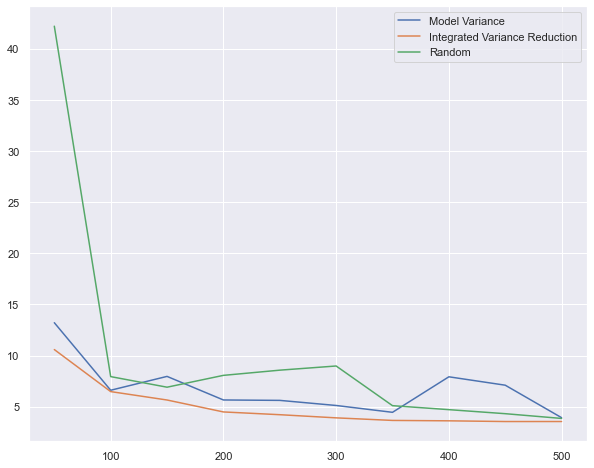

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
X_mv, Y_mv = zip(*mses_MV)
X_ivr, Y_ivr = zip(*mses_IVR)
X_rnd, Y_rnd = zip(*mses_RND)
ax.plot(X_mv, Y_mv, label='Model Variance')
ax.plot(X_ivr, Y_ivr, label='Integrated Variance Reduction')
ax.plot(X_rnd, Y_rnd, label='Random')
ax.legend()

### Save Models

In [34]:
with open(f'experimental_design/mmol/5param_model_variance_20_init_points_500_loops_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_mv, f)

with open(f'experimental_design/mmol/5param_integrated_variance_reduction_20_init_points_500_loops_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_ivr, f)
        
with open(f'experimental_design/mmol/5param_520_random_points_supervised_GP_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)
        
with open(f'experimental_design/mmol/mses.pkl', 'wb') as f:
    pickle.dump((mses_MV, mses_IVR, mses_RND), f)